In [ ]:
# Imports and utils

import os
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

import sys
sys.path.append('../../')
sys.path.append('../../..')
sys.path.append('')

sys.path.append('/home/yau/sequencing_the_neuron/reconstruction/uti')

from mdistiller.models import cifar_model_dict, imagenet_model_dict
from mdistiller.distillers import distiller_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint, log_msg
from mdistiller.engine.cfg import CFG as cfg
from mdistiller.engine.cfg import show_cfg

# get cifar100 class list
from mdistiller.dataset.cifar100 import get_data_folder
import torchvision.datasets as datasets

class_names = datasets.CIFAR100(root=get_data_folder(), train=False, download=True).classes

/home/yau/sequencing_the_neuron/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


In [ ]:
# Loading CDD checkpoint

def load_CDD(cfg_path, checkpoint):
    cfg.merge_from_file(cfg_path)
    cfg.freeze()
    num_classes = 100
    
    if cfg.DATASET.TYPE == "imagenet":
        model_teacher = imagenet_model_dict[cfg.DISTILLER.TEACHER](pretrained=True)
        model_student = imagenet_model_dict[cfg.DISTILLER.STUDENT](pretrained=False)
    else:
        model_student = cifar_model_dict[cfg.DISTILLER.STUDENT][0](
            num_classes=num_classes
        )
        model_dict = cifar_model_dict
        net, pretrain_model_path = model_dict[cfg.DISTILLER.TEACHER]
        assert (
            pretrain_model_path is not None
        ), "no pretrain model for teacher {}".format(cfg.DISTILLER.TEACHER)
        model_teacher = net(num_classes=num_classes)
    distiller = distiller_dict[cfg.DISTILLER.TYPE](model_student, model_teacher, cfg)
    distiller = nn.DataParallel(distiller)
    distiller.load_state_dict(load_checkpoint(checkpoint)["model"])
    return distiller, cfg

In [ ]:
# load checkpoint and get images

distiller, cfg = load_CDD("/home/yau/sequencing_the_neuron/mdistiller/configs/cifar100/CDD_10_epochs.yaml", "/home/yau/sequencing_the_neuron/mdistiller/output/cifar100_baselines/CDD cifar100 resnet (10 epochs of adverserial augmentation)/best")

train_loader, val_loader, num_data, num_classes = get_dataset(cfg)

/home/yau/sequencing_the_neuron/mdistiller/tools/visualizations/../../../mdistiller/engine/utils.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, m

Files already downloaded and verified
Files already downloaded and verified


In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn.functional as F
import torchvision
from torchvision import transforms

def unnormalize(tensor, mean, std):
    """
    Unnormalize a tensor using the specified mean and standard deviation.
    """
    mean = torch.tensor(mean).view(1, -1, 1, 1)
    std = torch.tensor(std).view(1, -1, 1, 1)
    return tensor * std + mean

def perturb_image(distiller, image, target, epochs=[0, 10], mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)):
    # Forward pass to get logits and augmented data
    results = distiller.module.forward_cd_eval(image, 0.01, epochs)
    
    # Unnormalize images for visualization
    batch_size = image.size(0)
    for i in range(batch_size):
        # Target label for the current image
        target_label = class_names[target[i].item()]

        # Set up a figure with subplots for each epoch
        num_epochs = len(results)
        fig, axes = plt.subplots(1, num_epochs, figsize=(5 * num_epochs, 5))
        
        if num_epochs == 1:  # In case there's only one epoch, axes won't be an array
            axes = [axes]

        for j, (epoch, data) in enumerate(results.items()):
            # Get logits and unnormalized image for the current epoch
            logits_student = data["student"][i]
            logits_teacher = data["teacher"][i]
            current_image = data["image"][i].unsqueeze(0)  # Select the ith image and ensure it has 3 dimensions (C, H, W)
            unnormalized_image = transforms.ToPILImage()(unnormalize(current_image, mean, std).squeeze(0))  # Remove batch dimension

            # Convert logits to probabilities
            probs_student = F.softmax(logits_student, dim=0)
            probs_teacher = F.softmax(logits_teacher, dim=0)

            # Get top 3 predictions for each model
            top3_student = torch.topk(probs_student, 3)
            top3_teacher = torch.topk(probs_teacher, 3)

            # Convert indices to labels
            student_labels = [class_names[idx] for idx in top3_student.indices]
            teacher_labels = [class_names[idx] for idx in top3_teacher.indices]

            # Display the image for the current epoch
            axes[j].imshow(unnormalized_image)
            axes[j].axis('off')
            axes[j].set_title(f"Epoch {epoch} Image")

            # Function to color labels based on match with target
            def colored_label(label):
                return 'green' if label == target_label else 'red'

            # Add legends with colored labels
            patches = []
            if epoch == 0:
                patches.append(mpatches.Patch(color='blue', label=f"Target: {target_label}"))

            patches.append(mpatches.Patch(color=colored_label(student_labels[0]), label=f"S: {', '.join(student_labels)}"))
            patches.append(mpatches.Patch(color=colored_label(teacher_labels[0]), label=f"T: {', '.join(teacher_labels)}"))
            patches.append(mpatches.Patch(label=f"Loss: {data['loss'][i]:.3e}"))

            axes[j].legend(handles=patches, loc="upper right", fontsize=8)

        plt.show()


In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

def accuracy_vs_epochs(max_epochs, epoch_step, lr=0.1):
    # Create a list of epochs to evaluate
    epochs_list = list(range(0, max_epochs + 1, epoch_step))
    print(f"epochs: {epochs_list}")
    # Initialize dictionaries to hold top-1 and top-5 accuracies for both models
    student_top1_accuracies = {epoch: 0 for epoch in epochs_list}
    student_top5_accuracies = {epoch: 0 for epoch in epochs_list}
    teacher_top1_accuracies = {epoch: 0 for epoch in epochs_list}
    teacher_top5_accuracies = {epoch: 0 for epoch in epochs_list}
    total_images = 0  # Track the total number of images for averaging

    # Loop through validation data with tqdm progress bar
    for image, targe, index in tqdm(train_loader, desc="Processing validation batches"):
        # Get logits from the distiller at the specified epochs
        results = distiller.module.forward_cd_eval(image, lr, epochs_list)
        
        for epoch, data in results.items():
            # Get student and teacher logits for each epoch
            logits_student = data["student"]
            logits_teacher = data["teacher"]

            # Calculate top-1 and top-5 predictions for student and teacher
            _, pred_student_top5 = logits_student.topk(5, dim=1)
            _, pred_teacher_top5 = logits_teacher.topk(5, dim=1)

            # Top-1 accuracy: only the top prediction matches the target
            student_top1_accuracies[epoch] += (pred_student_top5[:, 0] == target).sum().item()
            teacher_top1_accuracies[epoch] += (pred_teacher_top5[:, 0] == target).sum().item()

            # Top-5 accuracy: target label is within the top 5 predictions
            student_top5_accuracies[epoch] += sum(target[i].item() in pred_student_top5[i] for i in range(len(target)))
            teacher_top5_accuracies[epoch] += sum(target[i].item() in pred_teacher_top5[i] for i in range(len(target)))

        total_images += image.size(0)  # Update the count of total images processed

    # Calculate the average accuracy for each epoch
    student_top1_accuracies = {epoch: acc / total_images for epoch, acc in student_top1_accuracies.items()}
    student_top5_accuracies = {epoch: acc / total_images for epoch, acc in student_top5_accuracies.items()}
    teacher_top1_accuracies = {epoch: acc / total_images for epoch, acc in teacher_top1_accuracies.items()}
    teacher_top5_accuracies = {epoch: acc / total_images for epoch, acc in teacher_top5_accuracies.items()}

    # Plot the results
    plt.figure(figsize=(12, 6))
    
    # Plot student model accuracies
    plt.plot(epochs_list, list(student_top1_accuracies.values()), label="Student Top-1 Accuracy", color="blue", marker="o")
    plt.plot(epochs_list, list(student_top5_accuracies.values()), label="Student Top-5 Accuracy", color="cyan", marker="o")
    
    # Plot teacher model accuracies
    plt.plot(epochs_list, list(teacher_top1_accuracies.values()), label="Teacher Top-1 Accuracy", color="orange", marker="o")
    plt.plot(epochs_list, list(teacher_top5_accuracies.values()), label="Teacher Top-5 Accuracy", color="red", marker="o")
    
    # Plot labels and legend
    plt.xlabel("Number of Epochs of Augmentation")
    plt.ylabel("Validation Accuracy")
    plt.title("Validation Accuracy vs. Number of Epochs of Augmentation")
    plt.legend()
    plt.grid(True)
    plt.show()


epochs: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


Processing validation batches: 100%|██████████| 157/157 [2:36:56<00:00, 59.98s/it] 


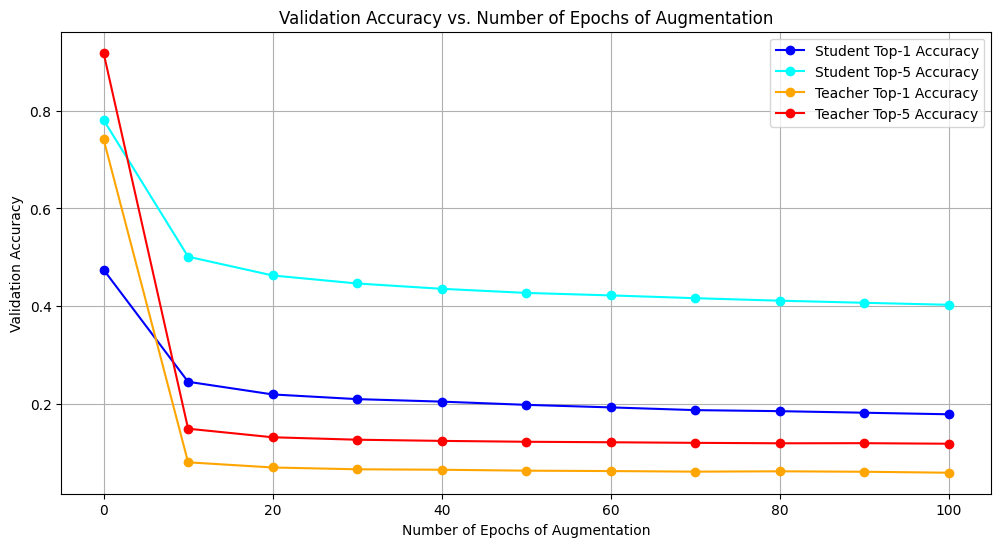

In [25]:
accuracy_vs_epochs(max_epochs=100, epoch_step=10)

torch.Size([64, 3, 32, 32])


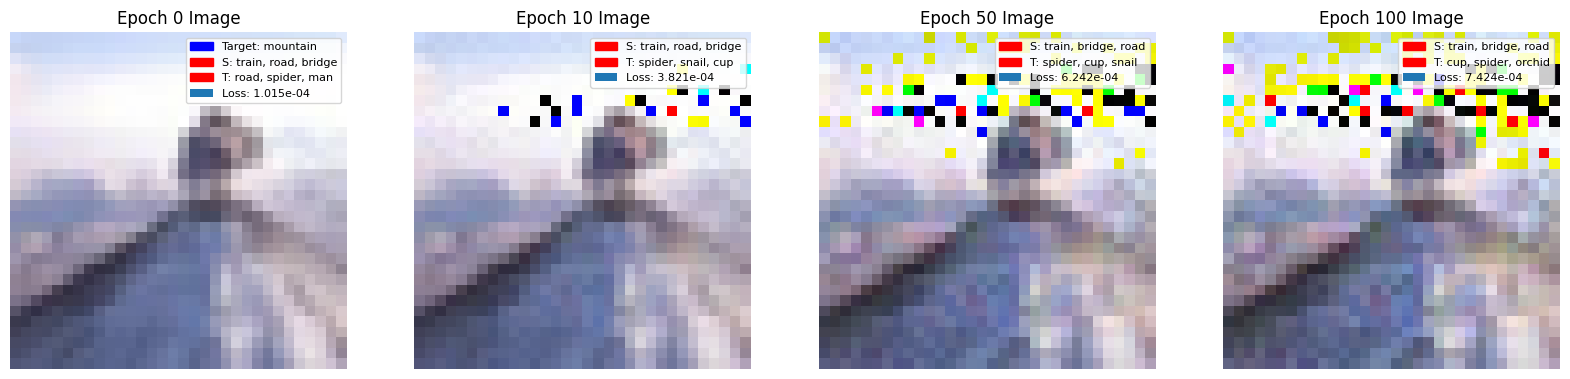

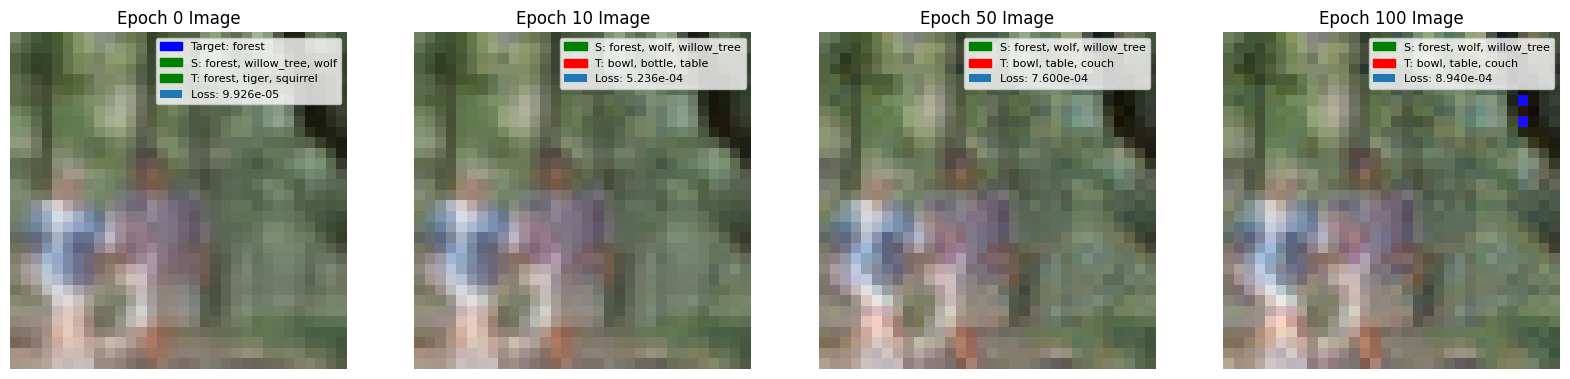

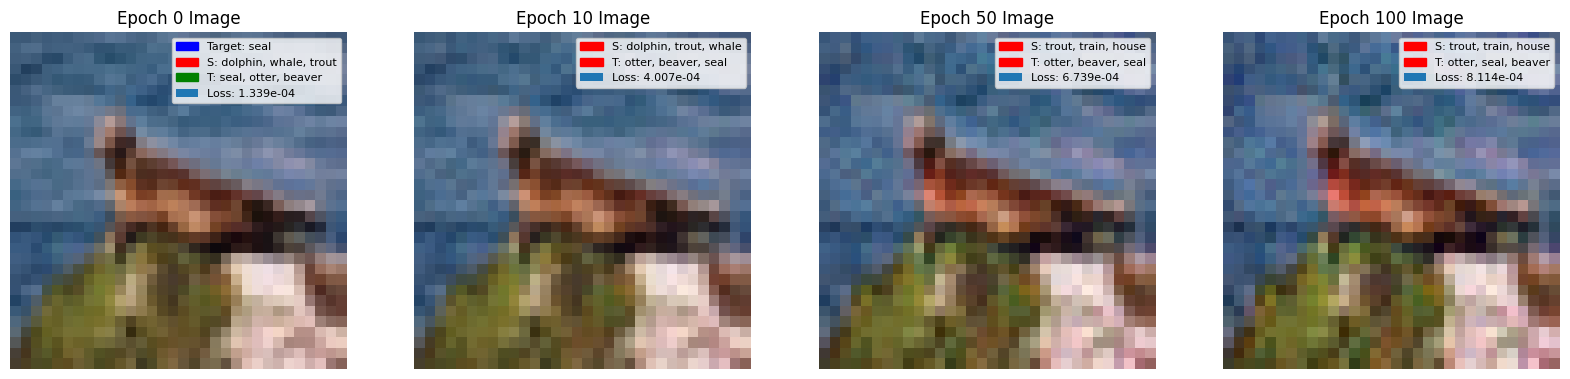

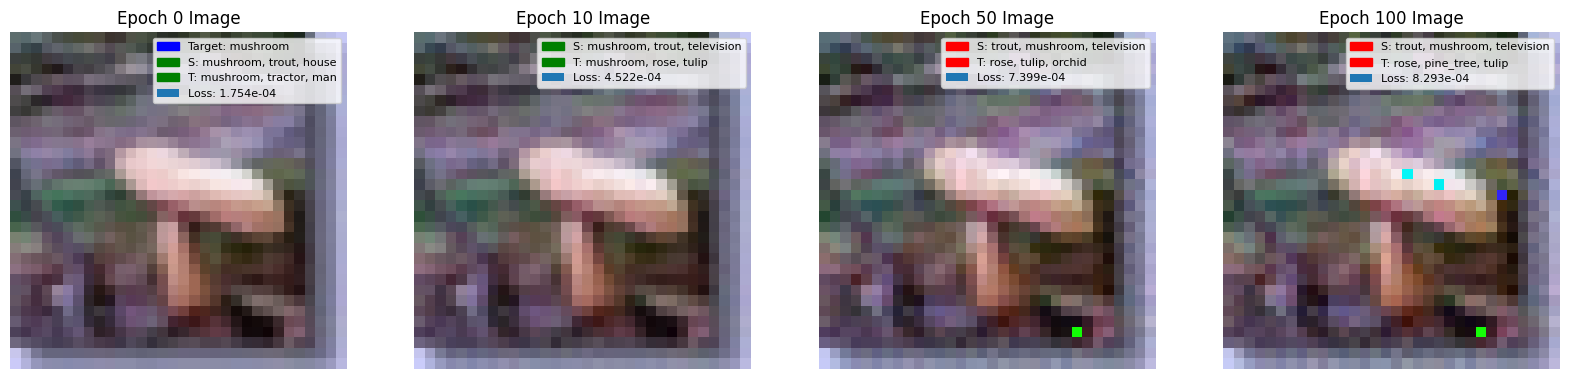

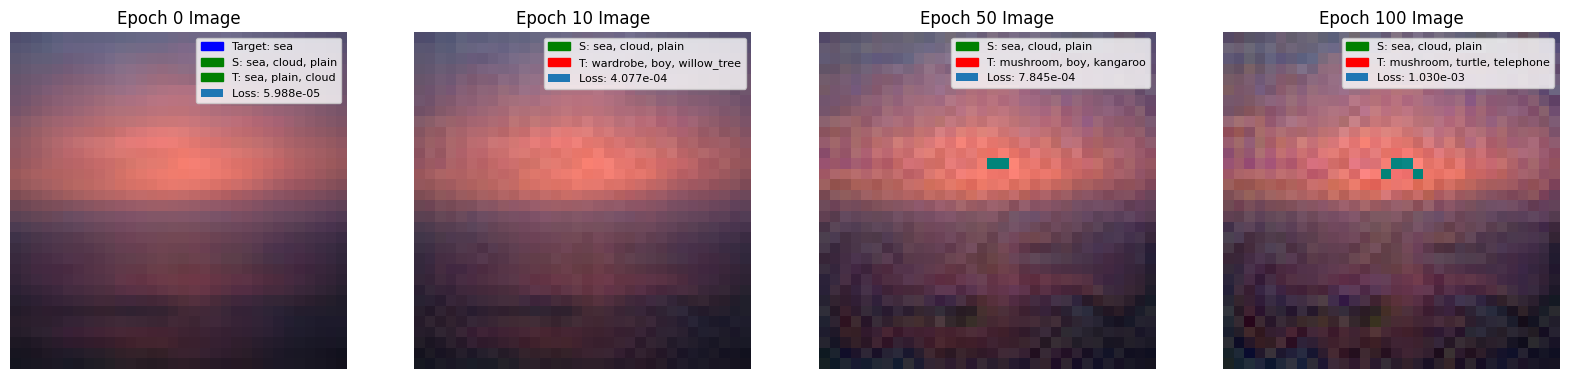

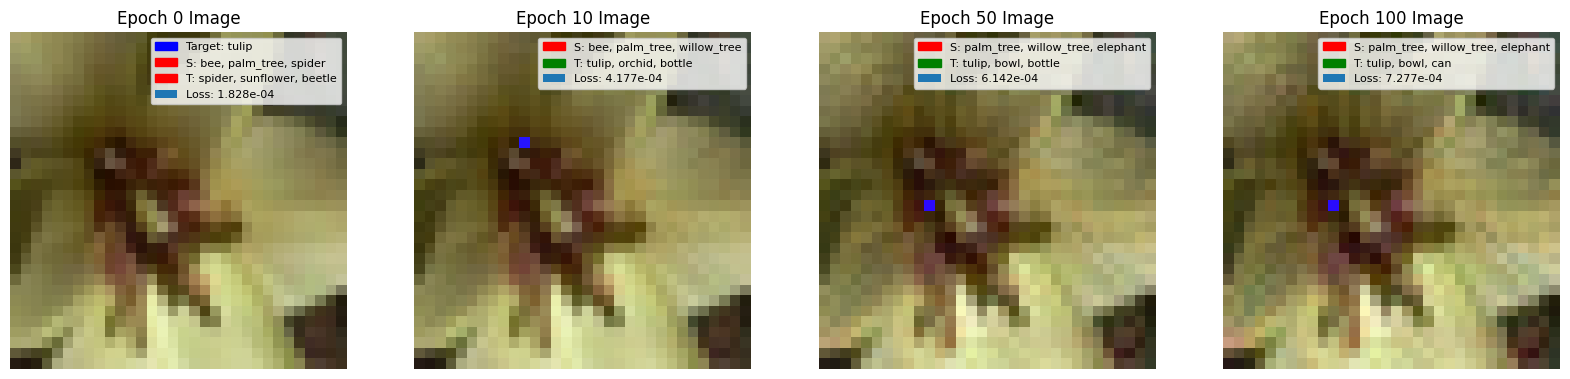

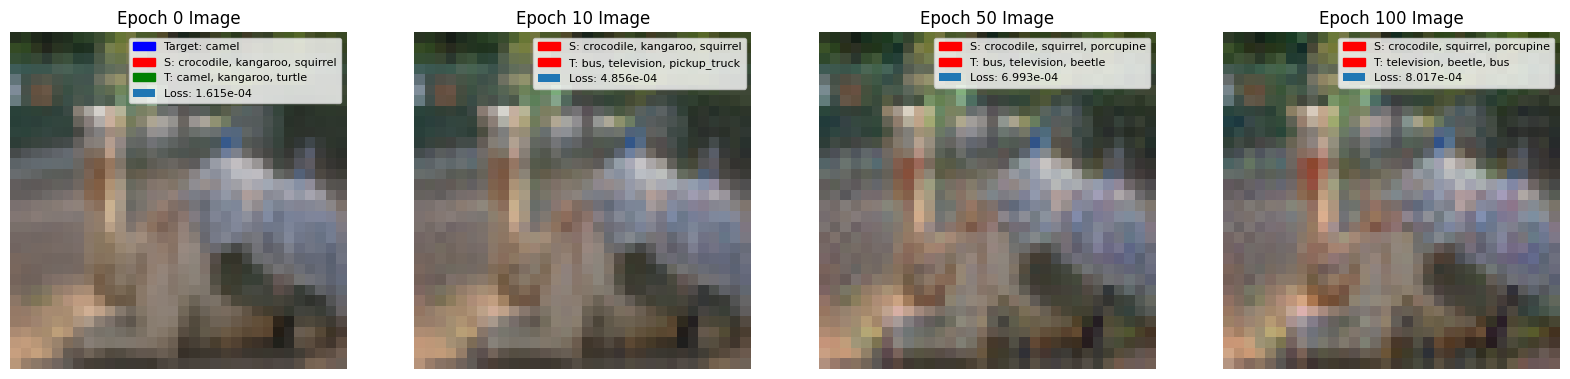

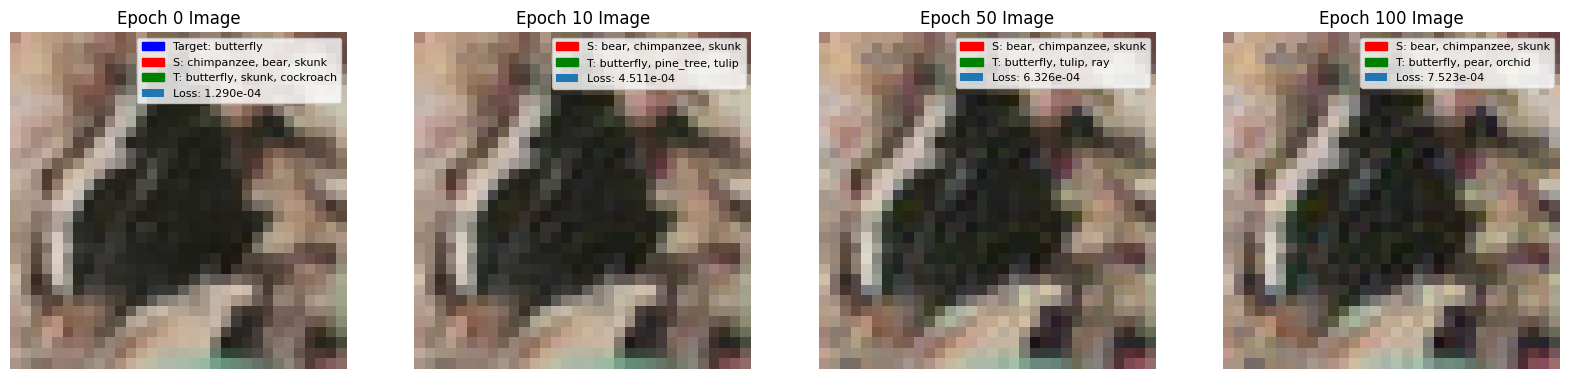

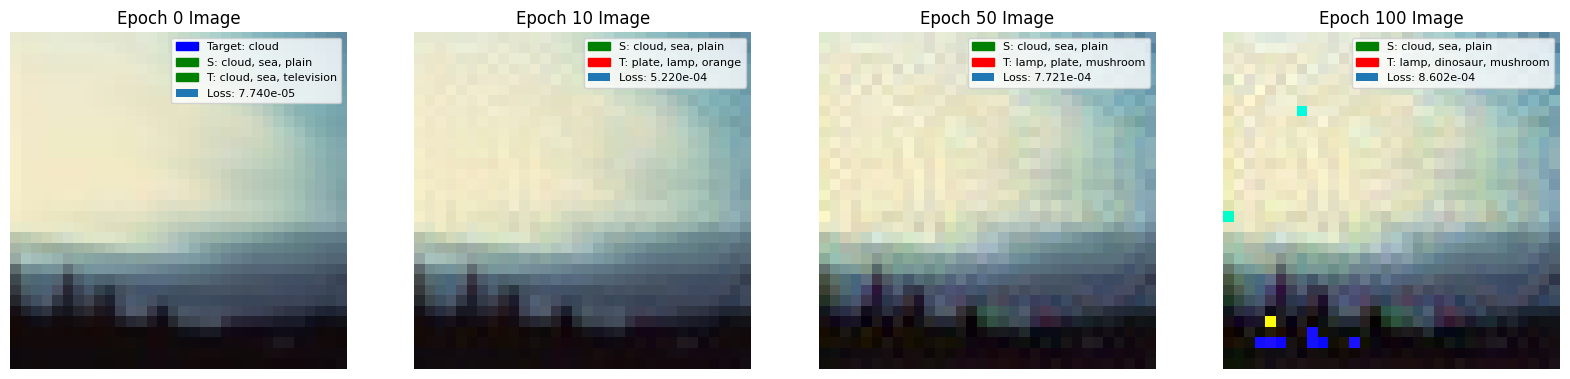

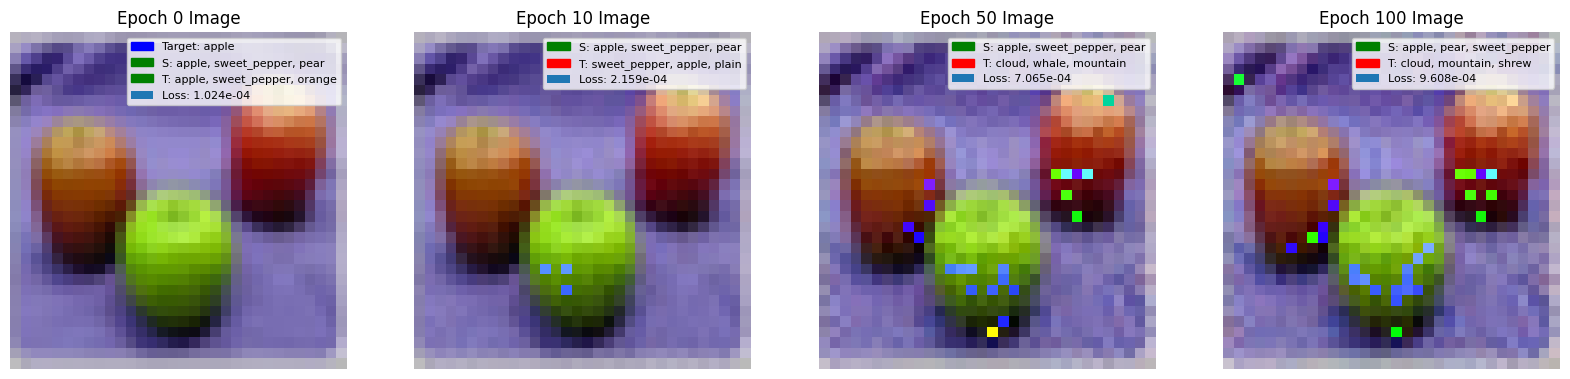

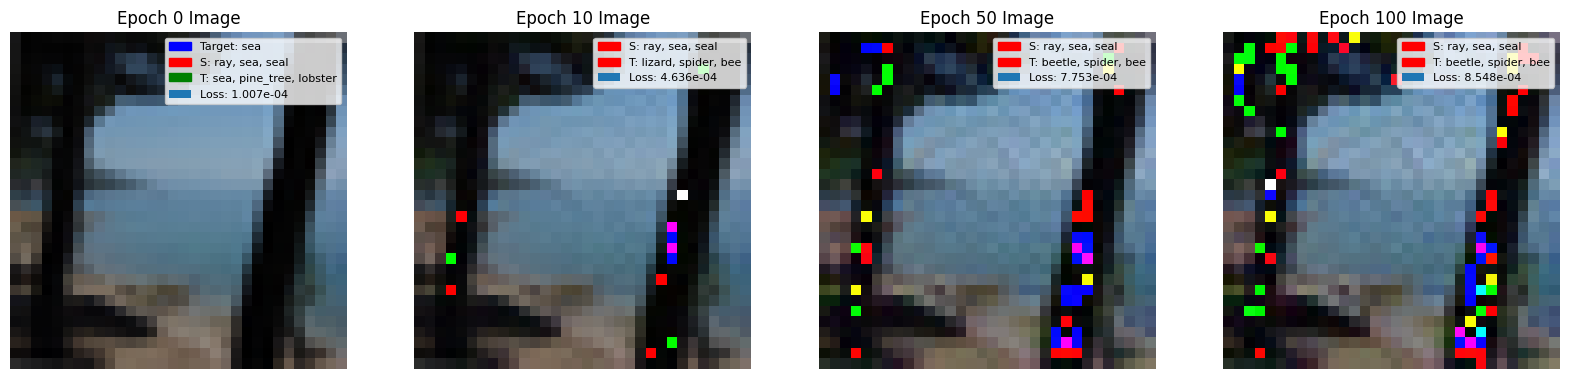

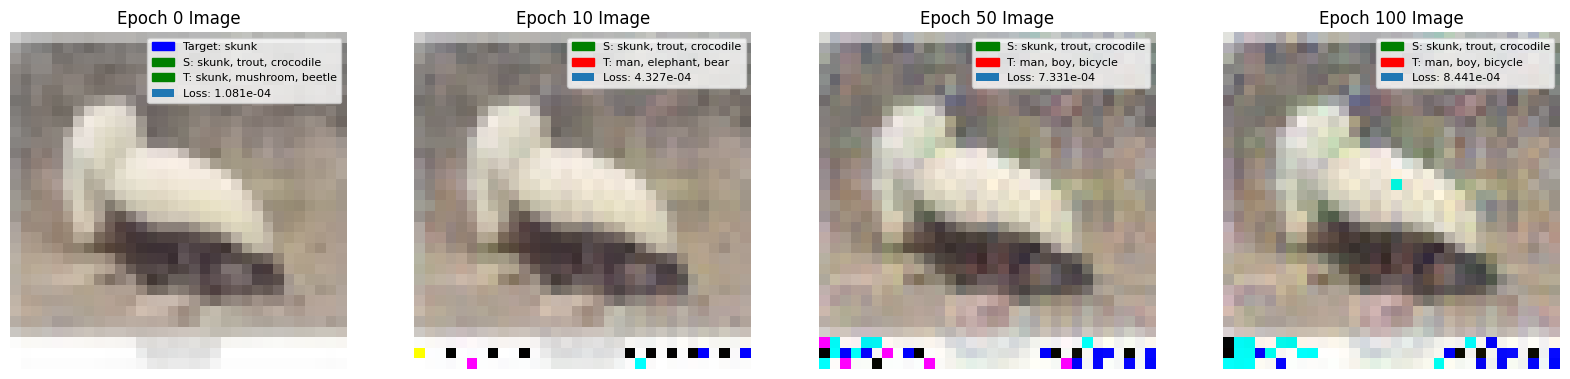

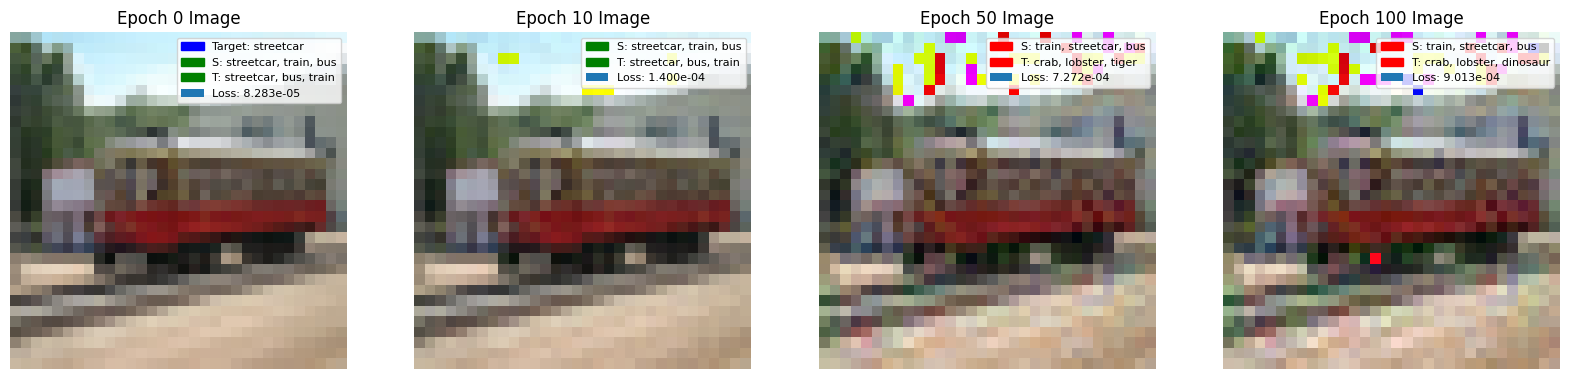

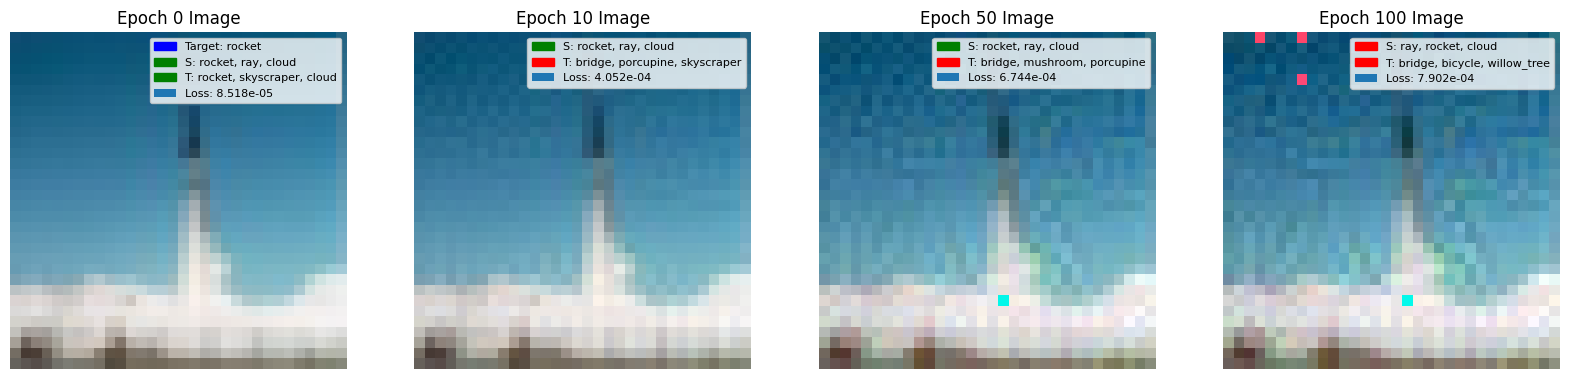

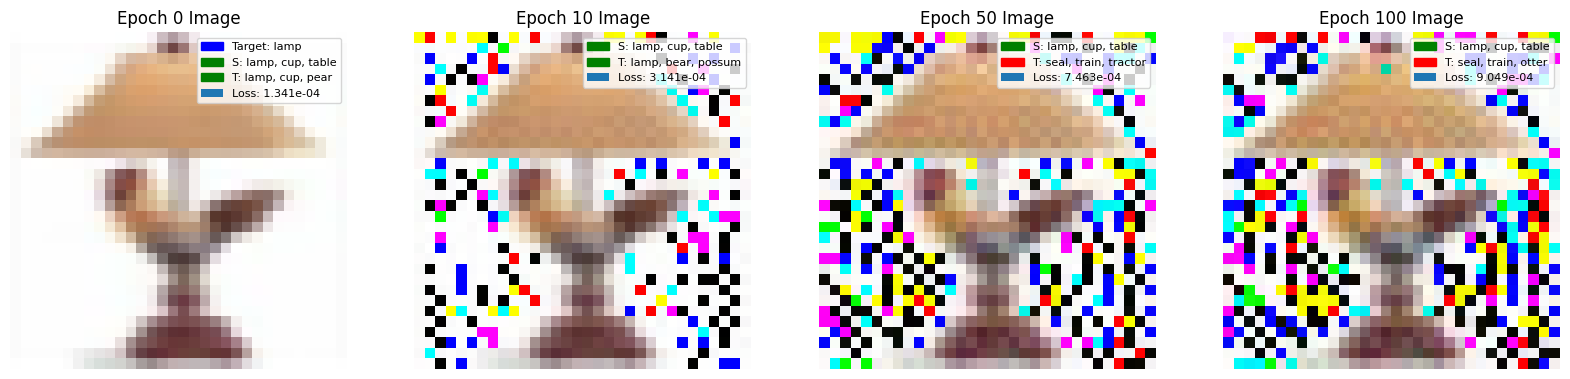

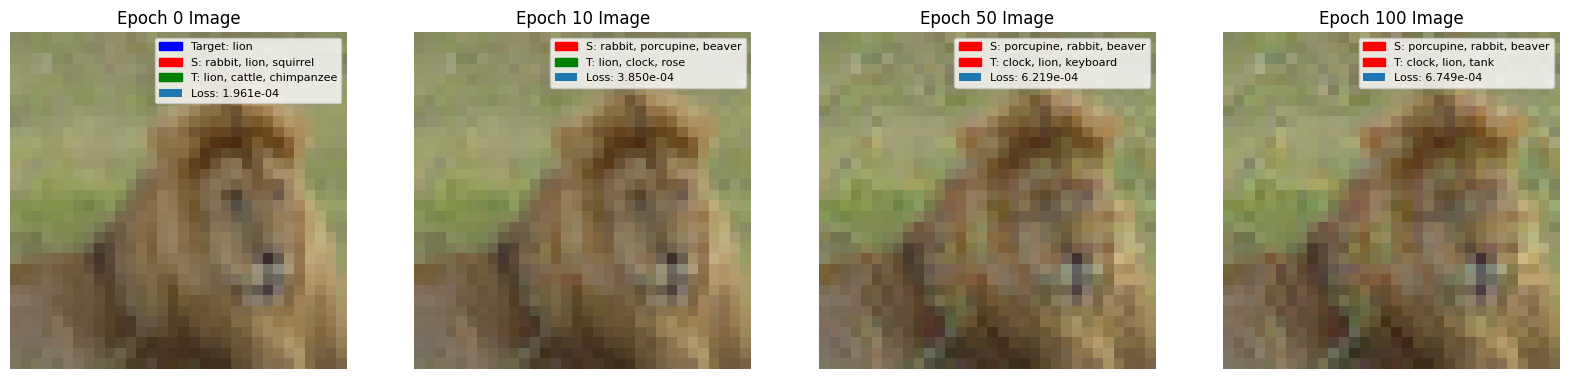

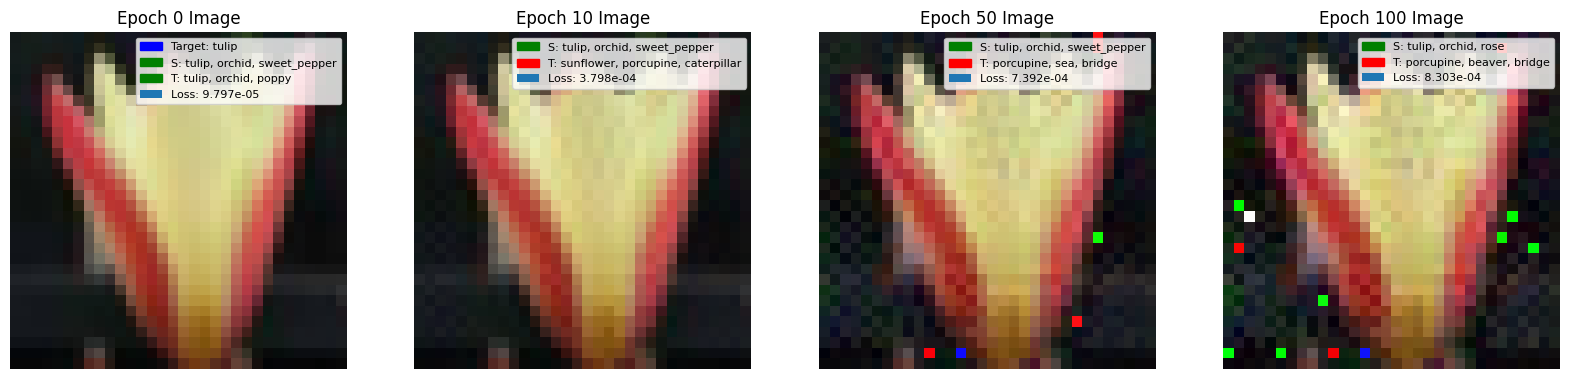

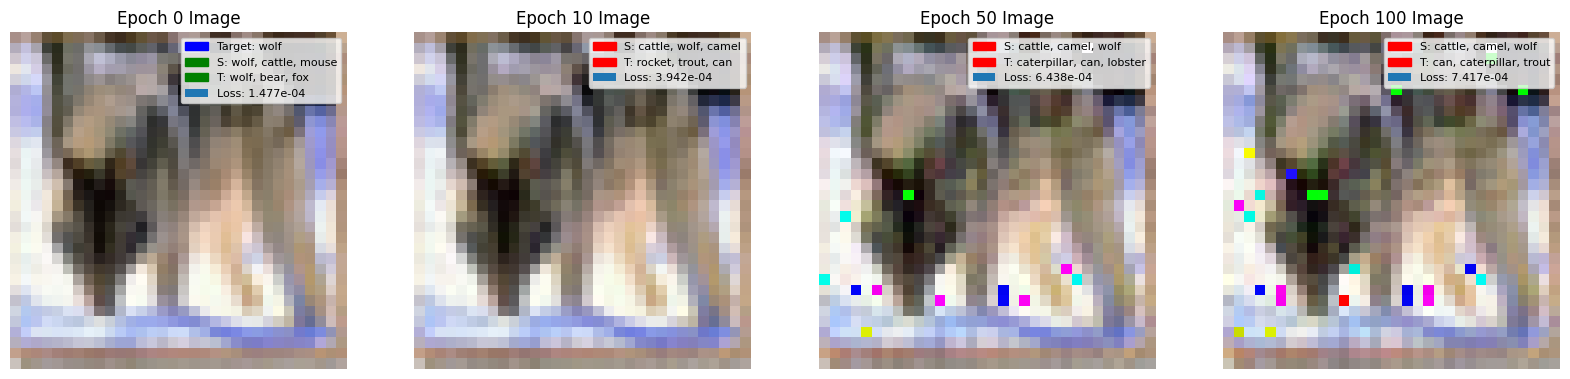

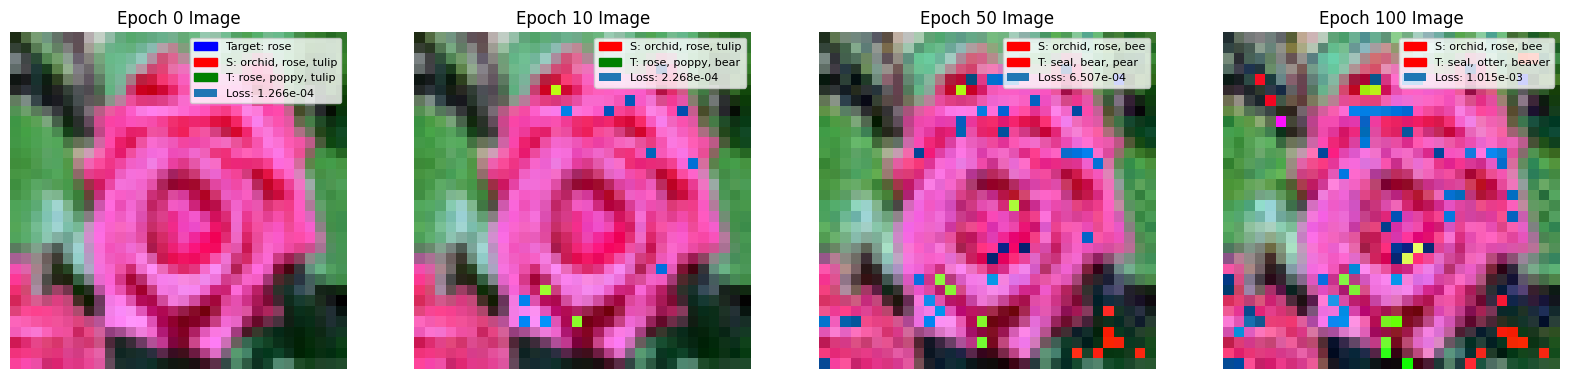

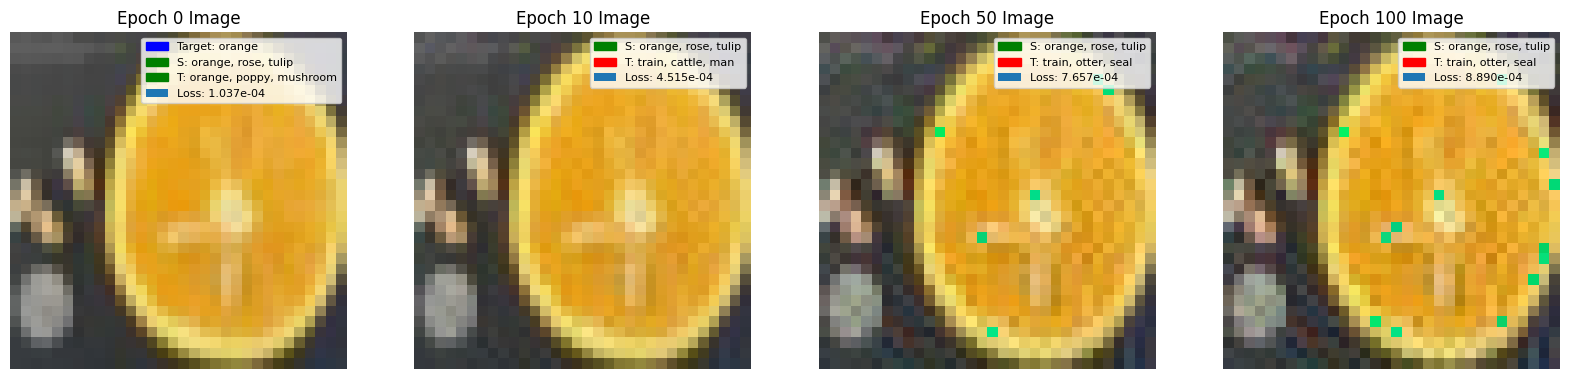

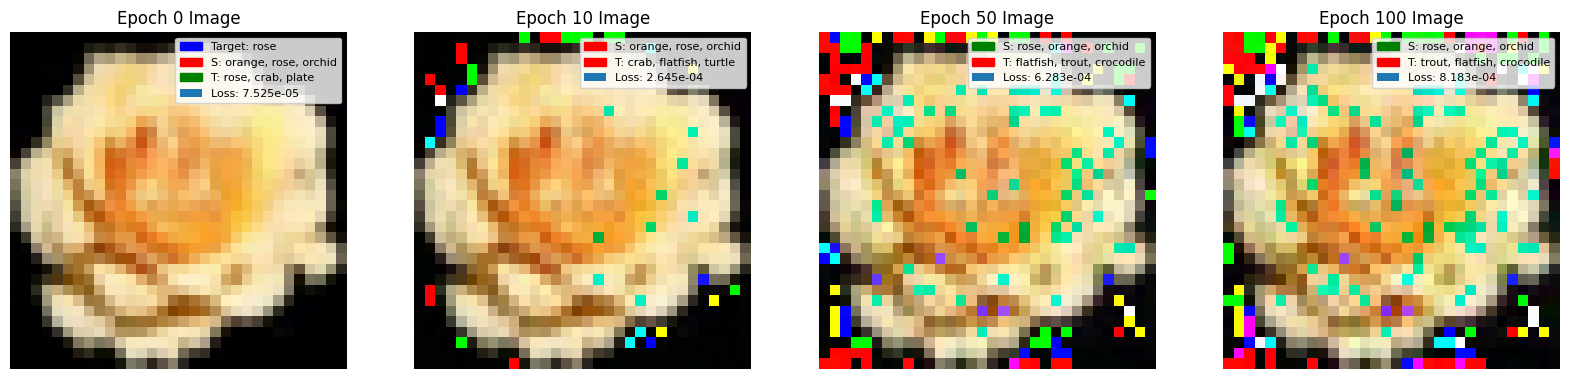

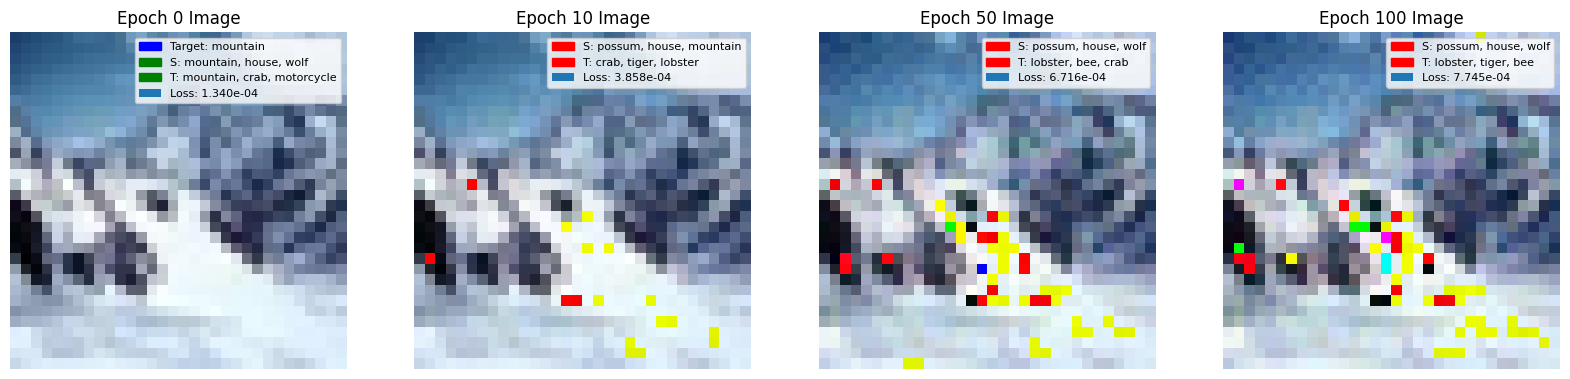

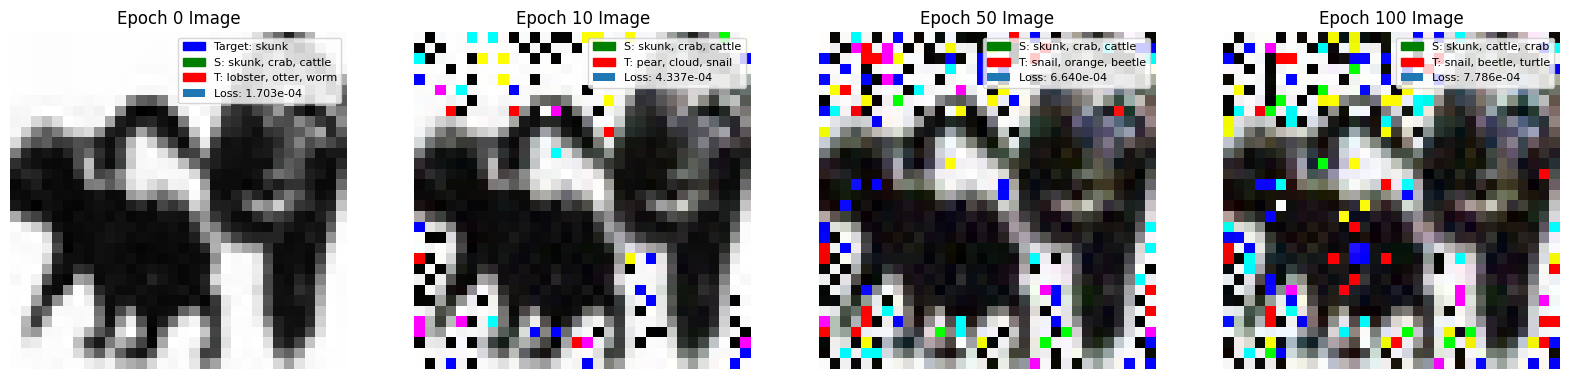

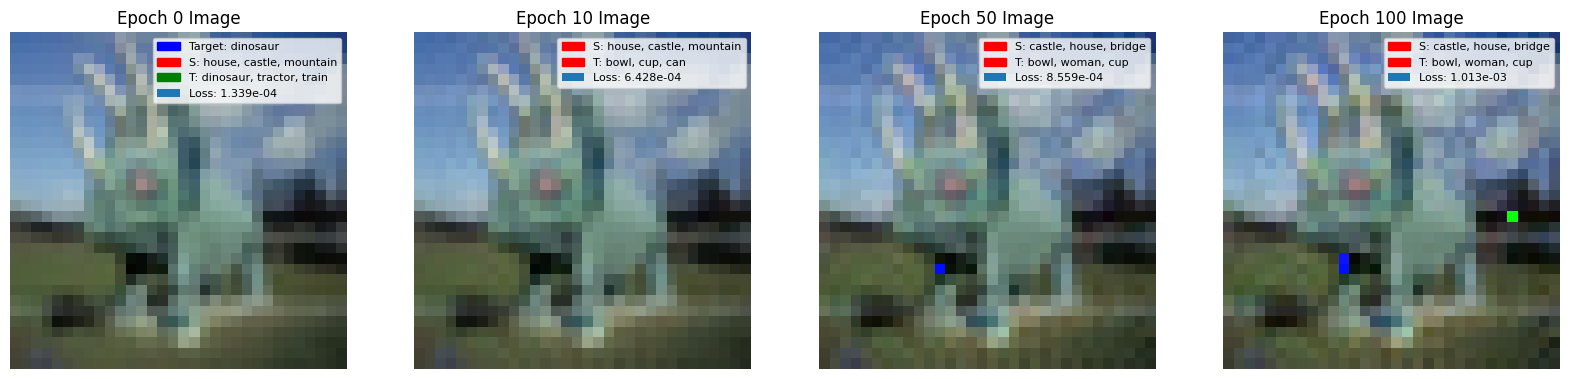

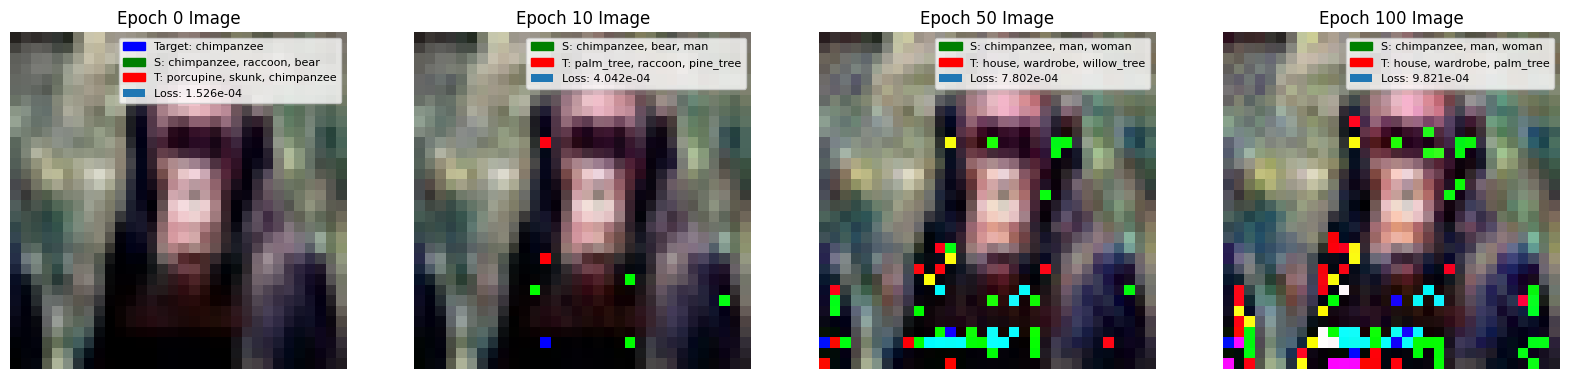

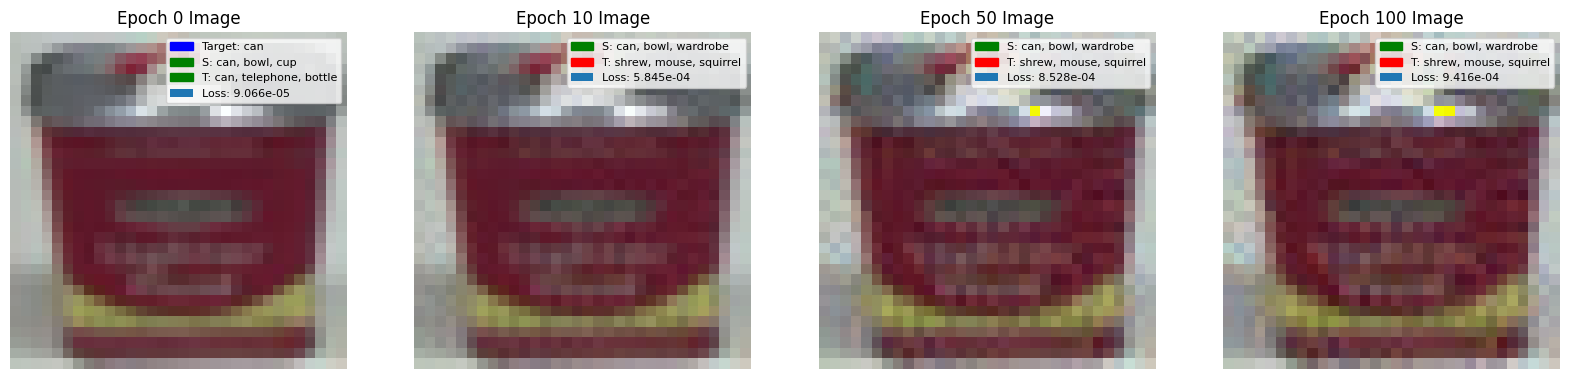

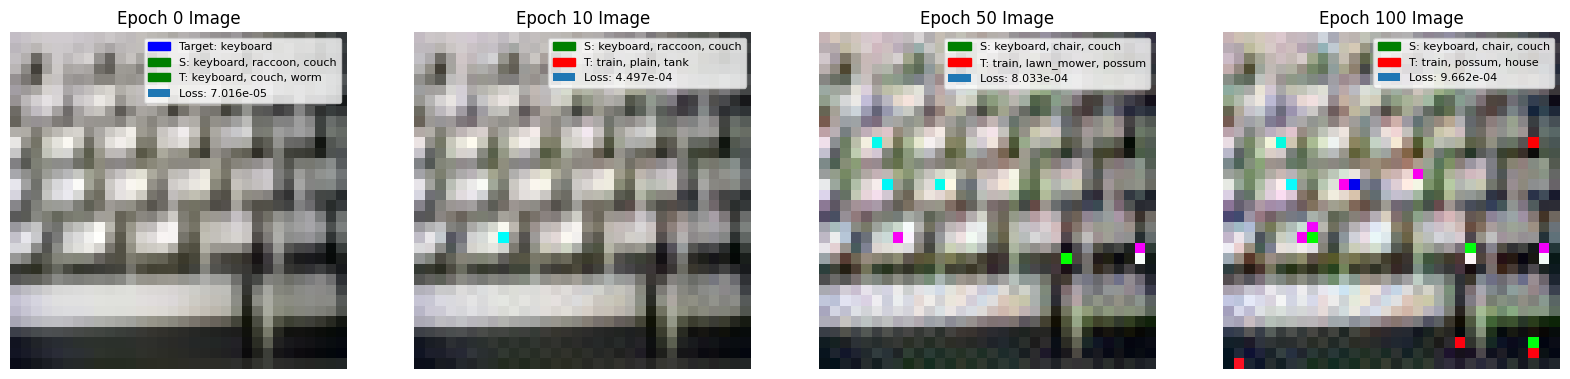

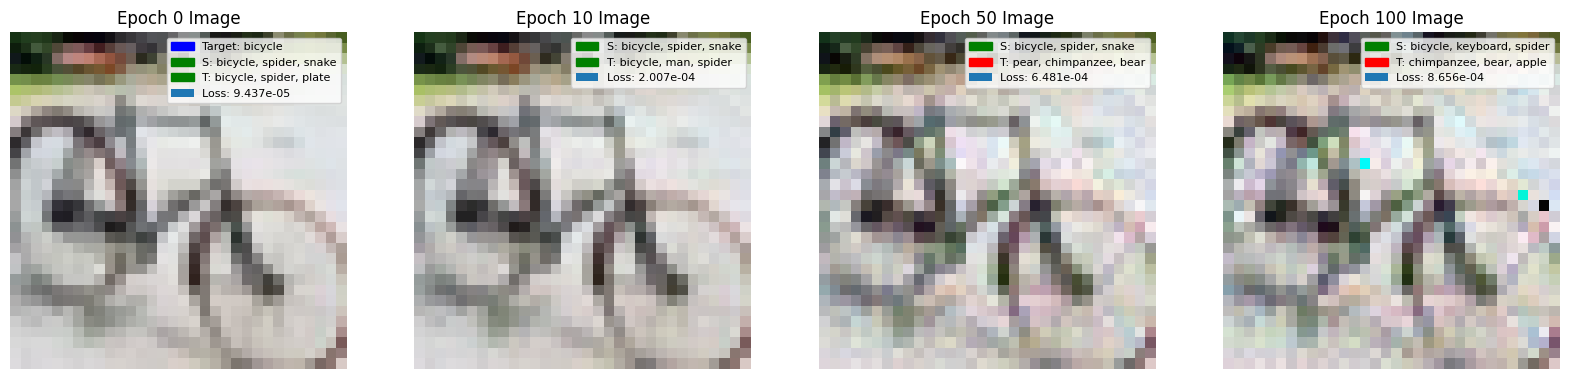

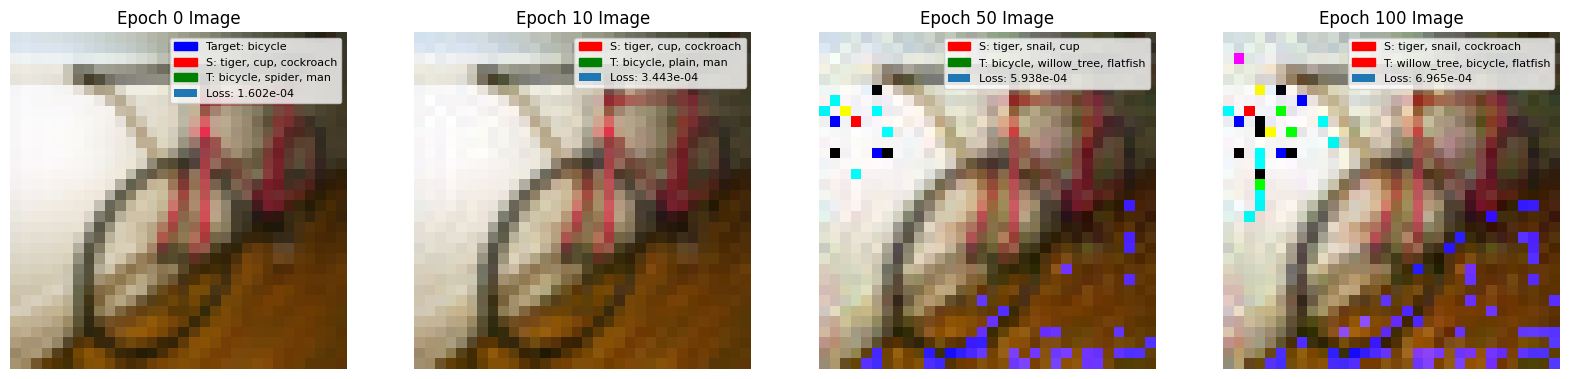

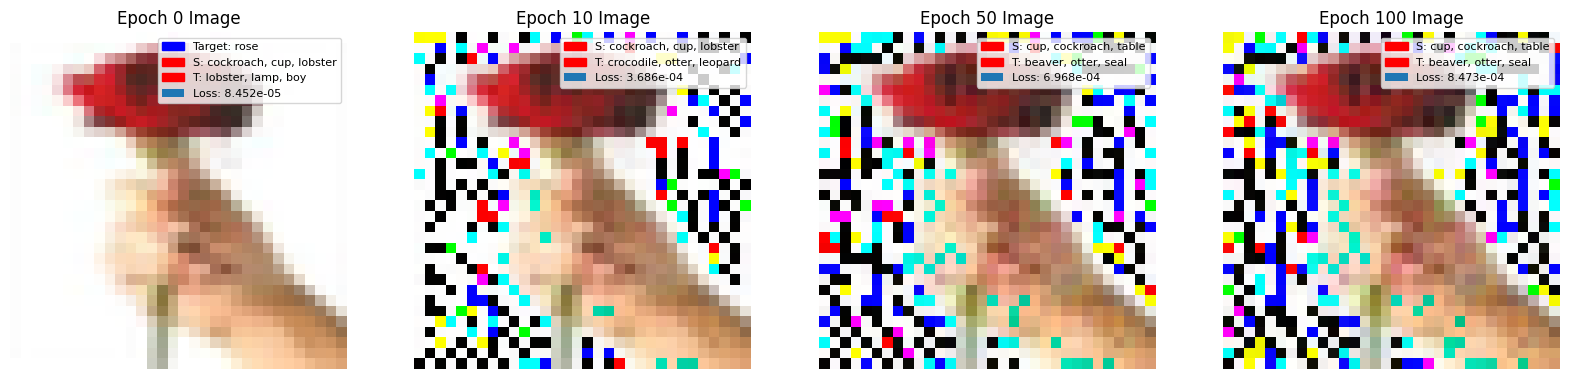

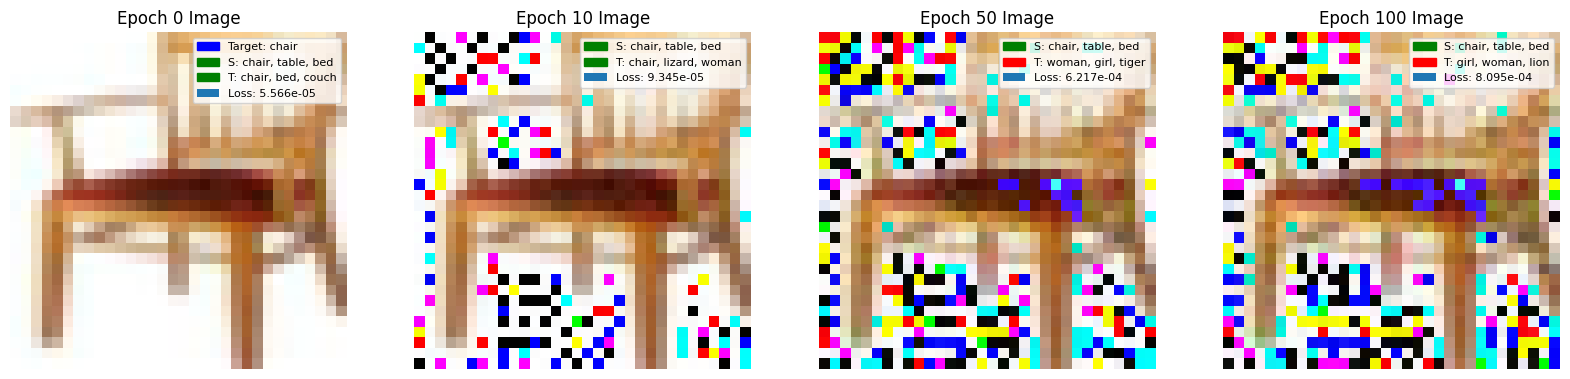

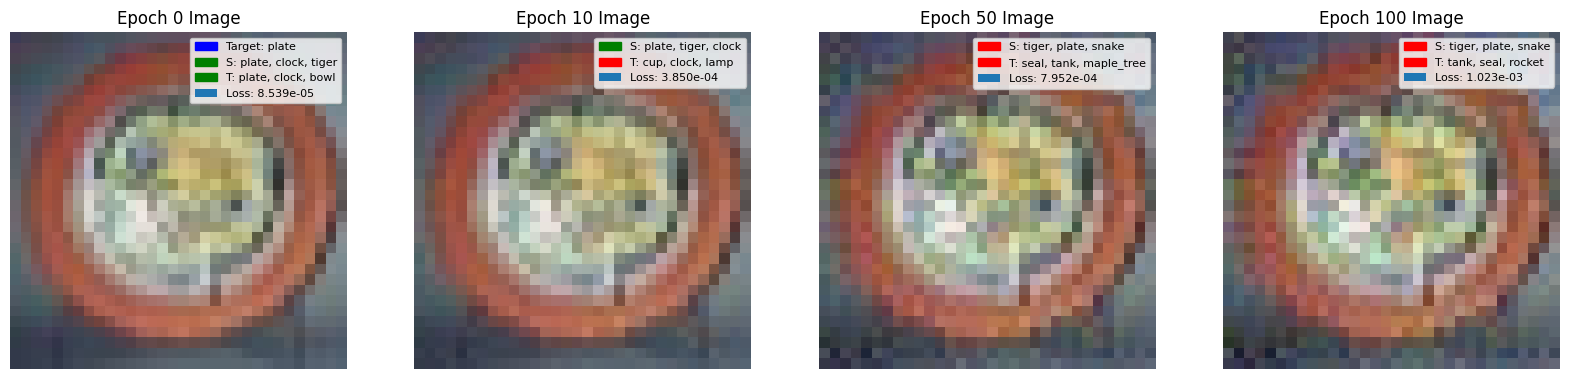

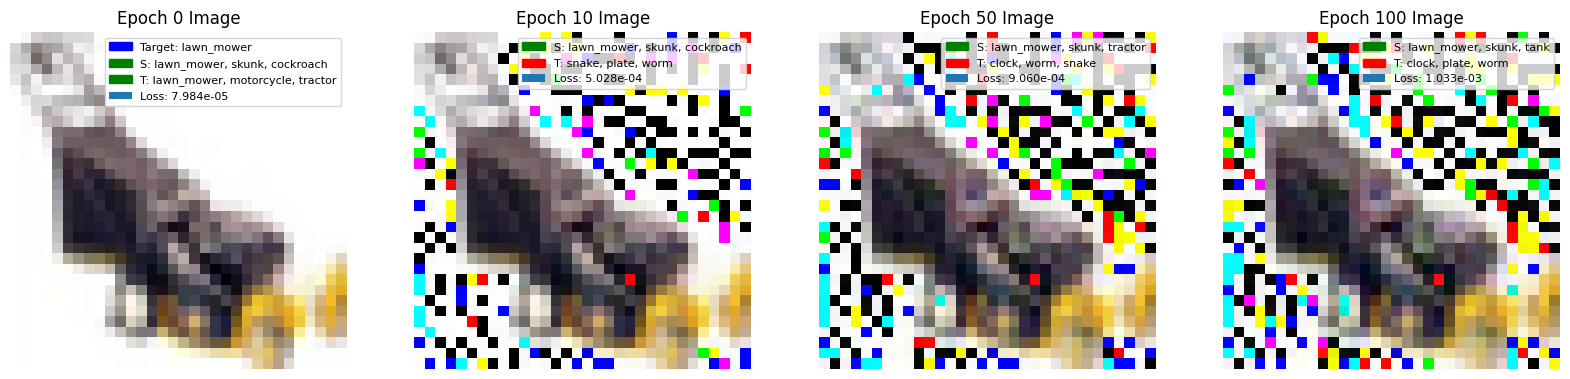

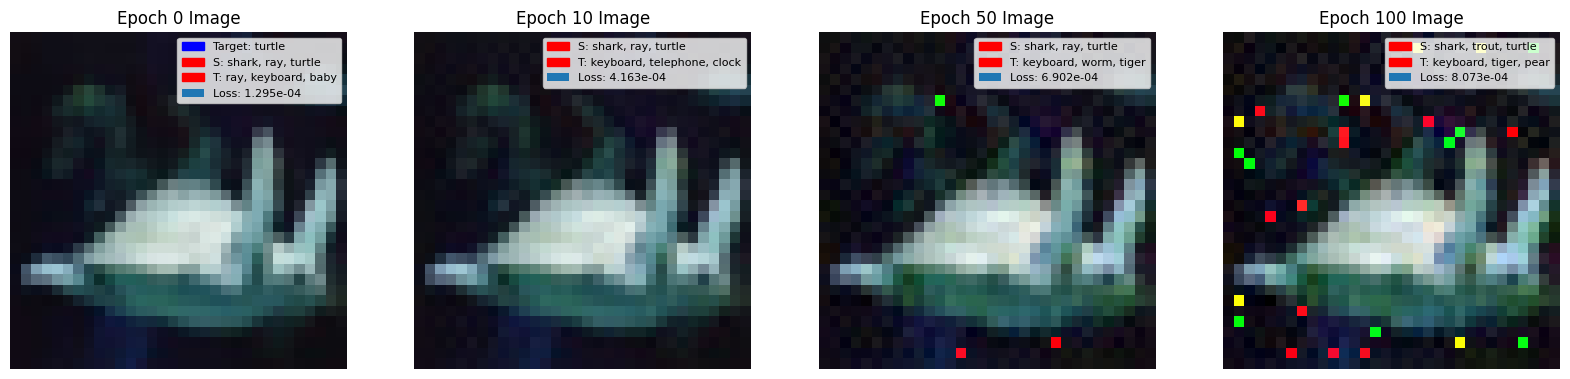

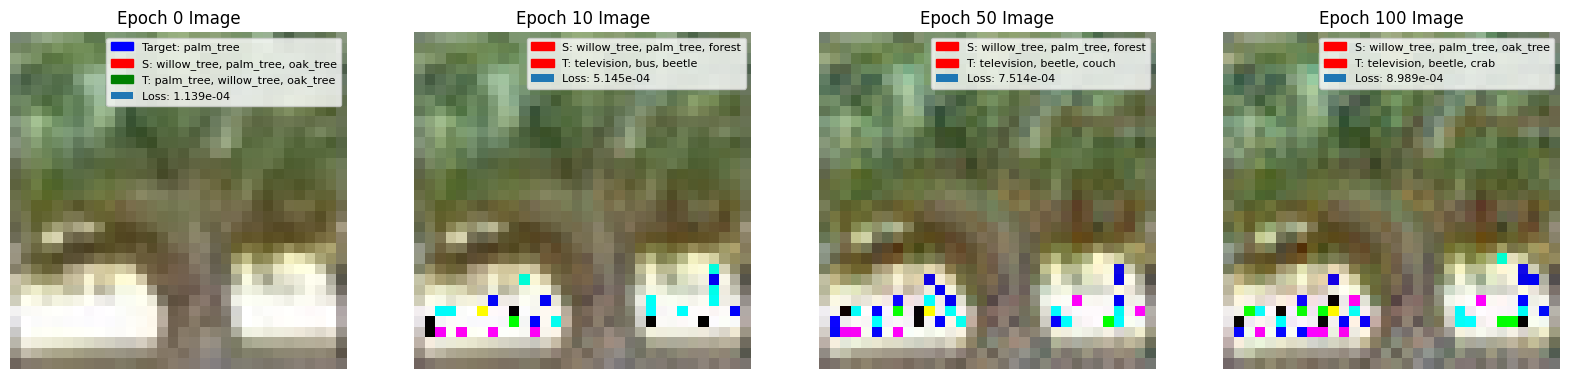

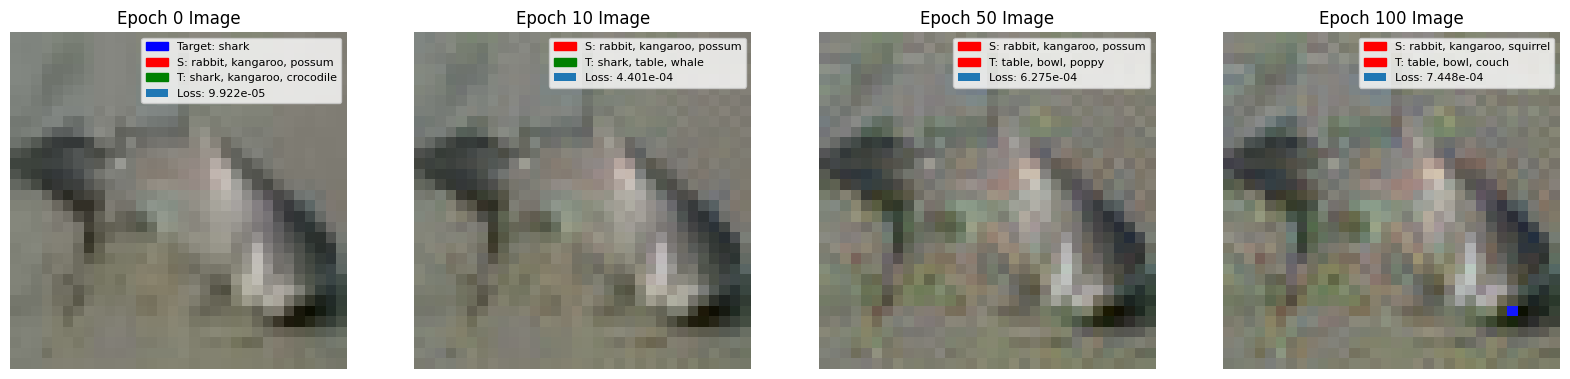

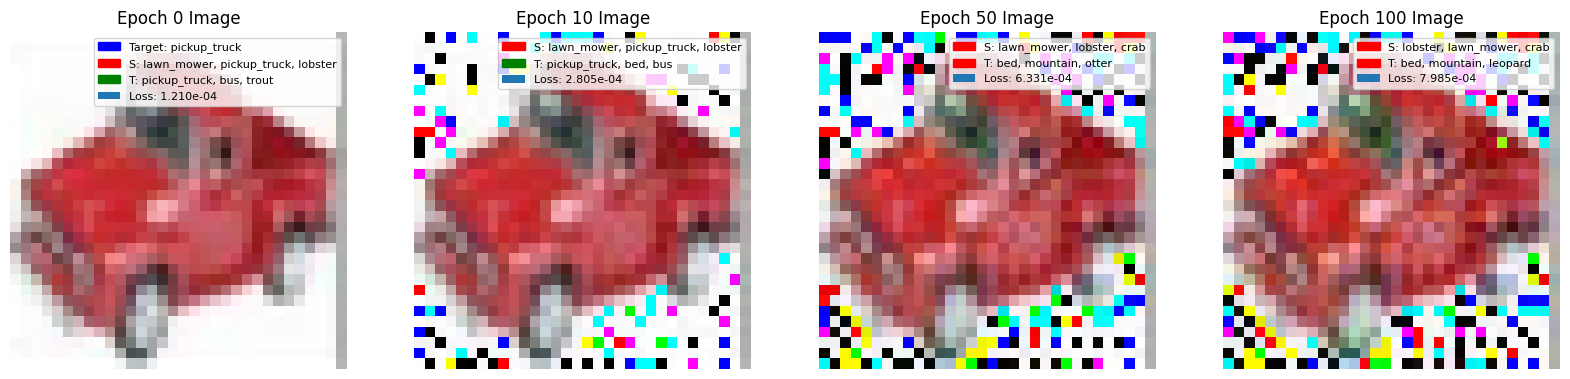

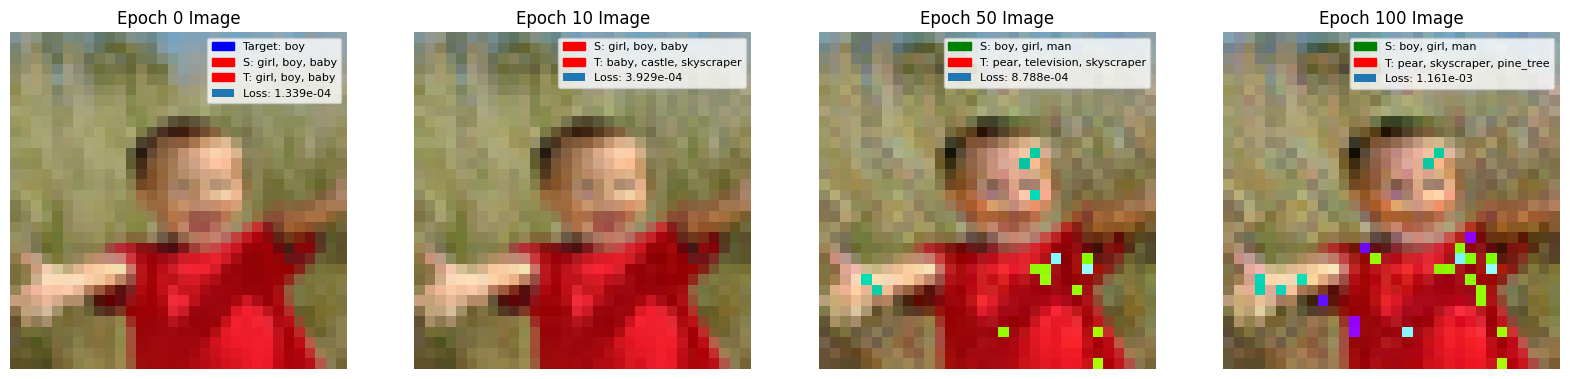

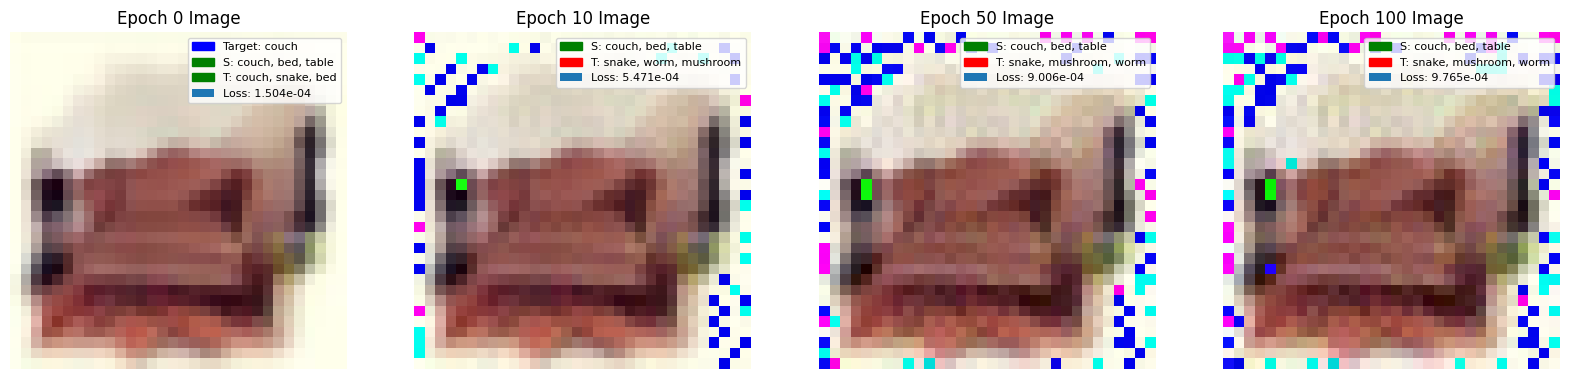

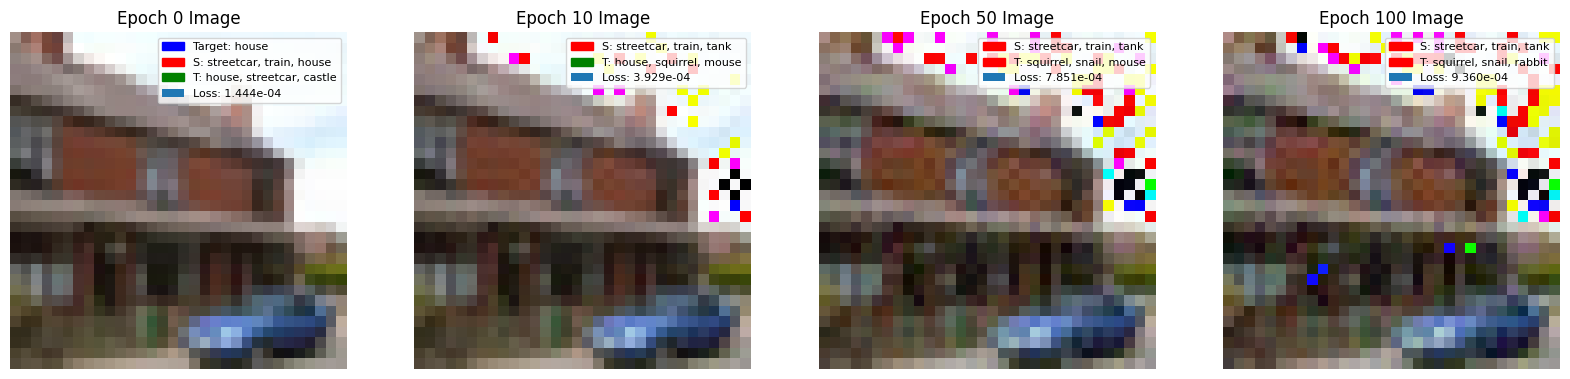

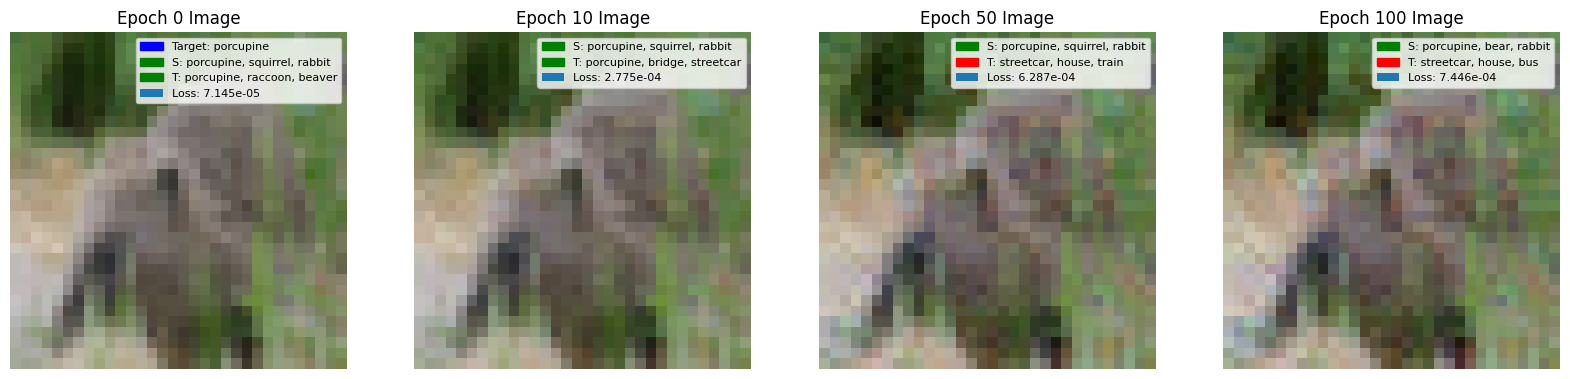

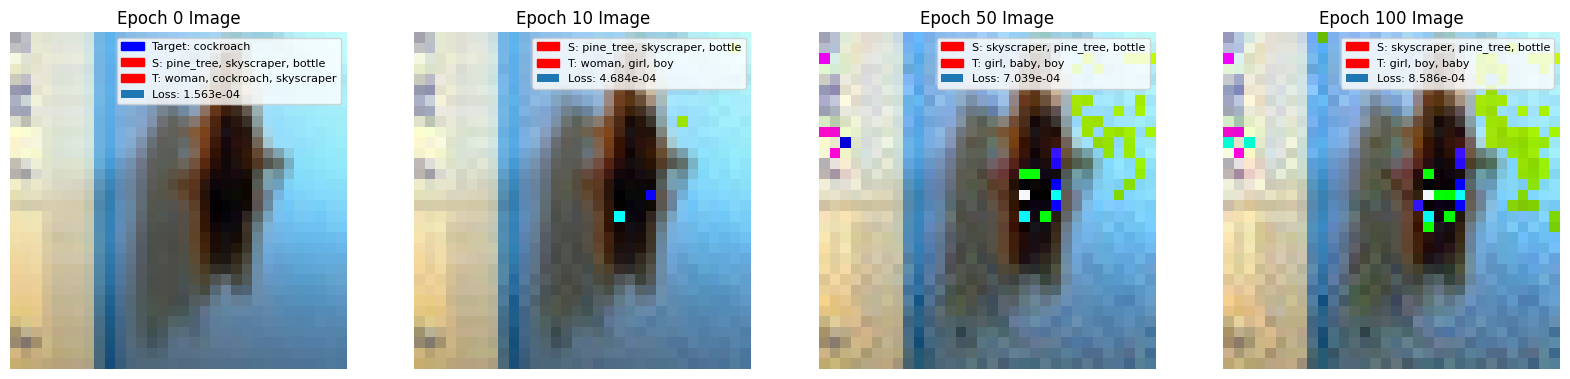

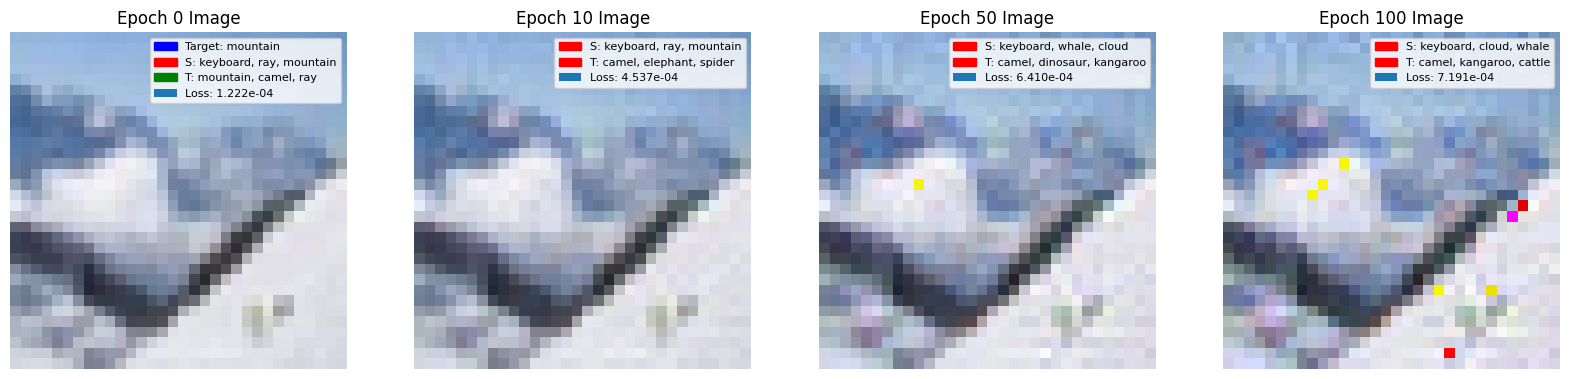

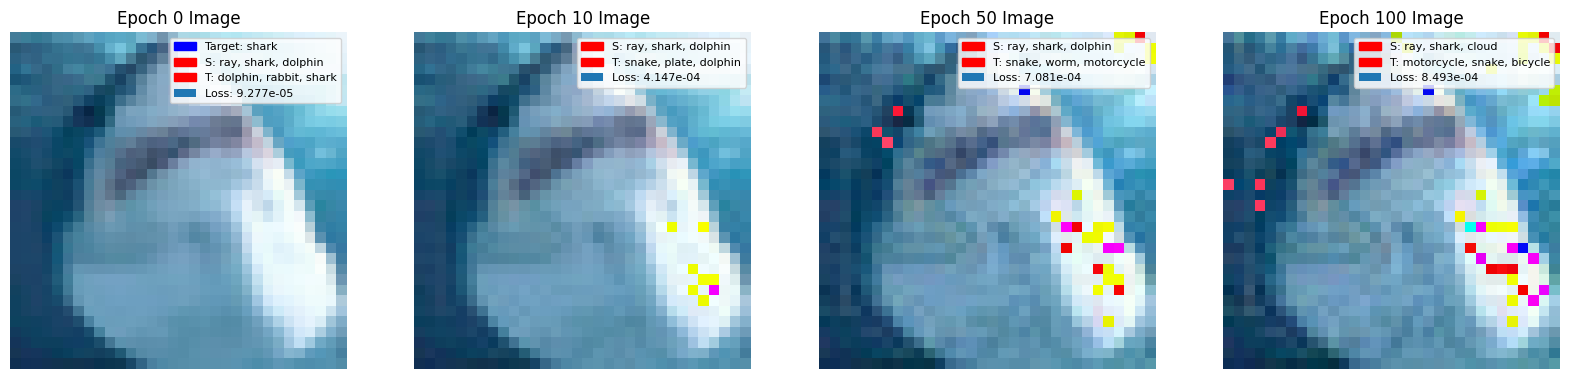

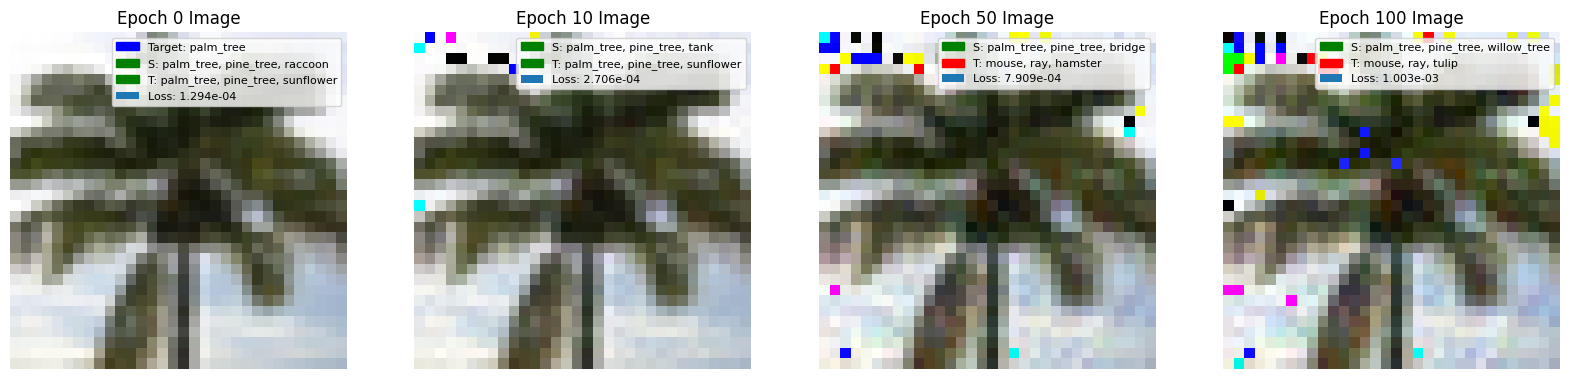

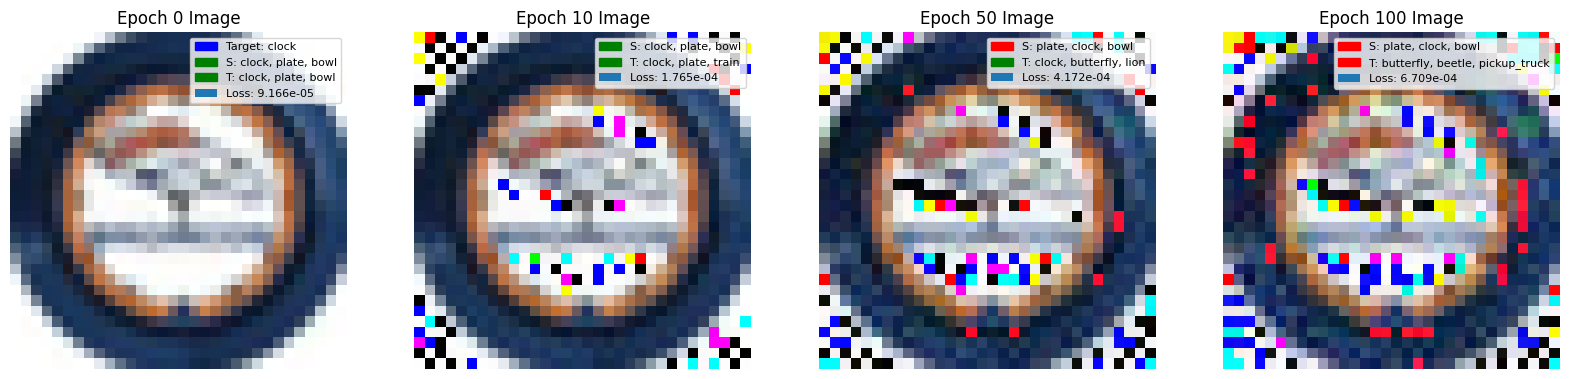

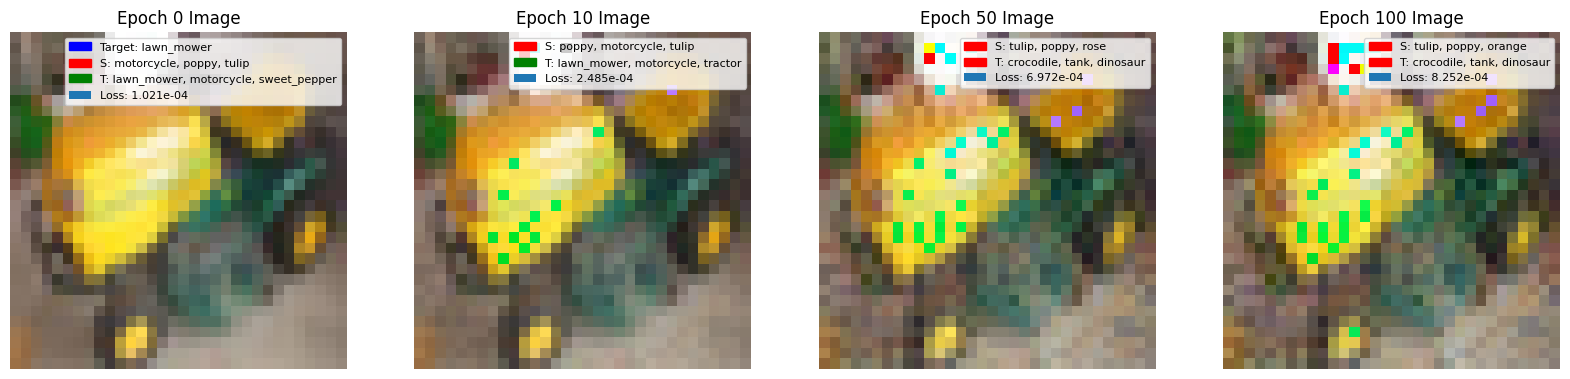

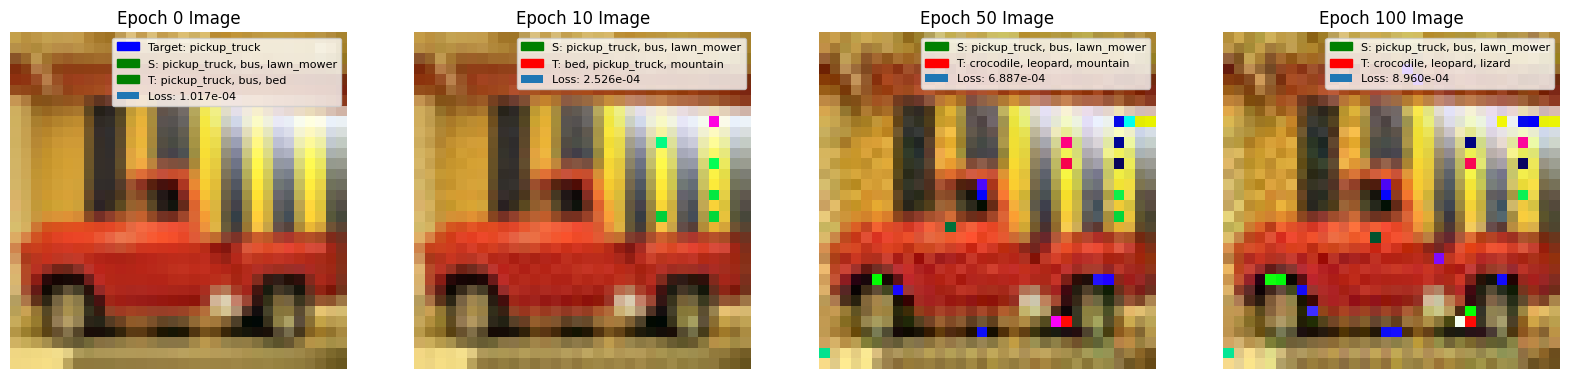

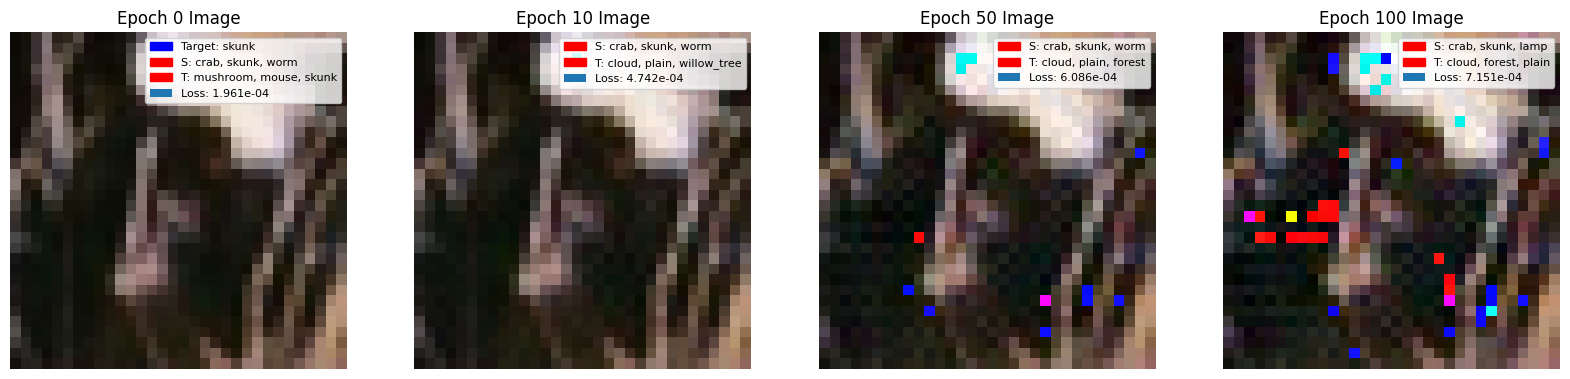

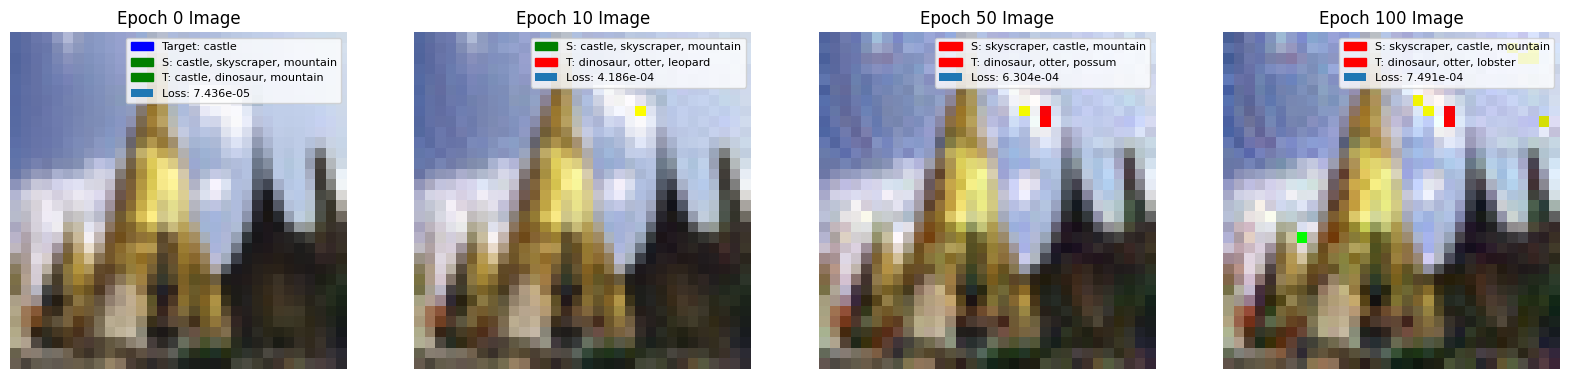

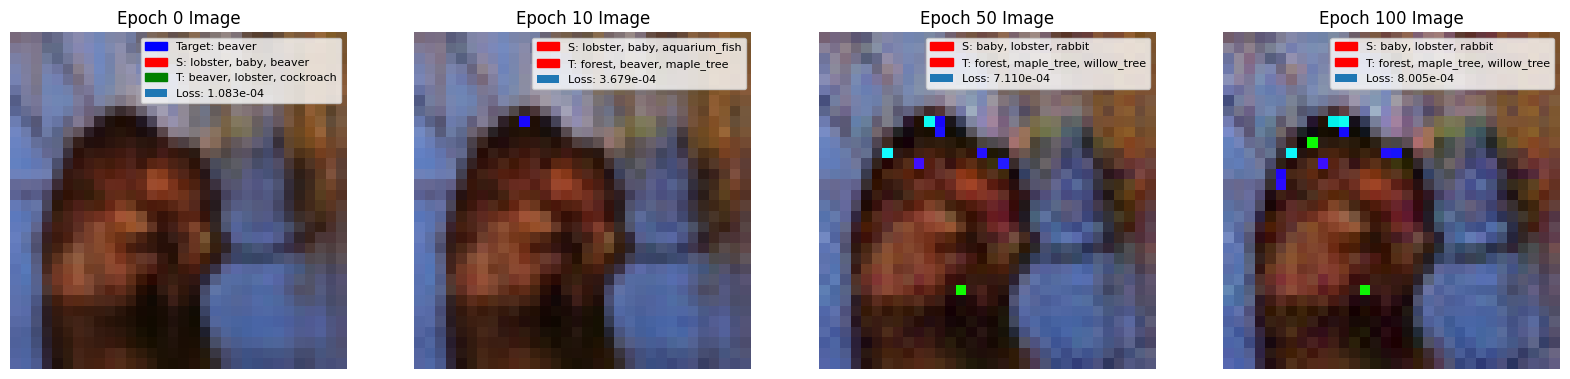

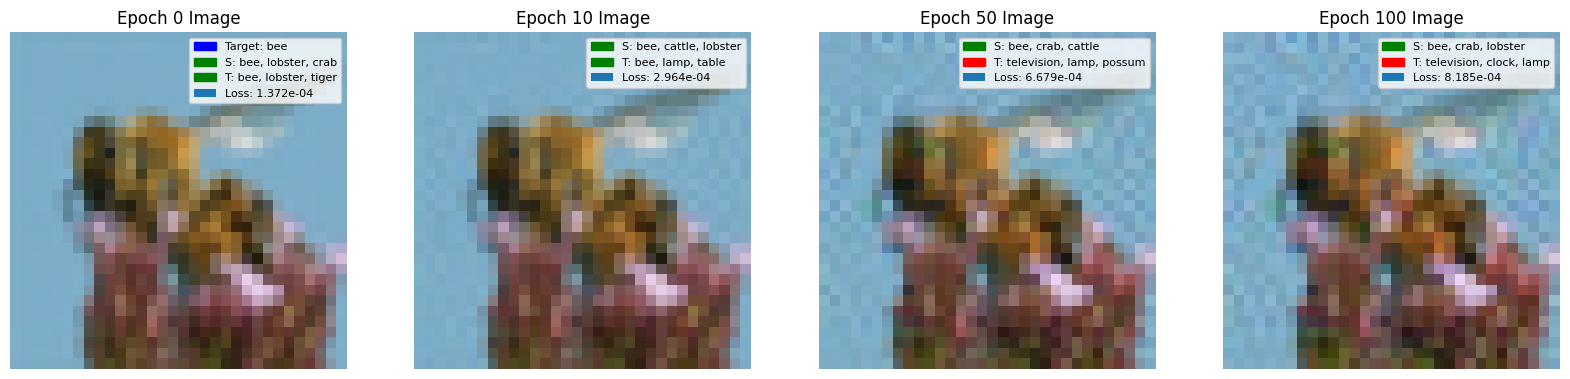

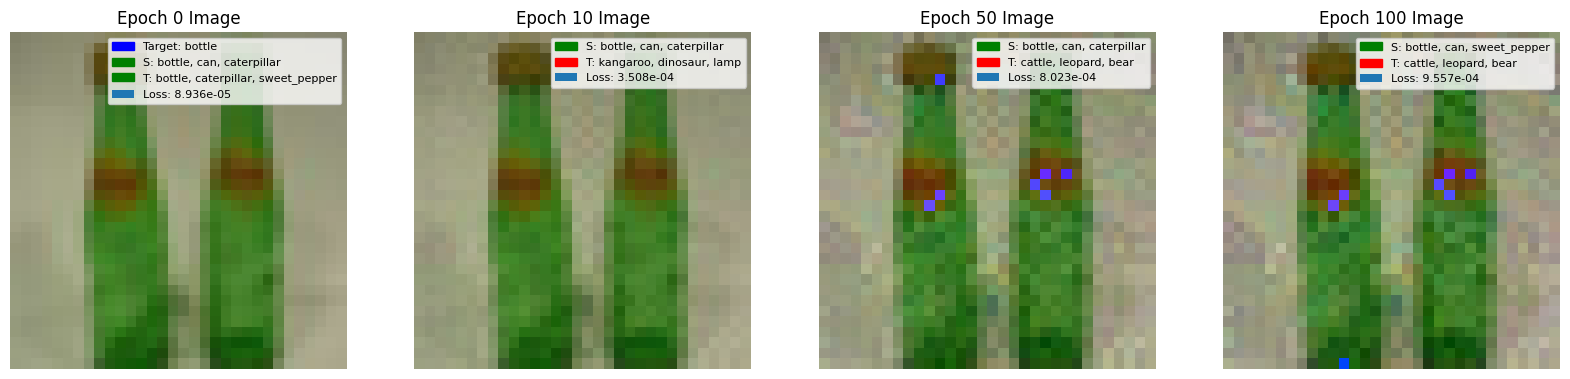

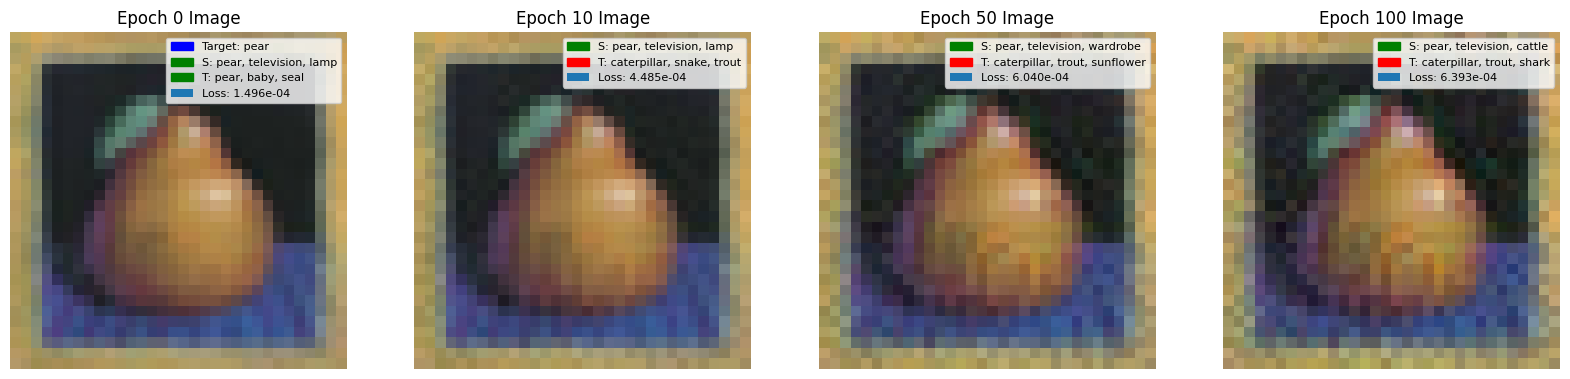

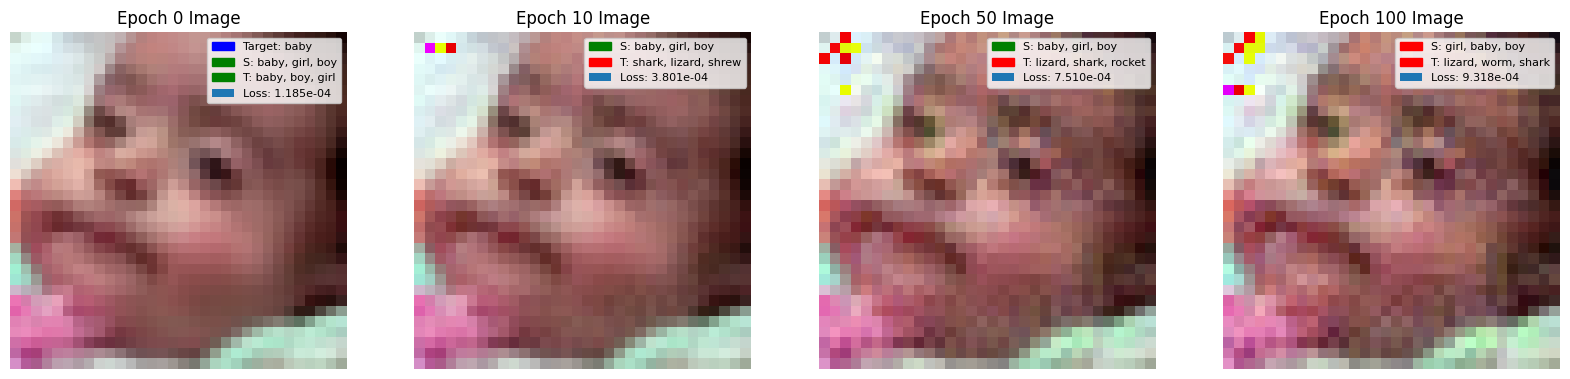

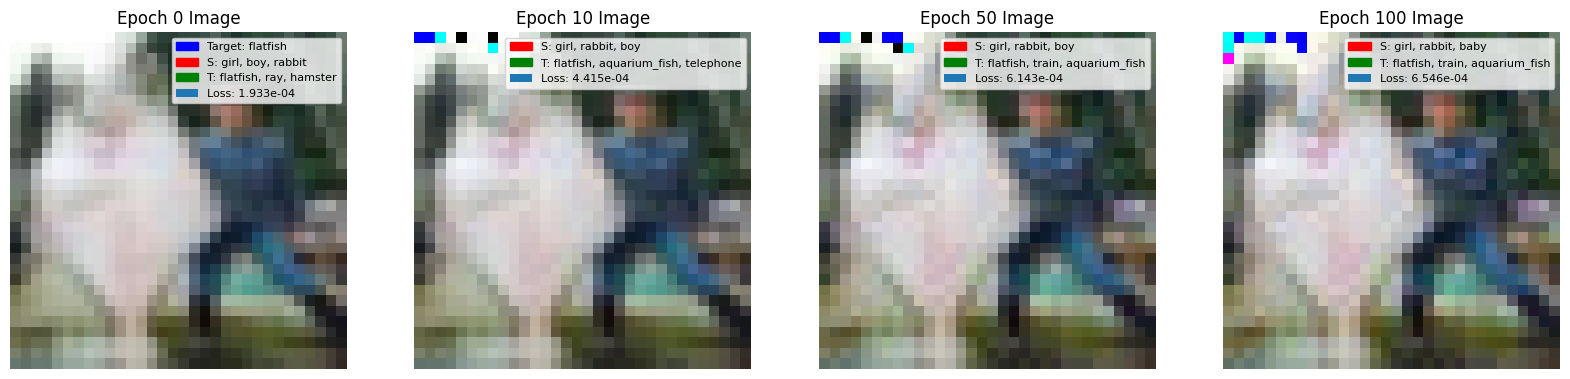

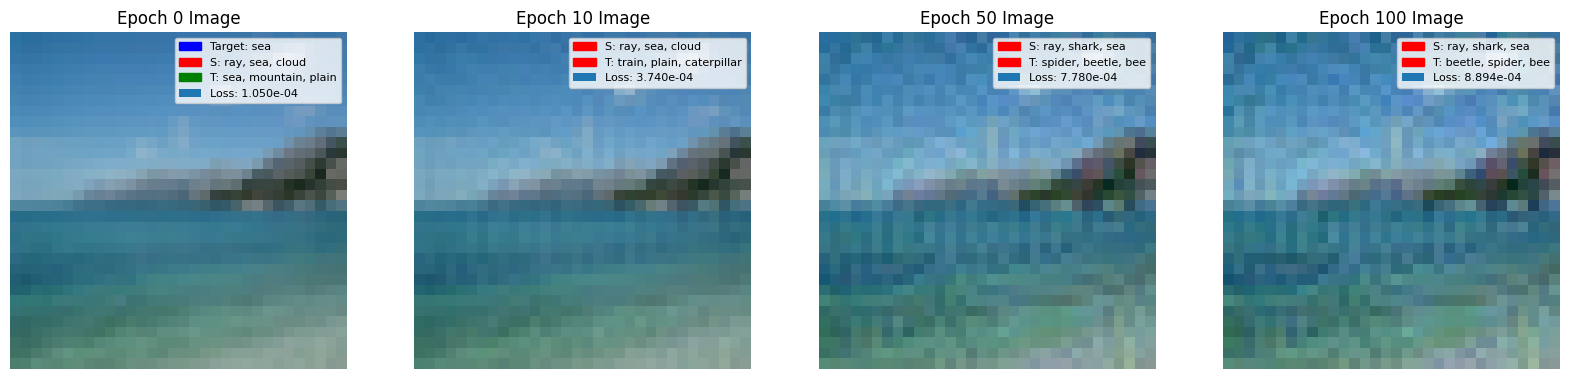

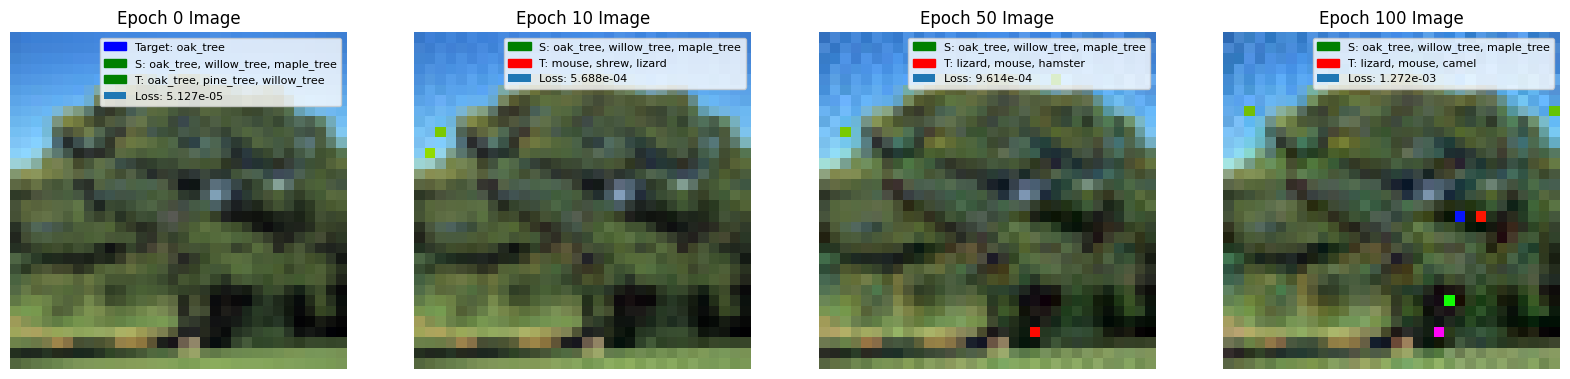

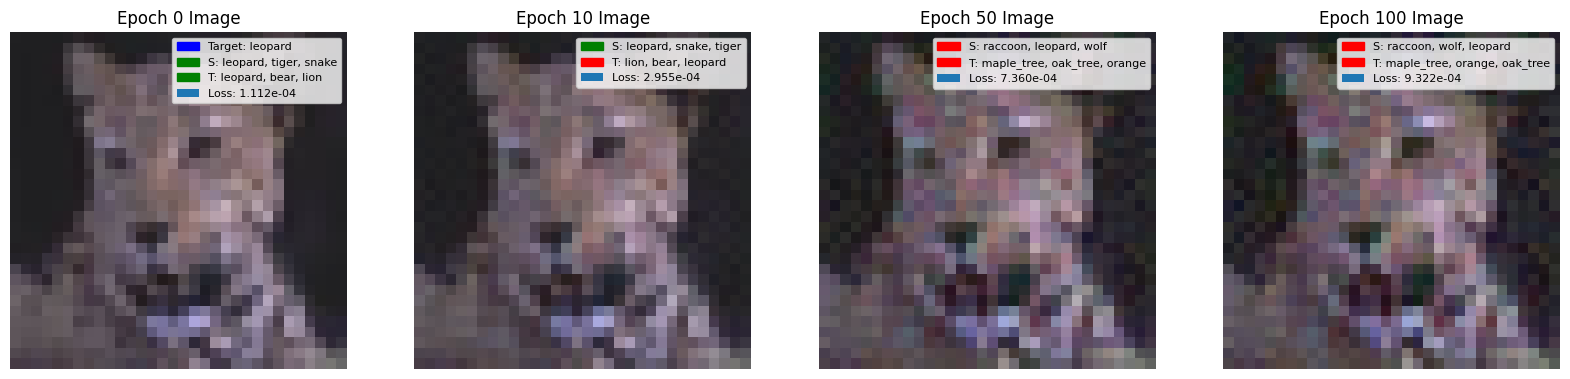

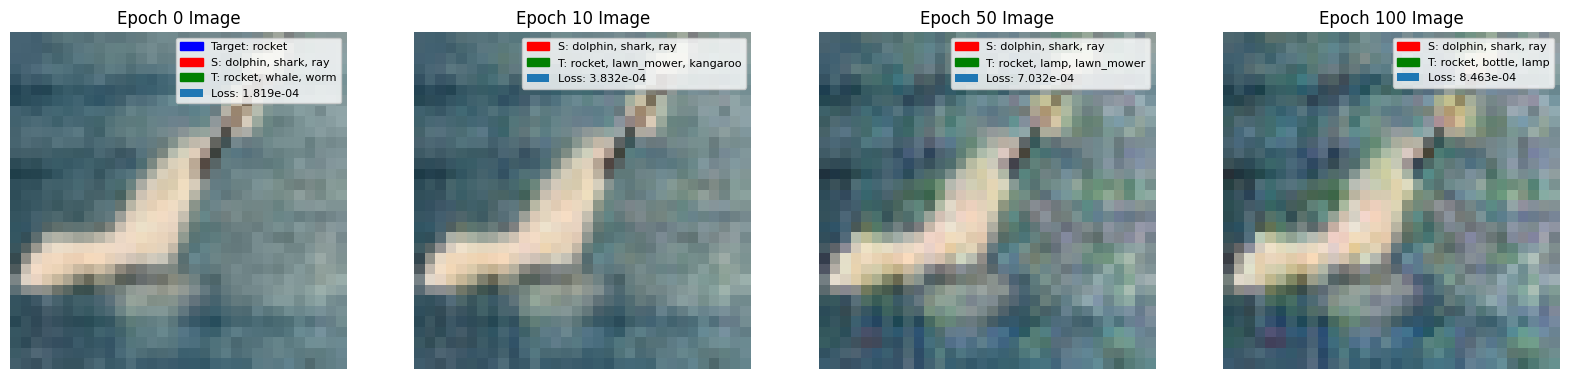

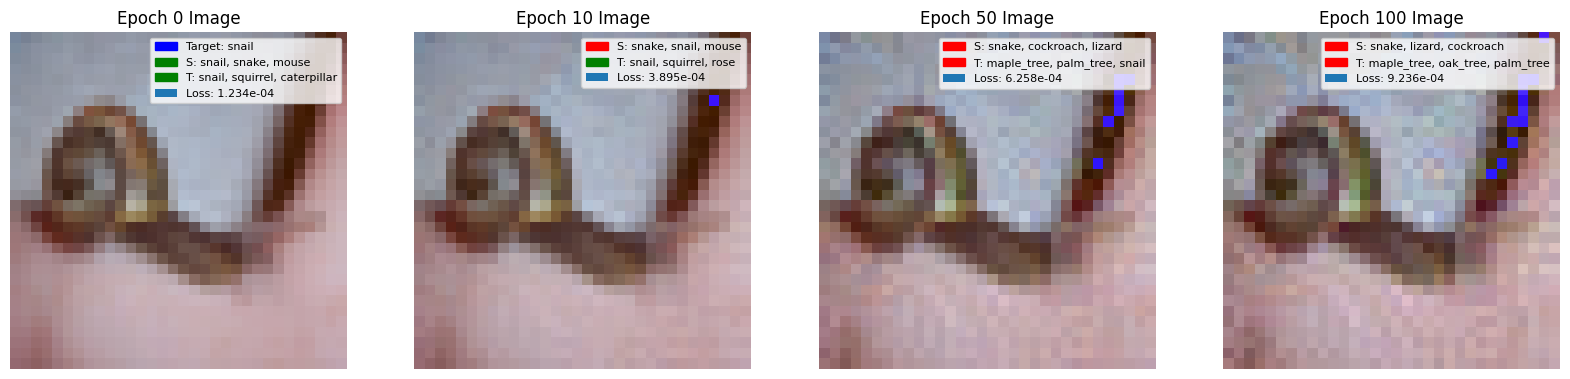

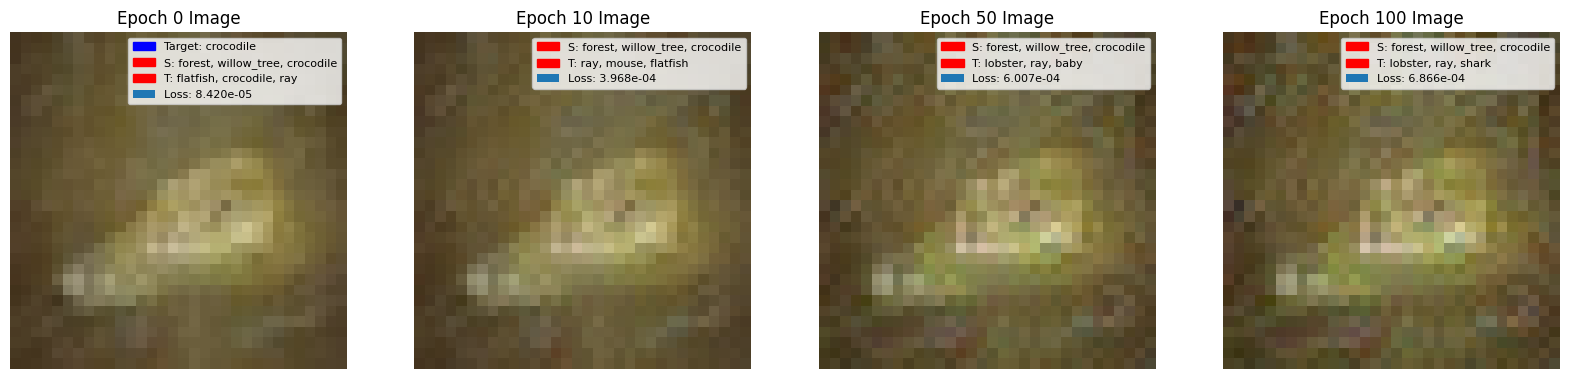

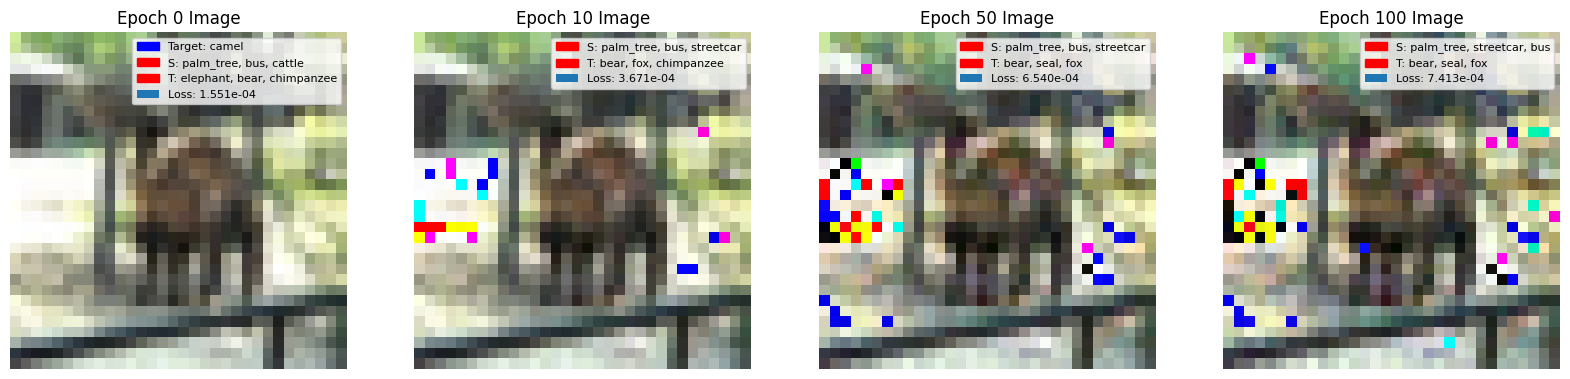

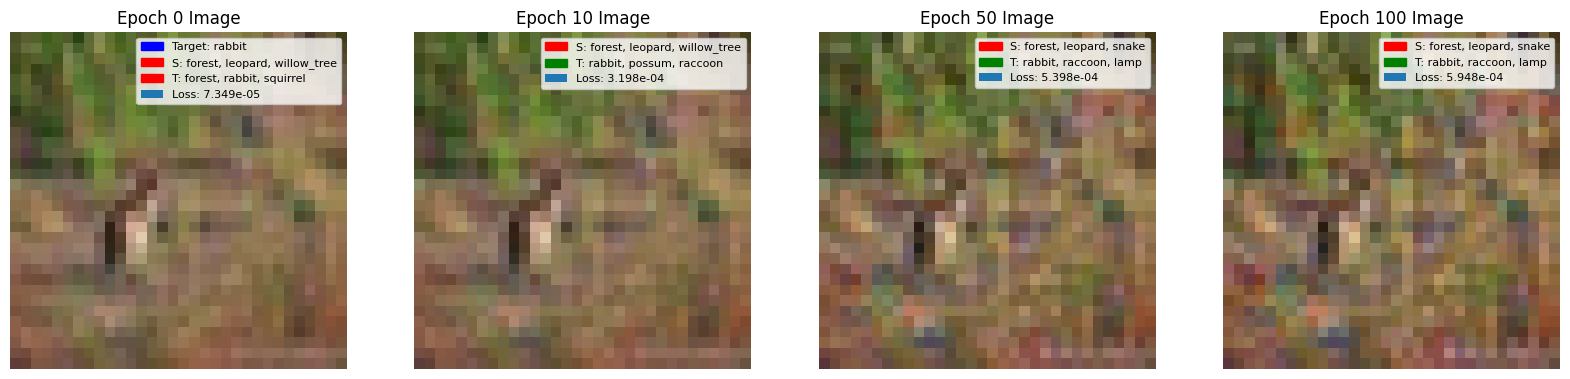

In [22]:
for image, target in val_loader:
    print(image.shape)
    new_images = perturb_image(distiller, image, target, epochs=[0, 10, 50, 100])
    break

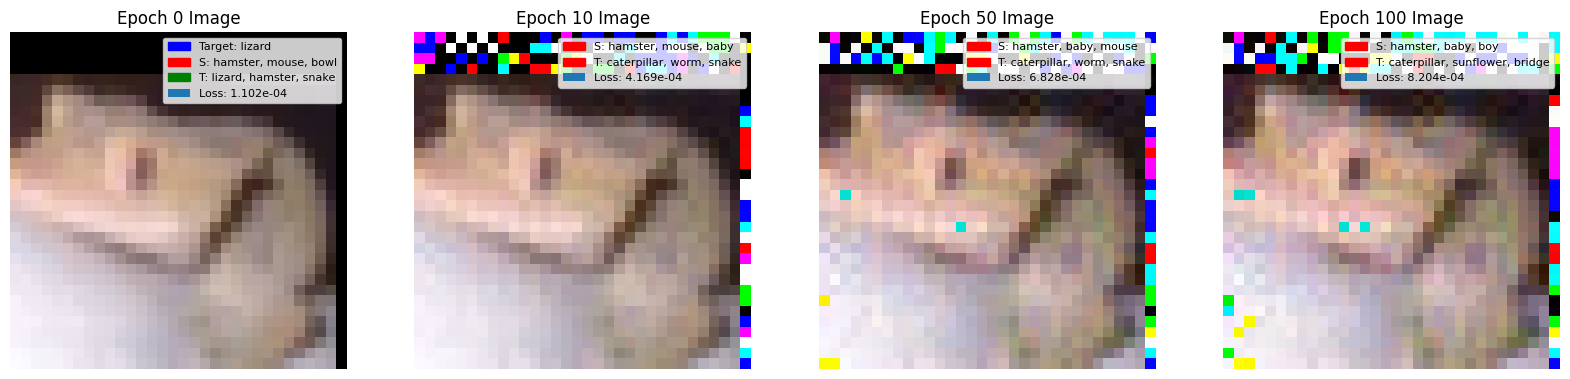

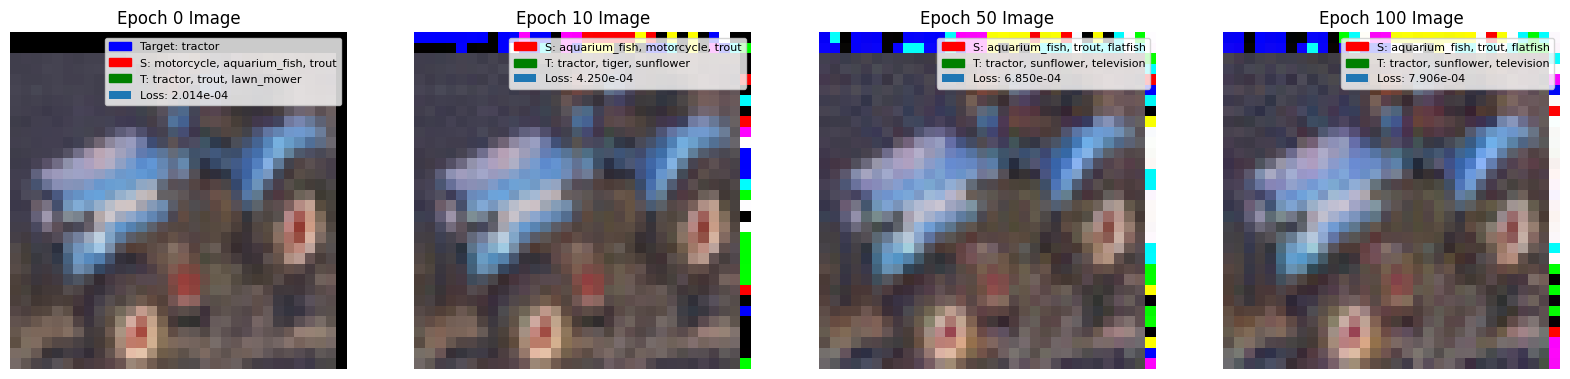

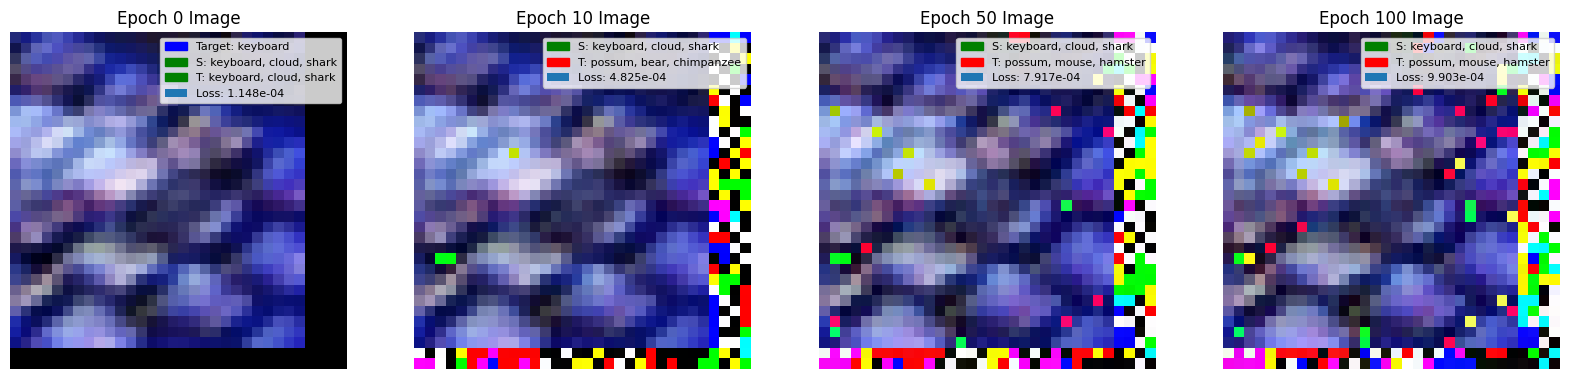

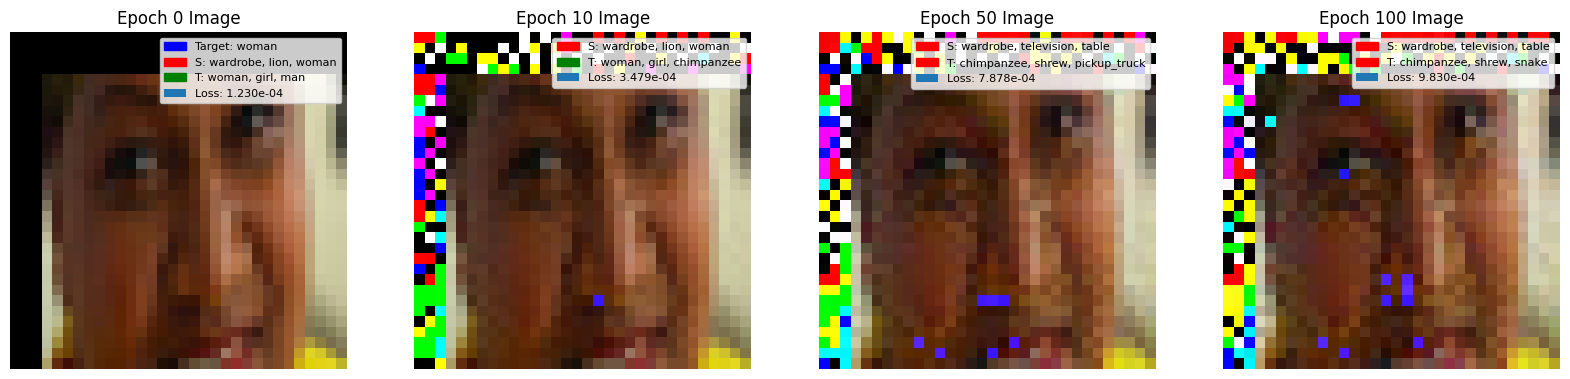

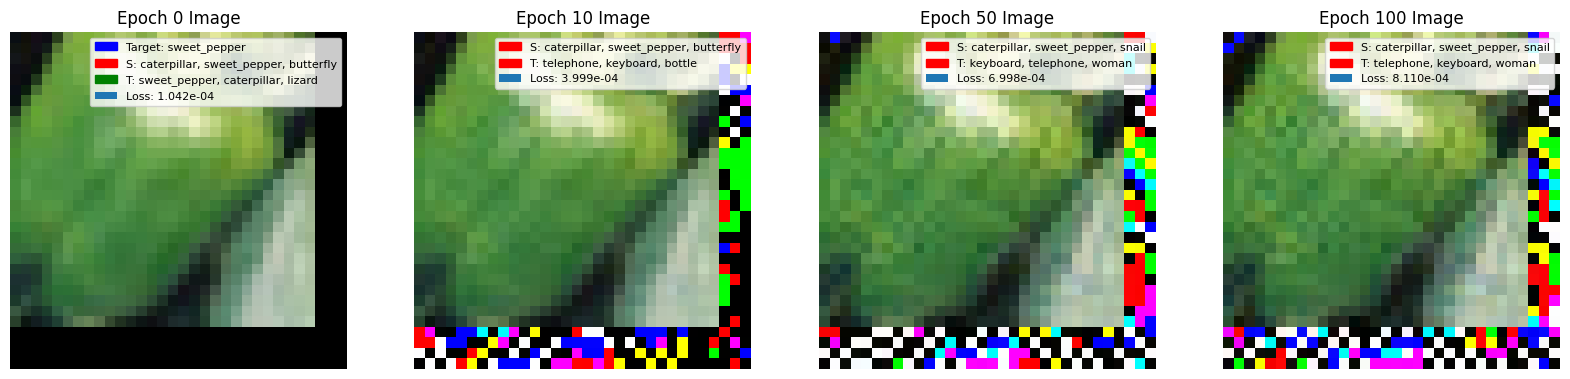

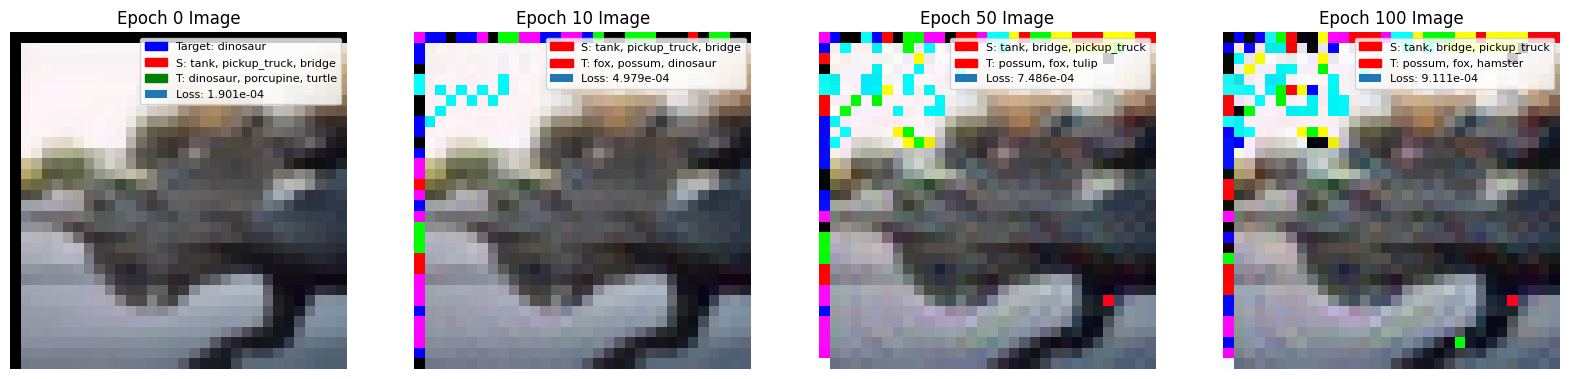

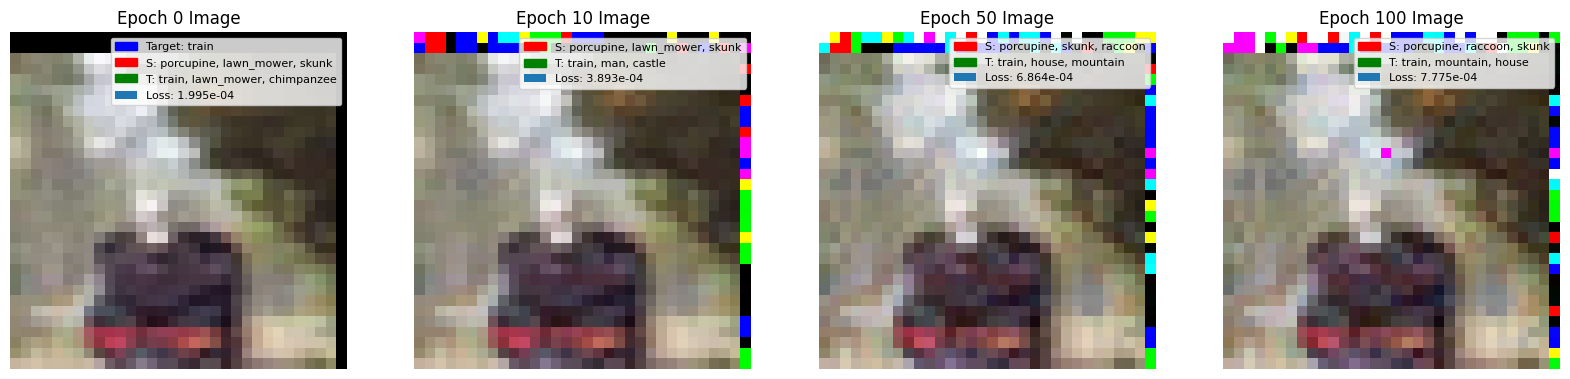

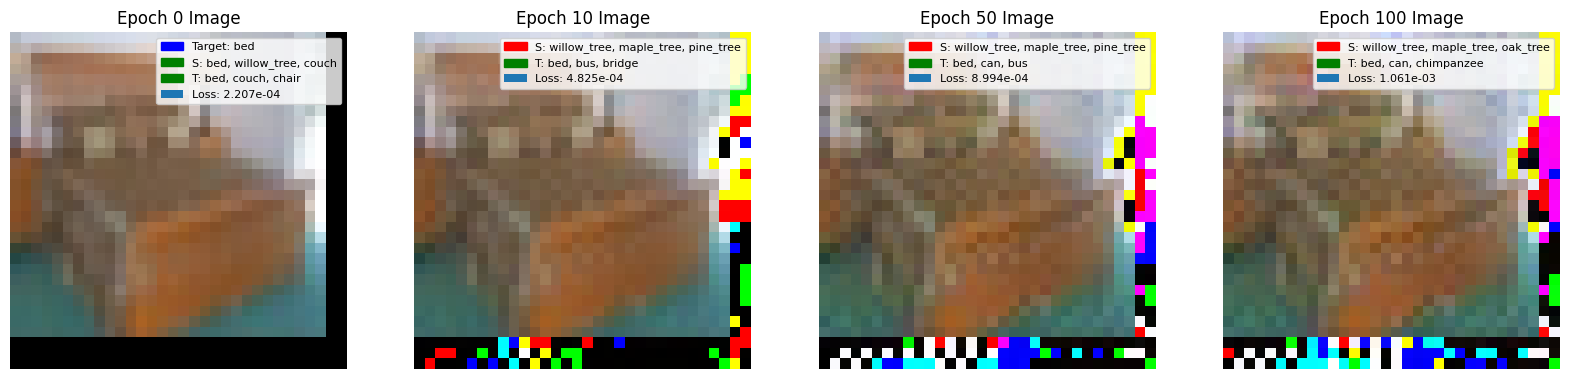

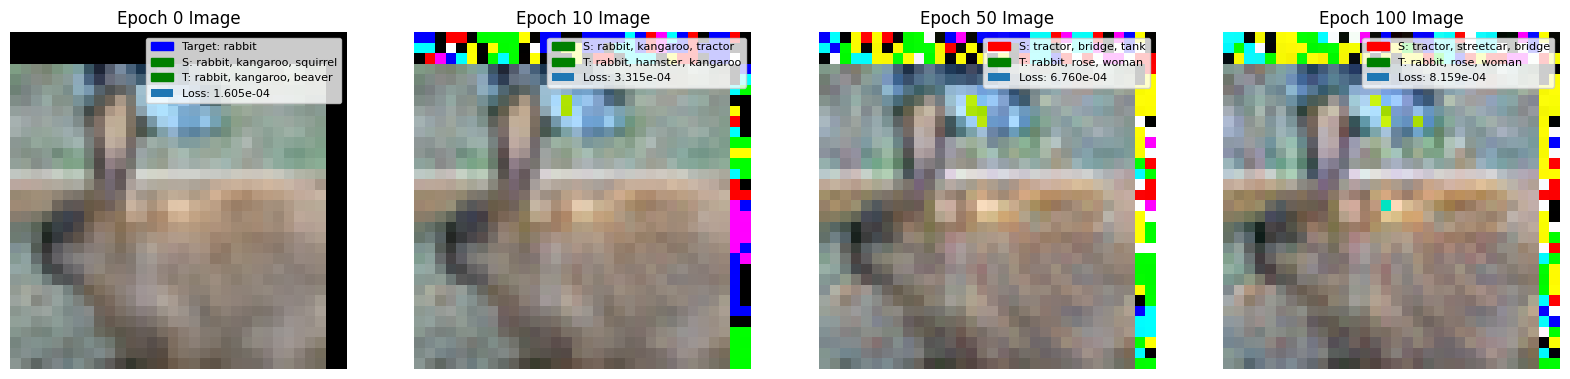

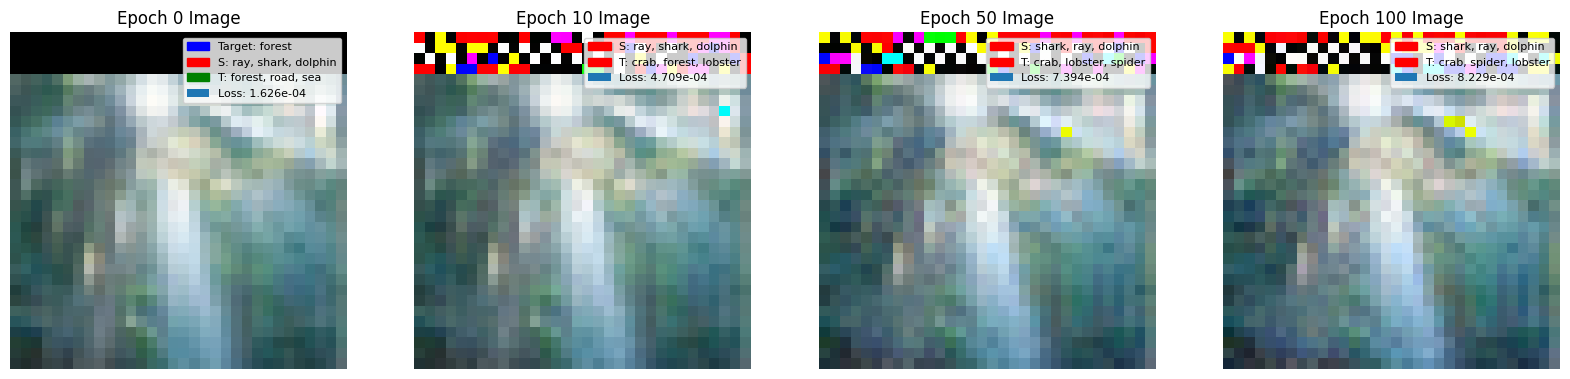

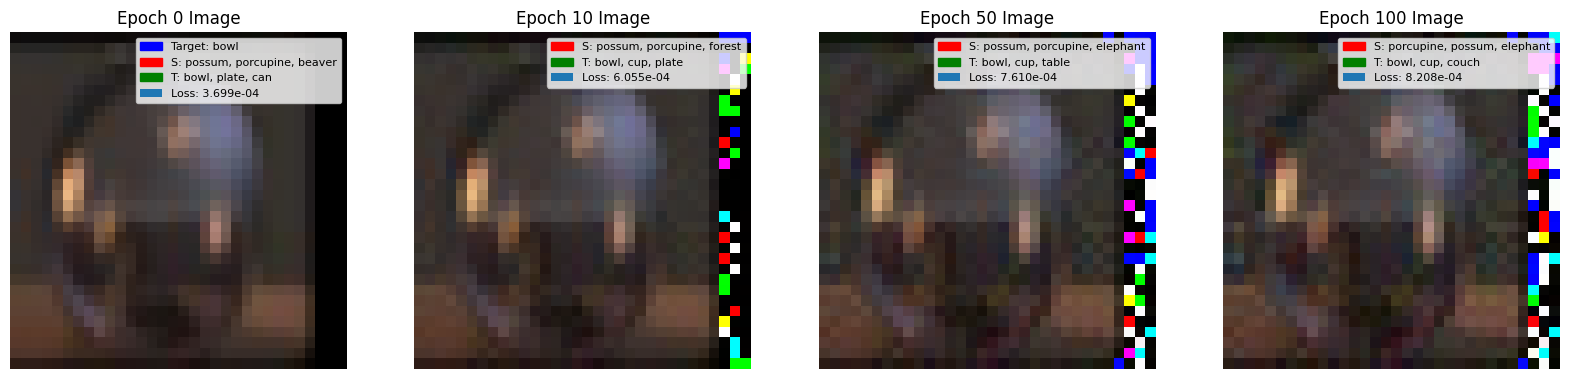

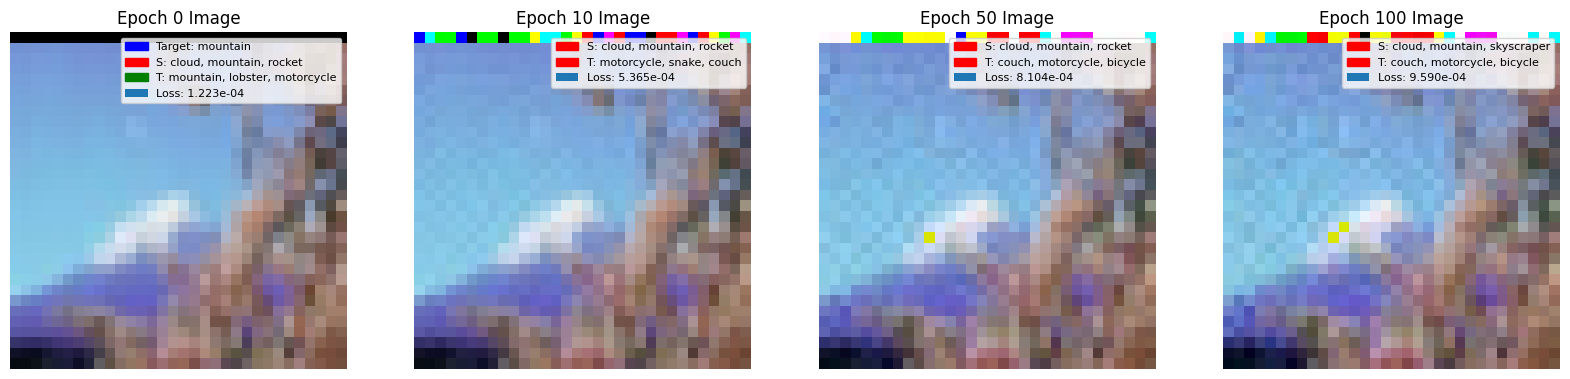

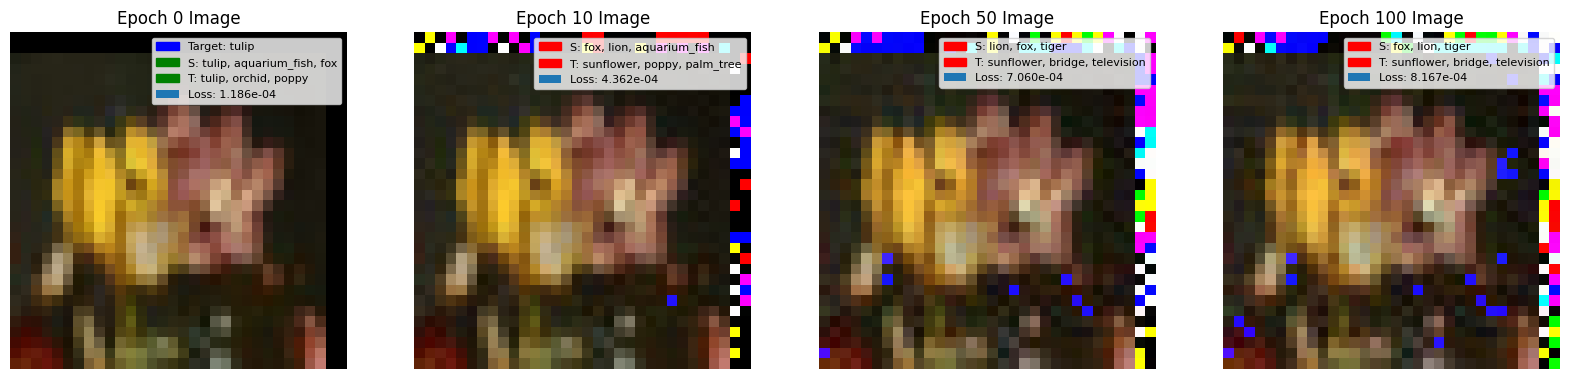

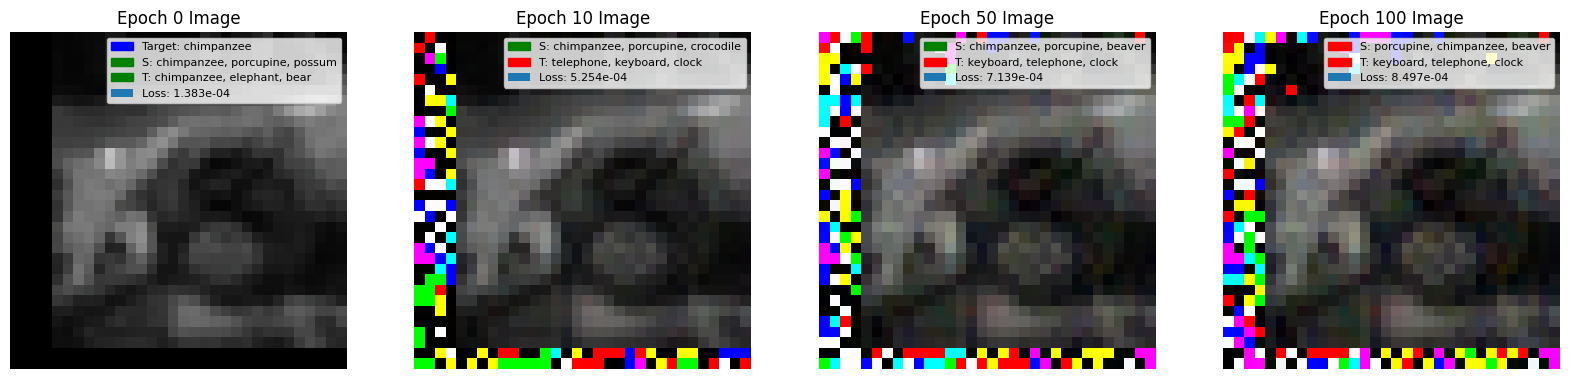

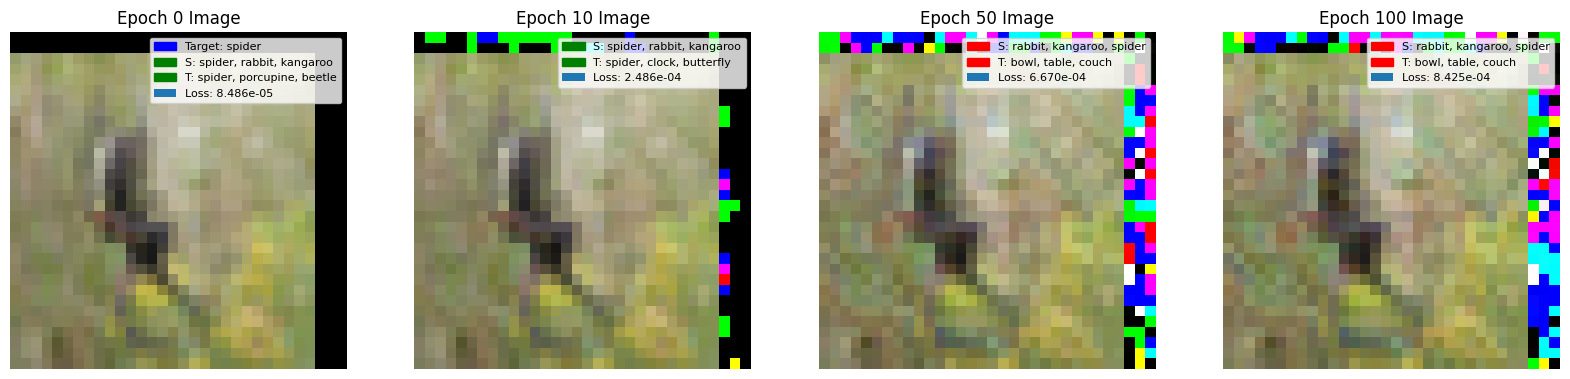

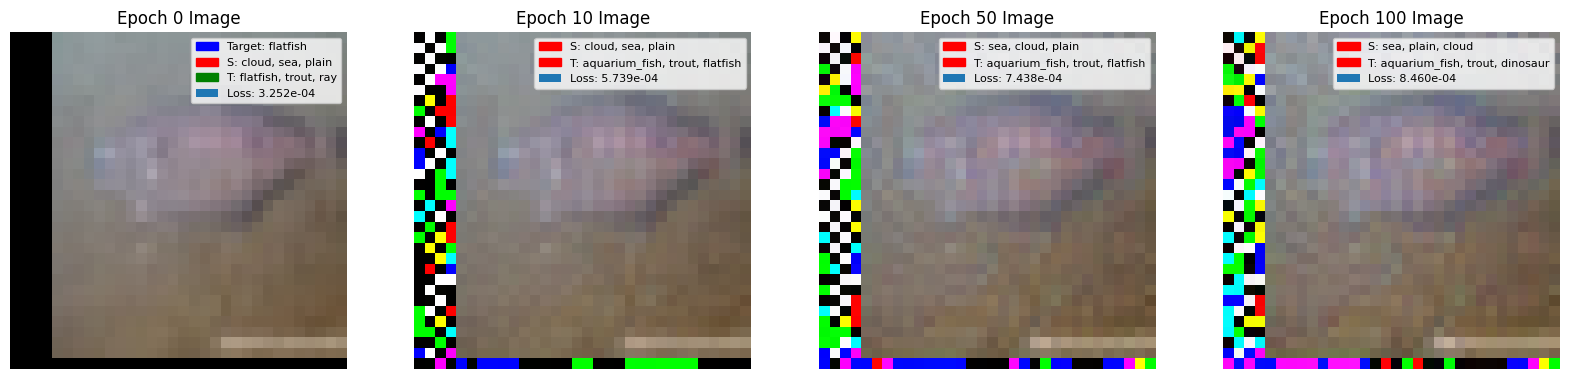

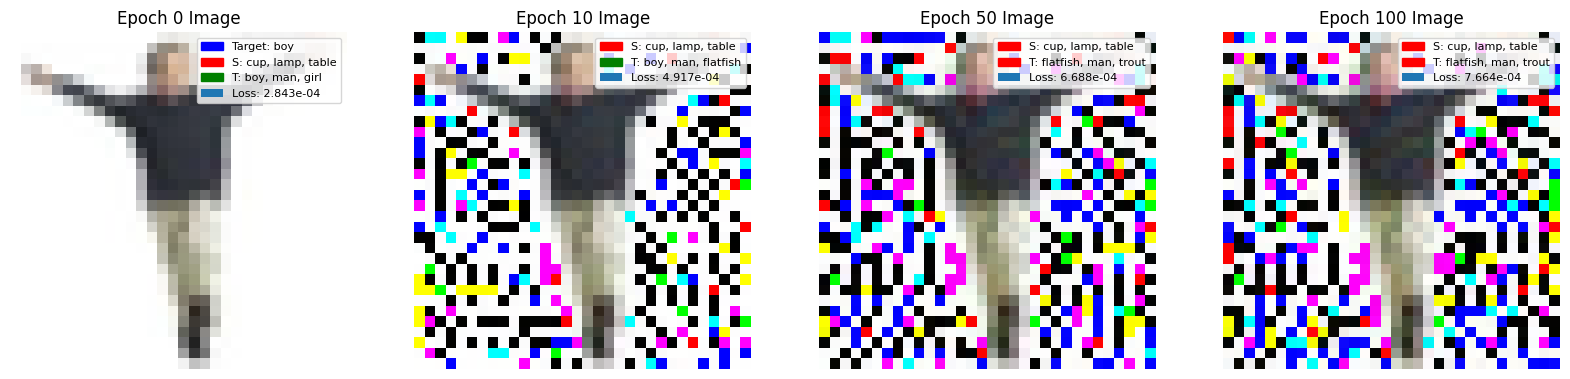

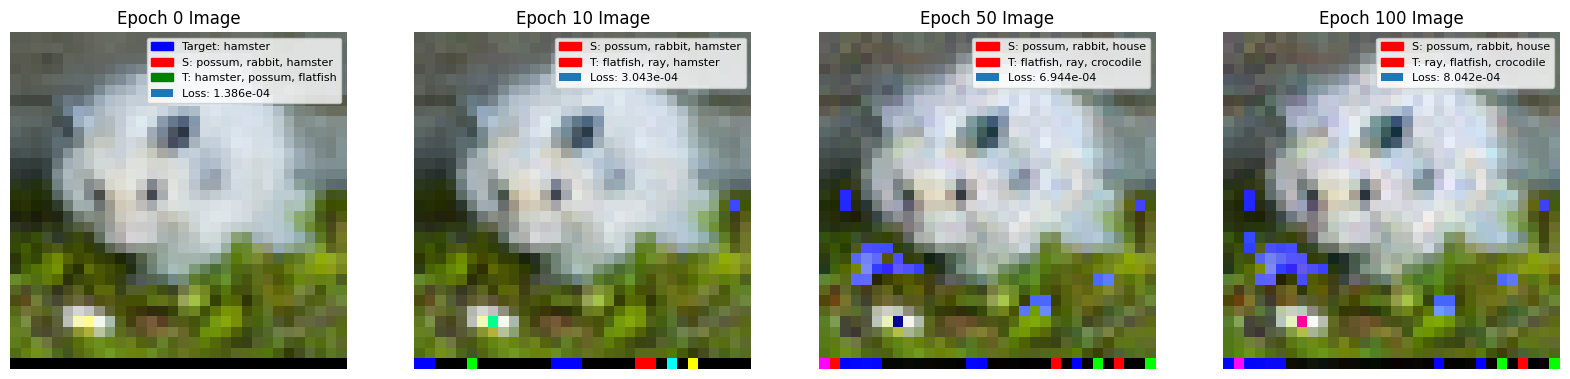

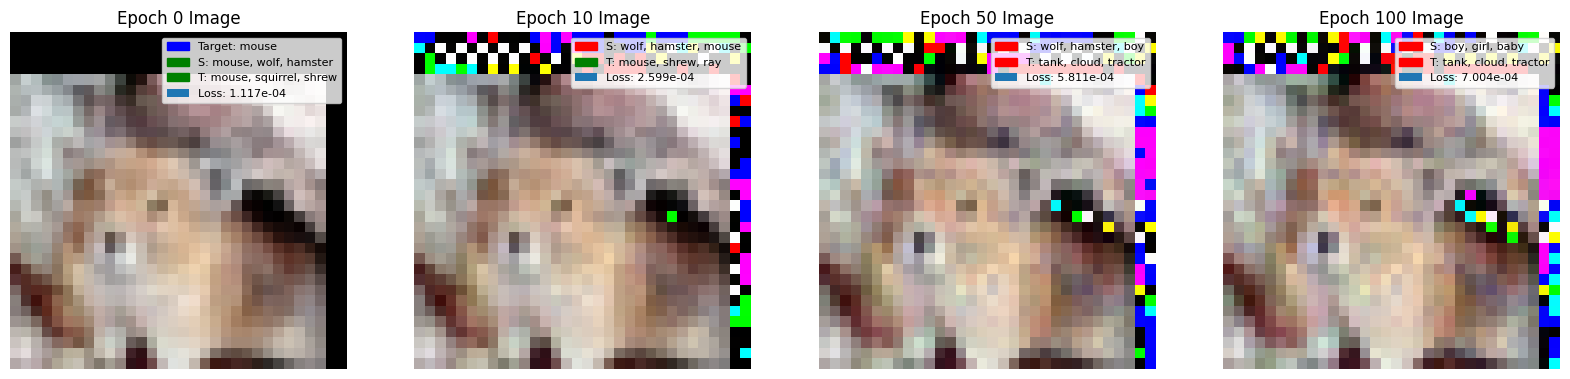

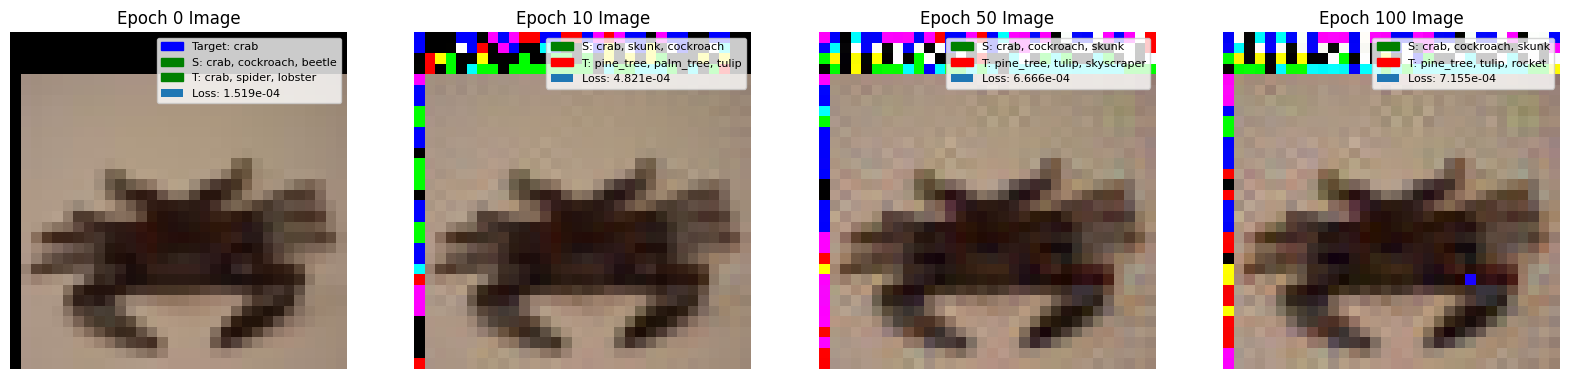

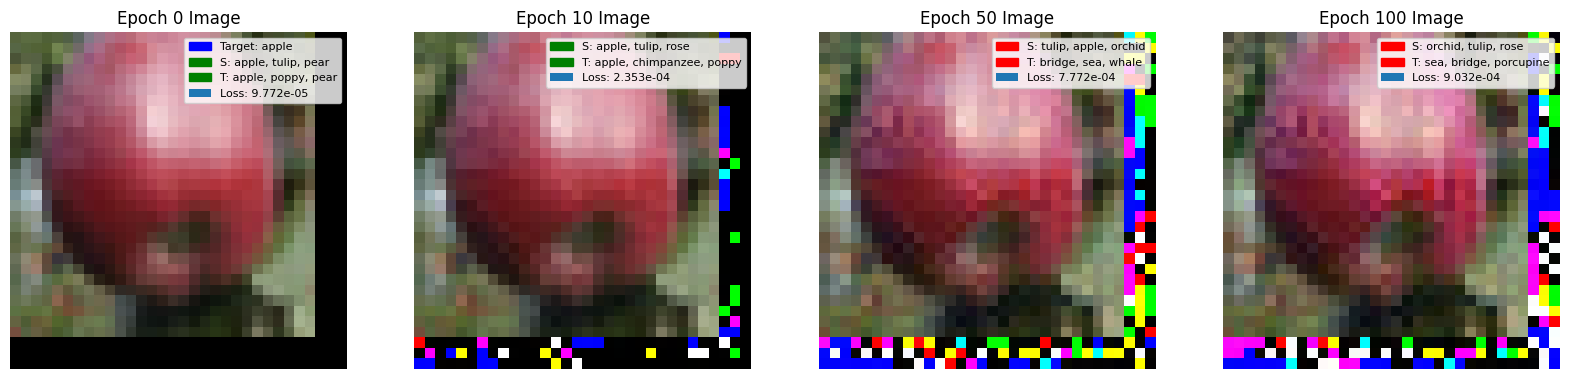

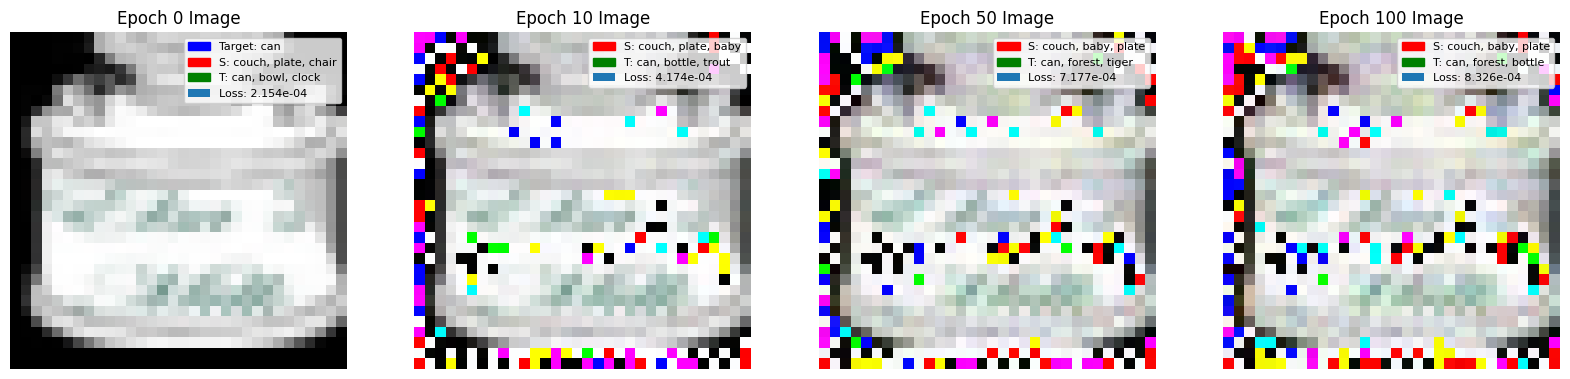

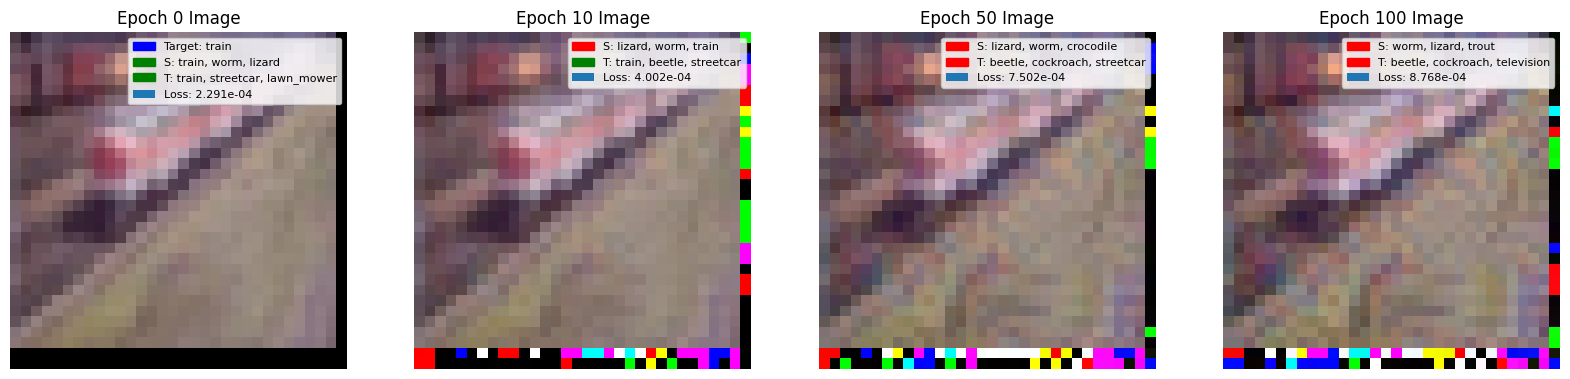

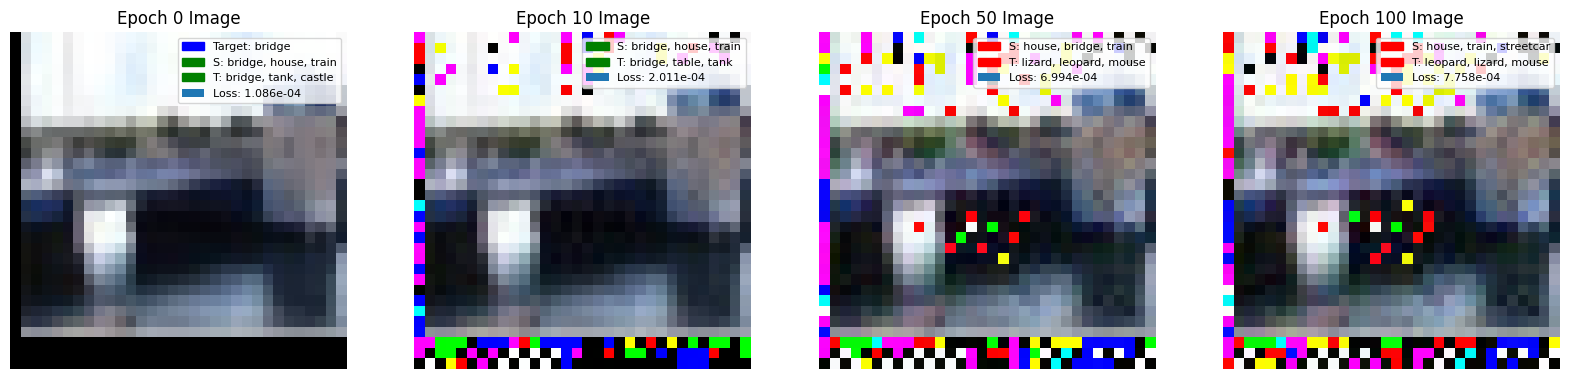

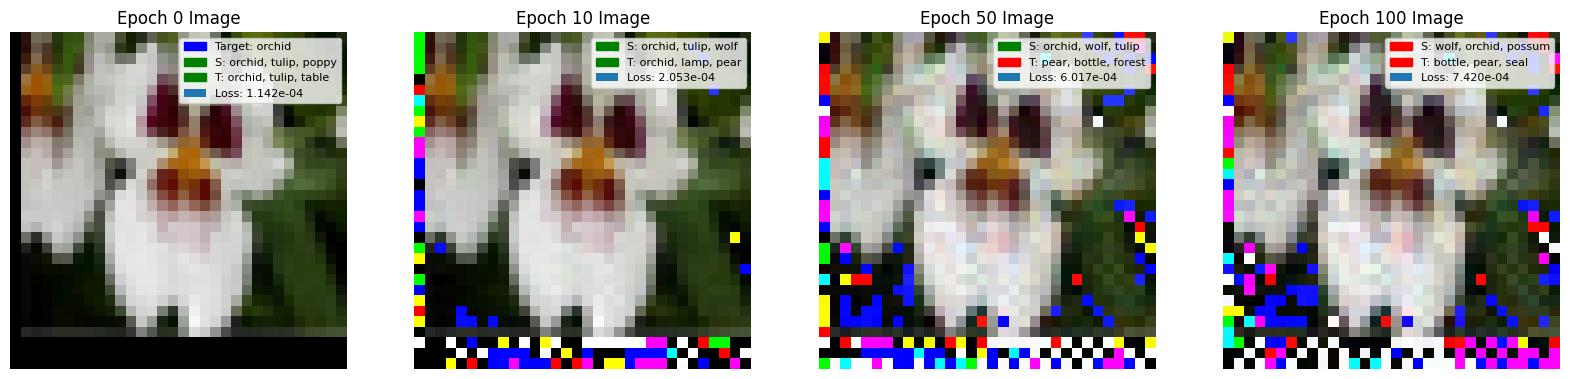

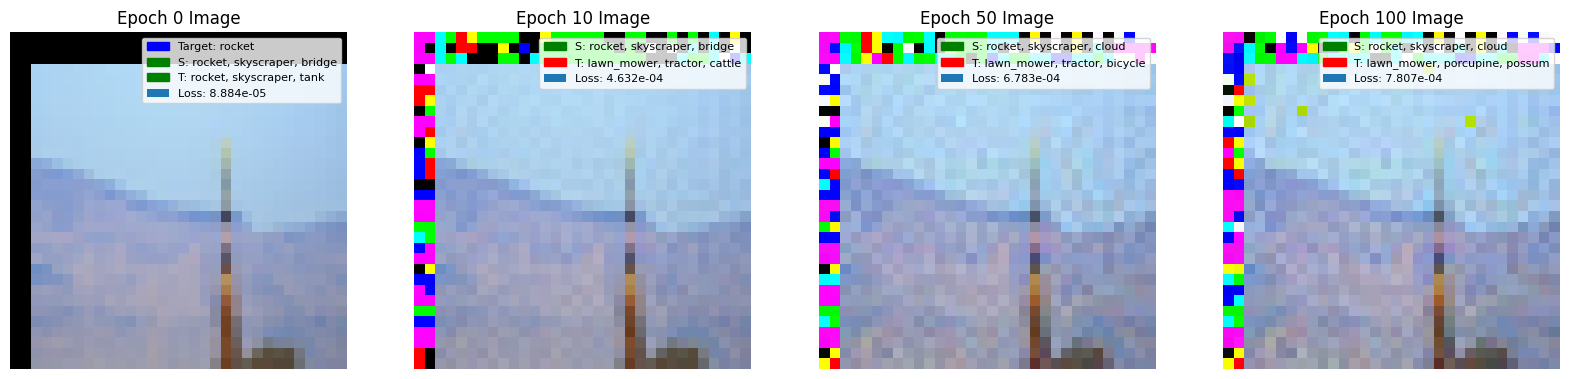

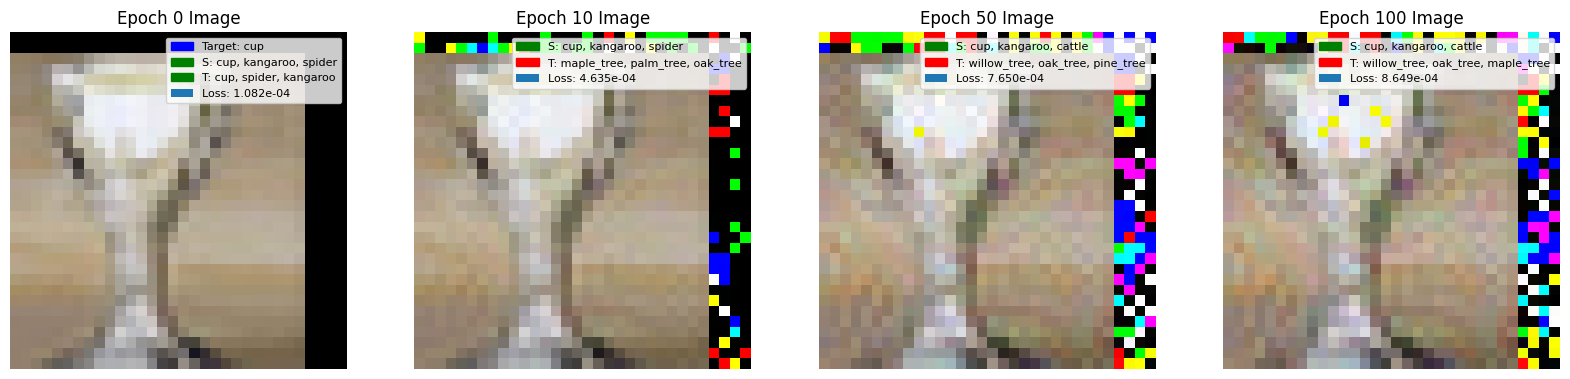

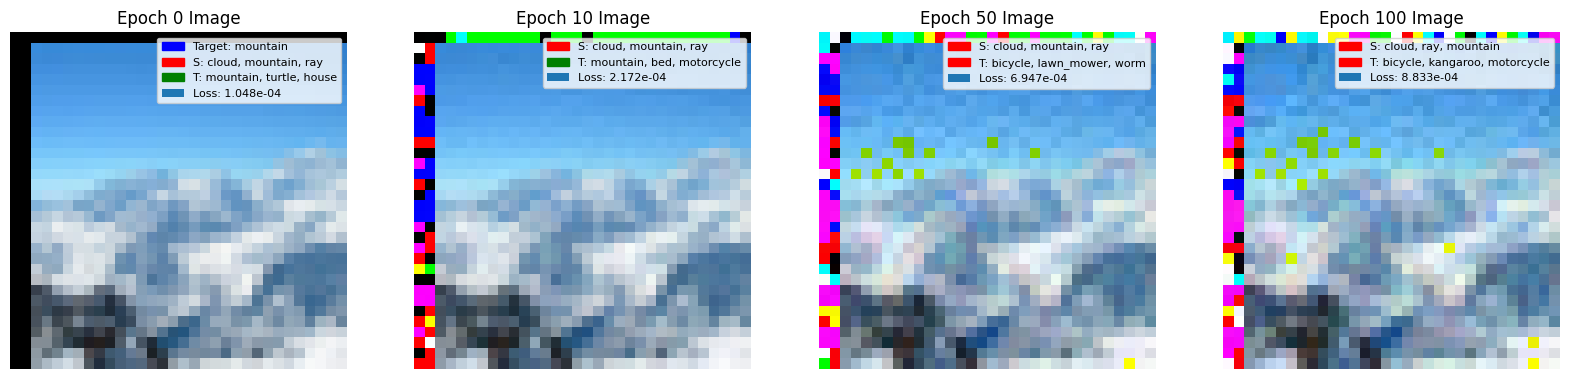

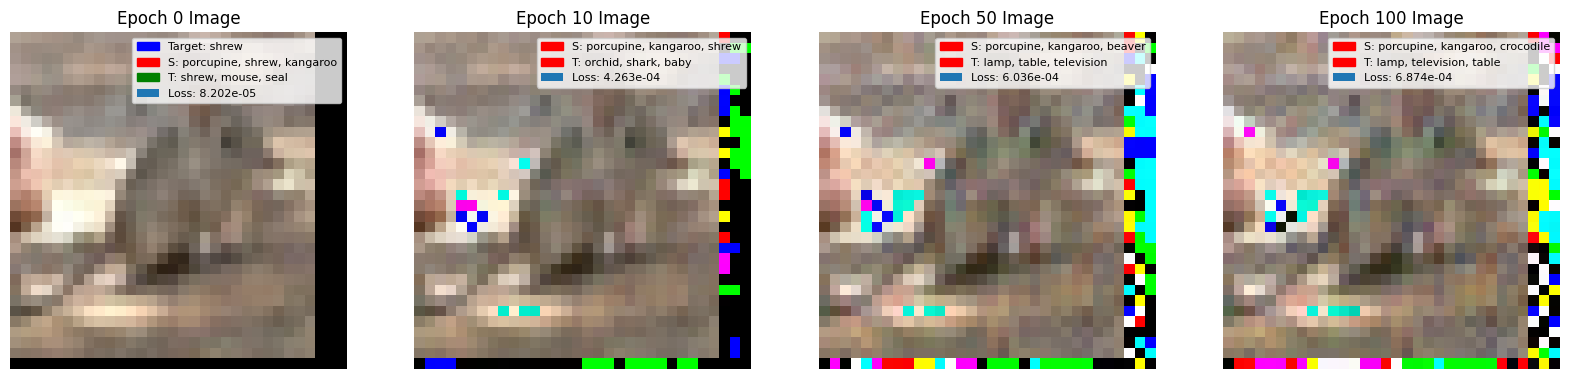

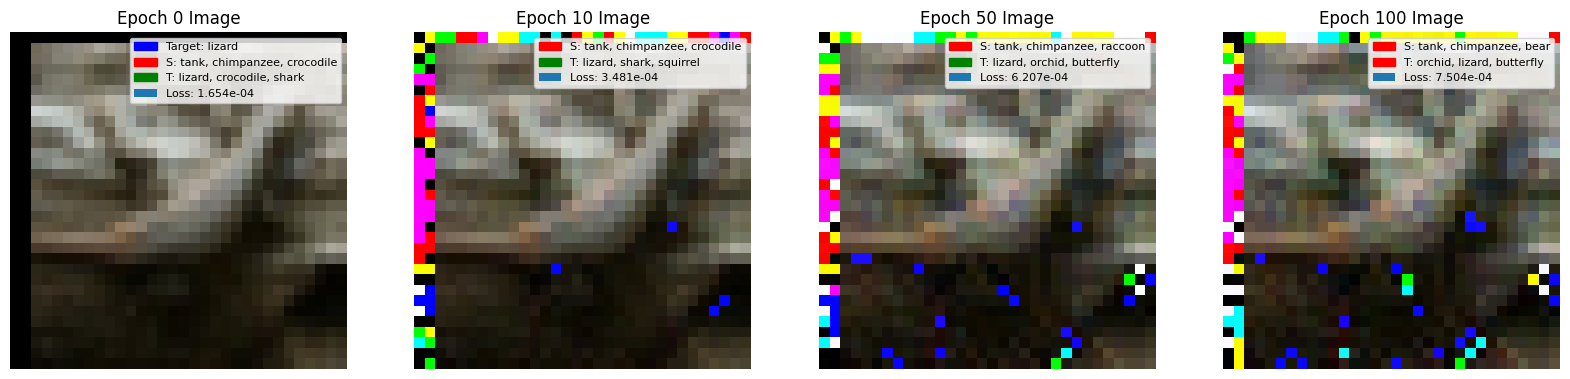

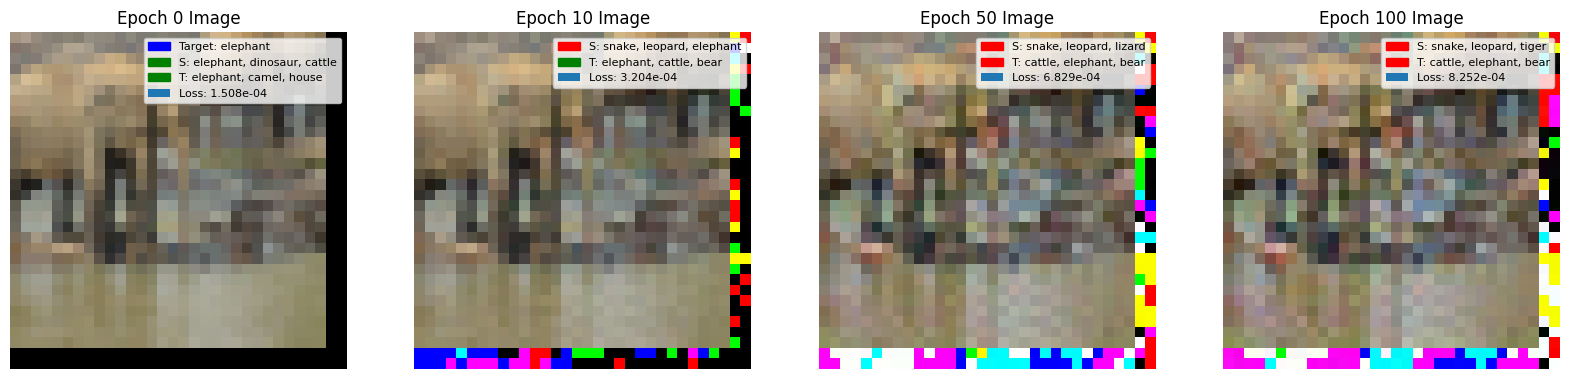

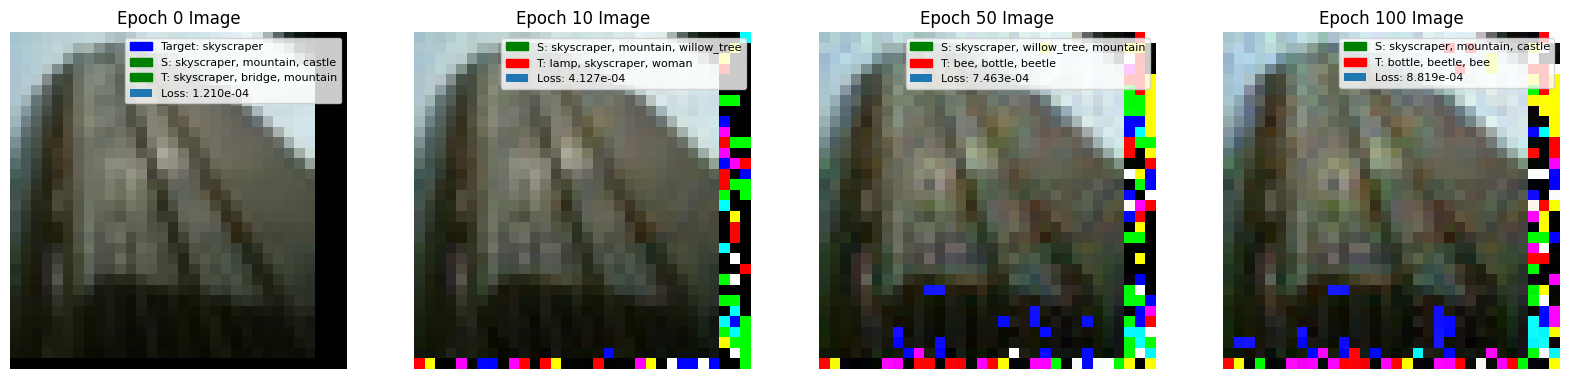

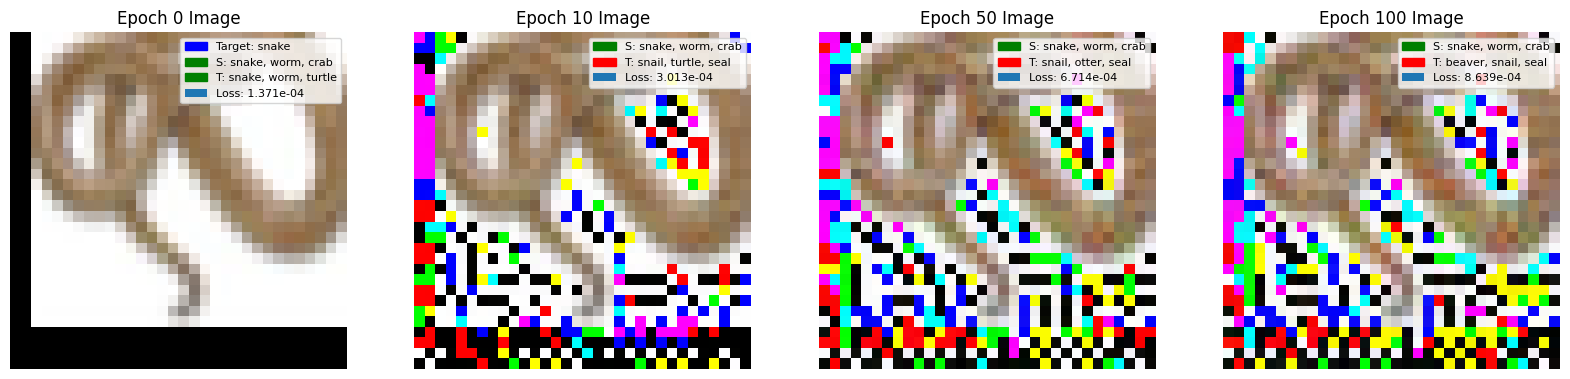

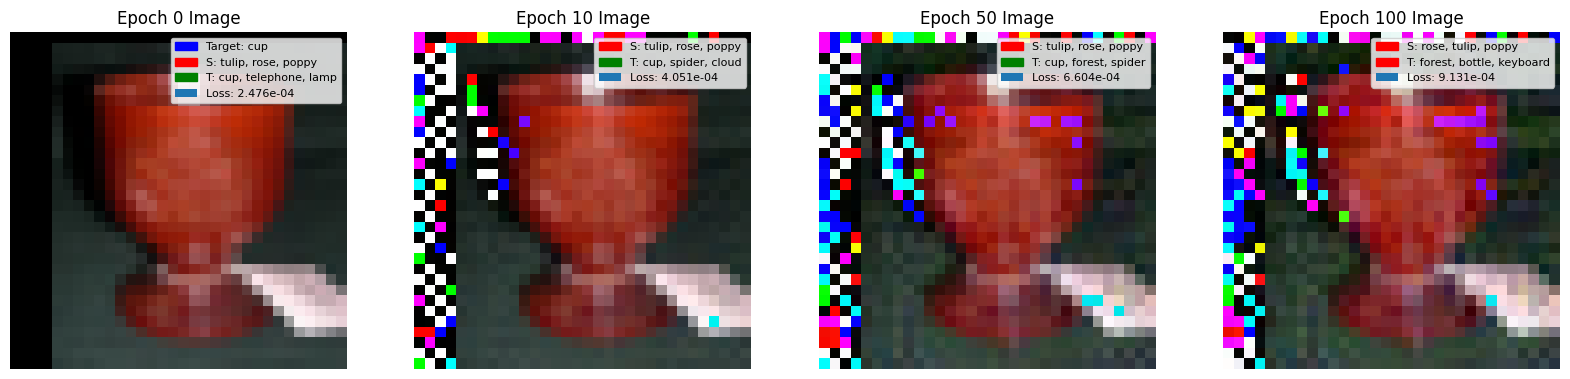

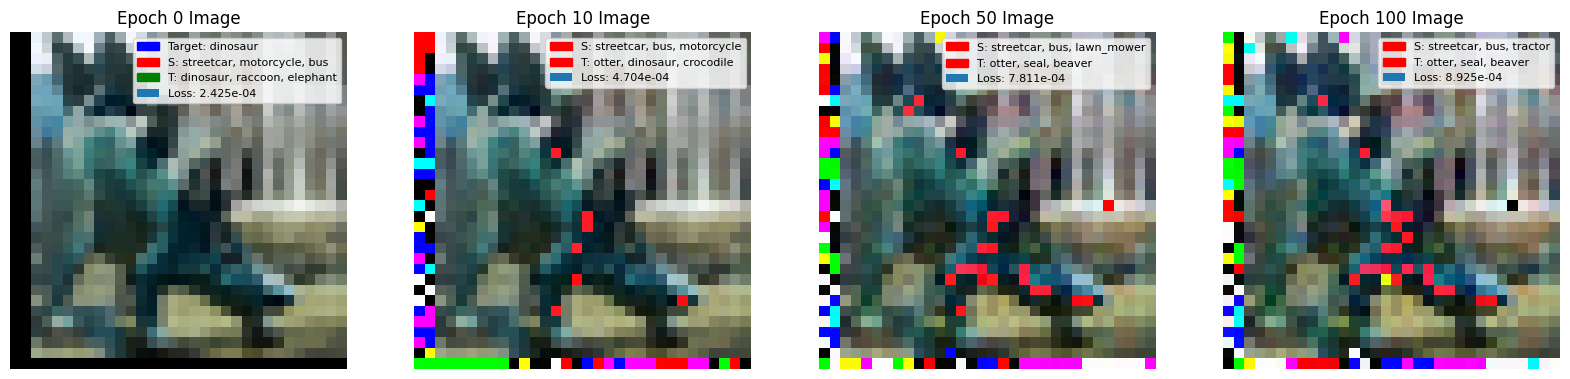

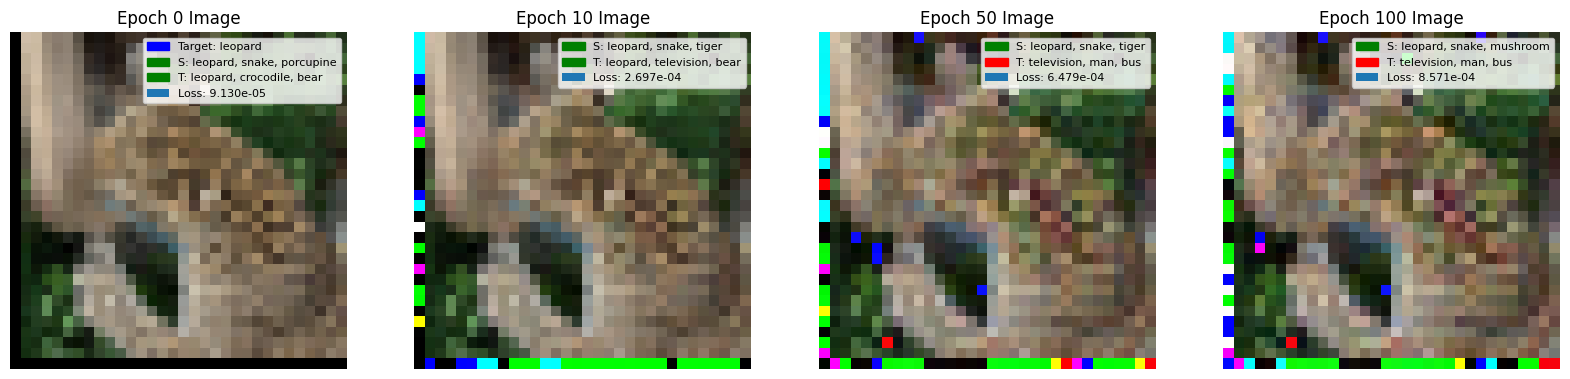

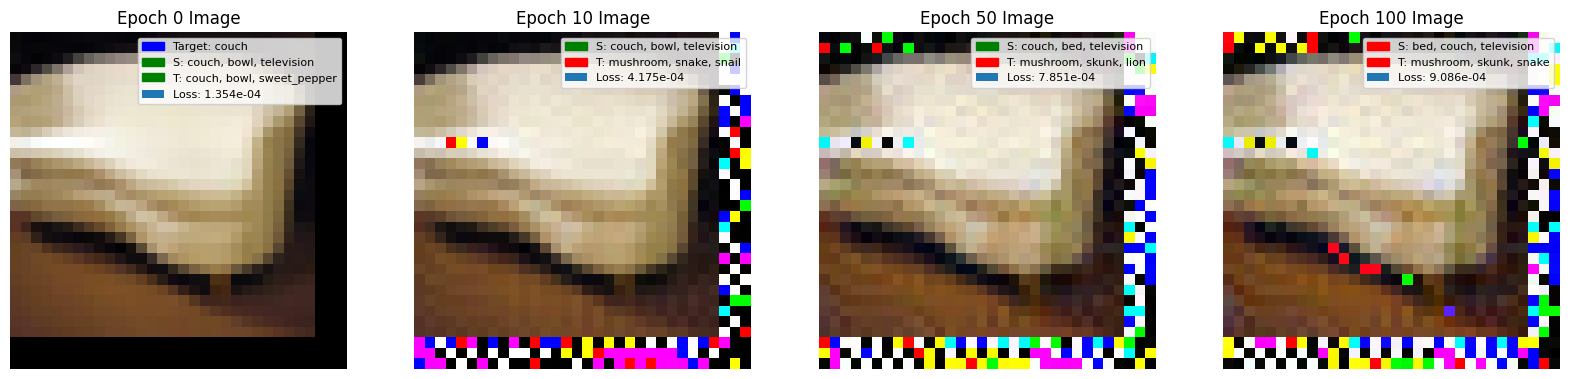

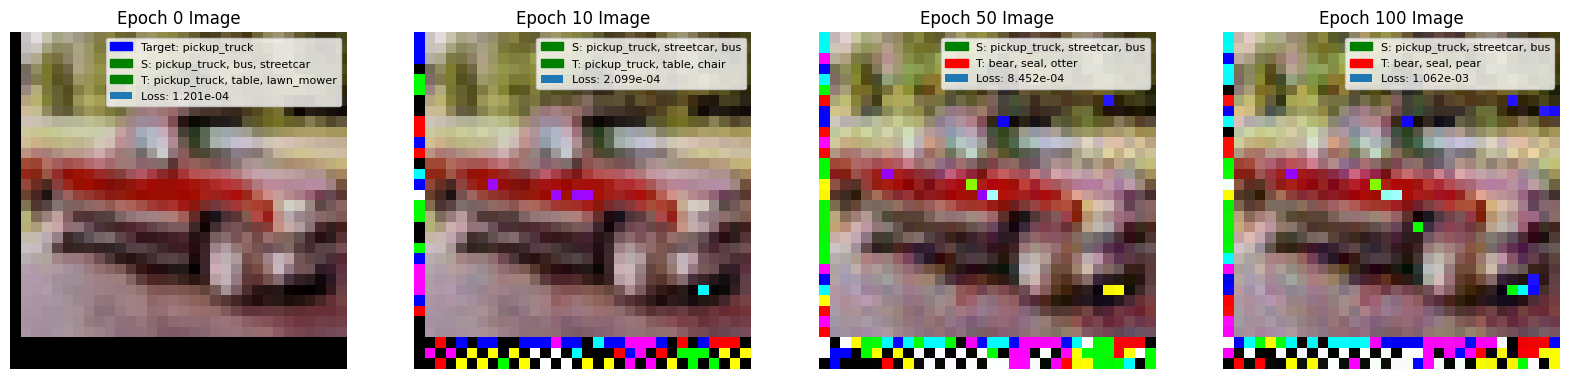

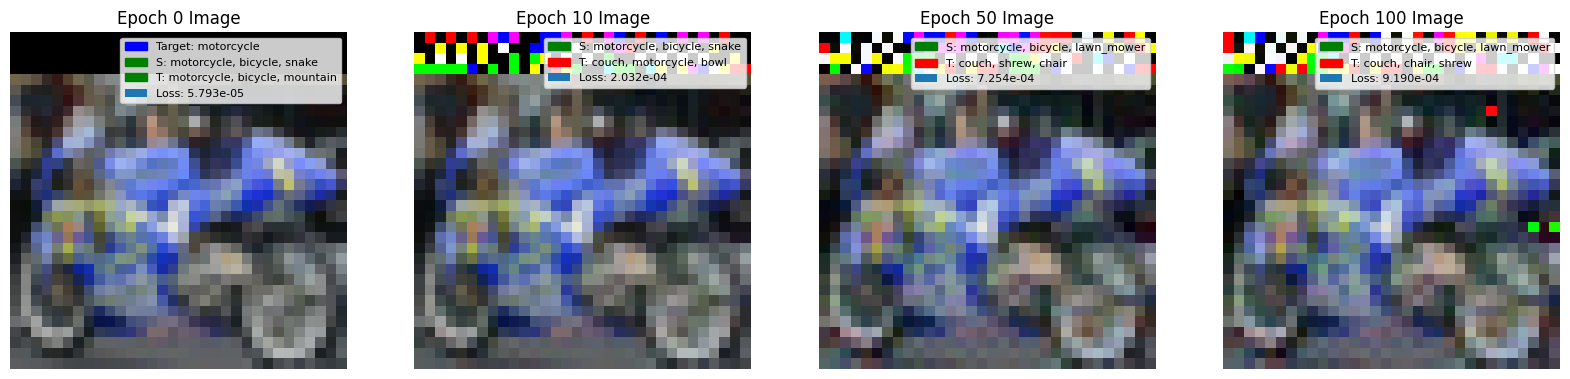

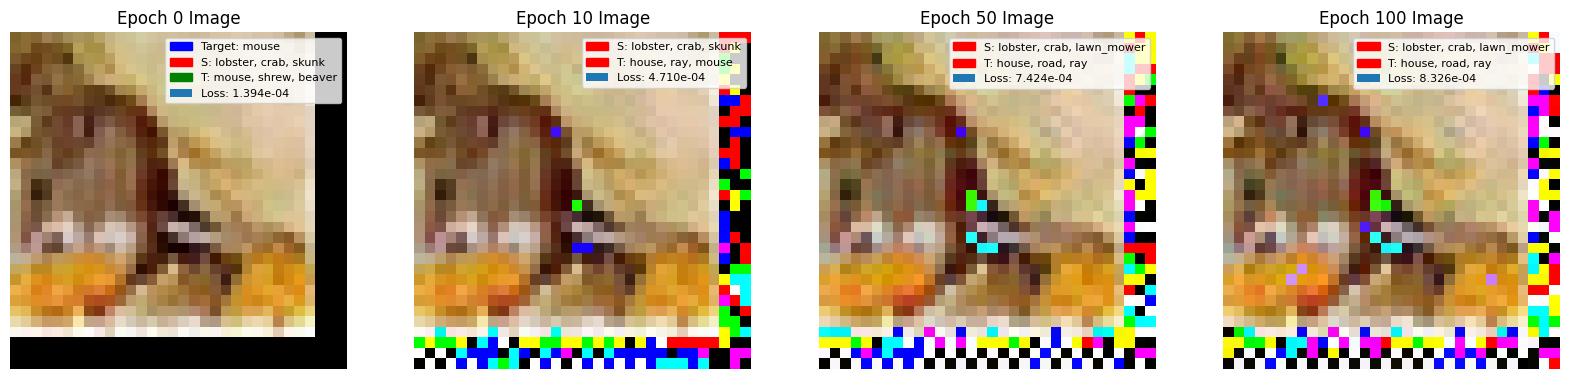

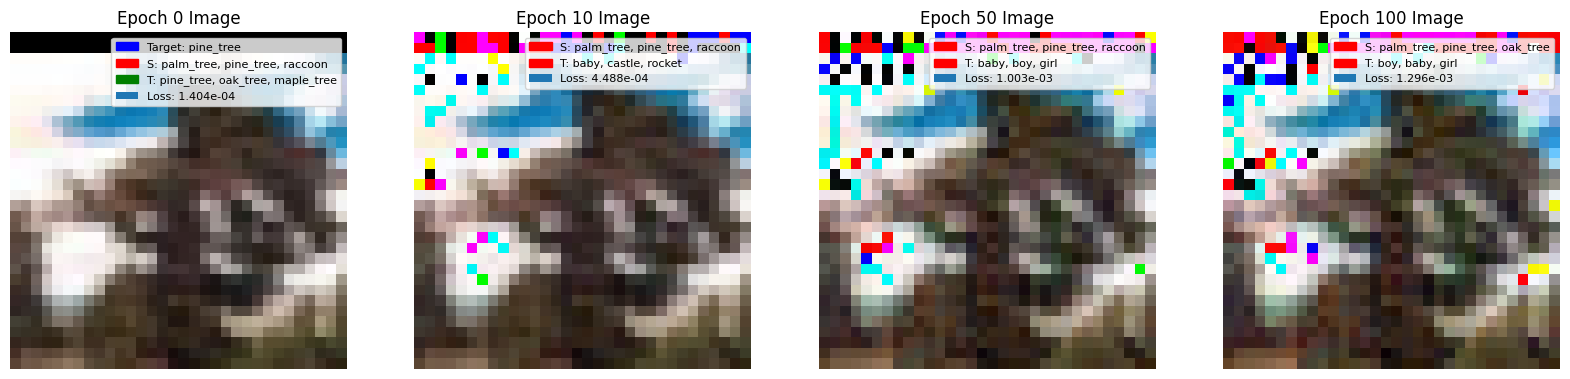

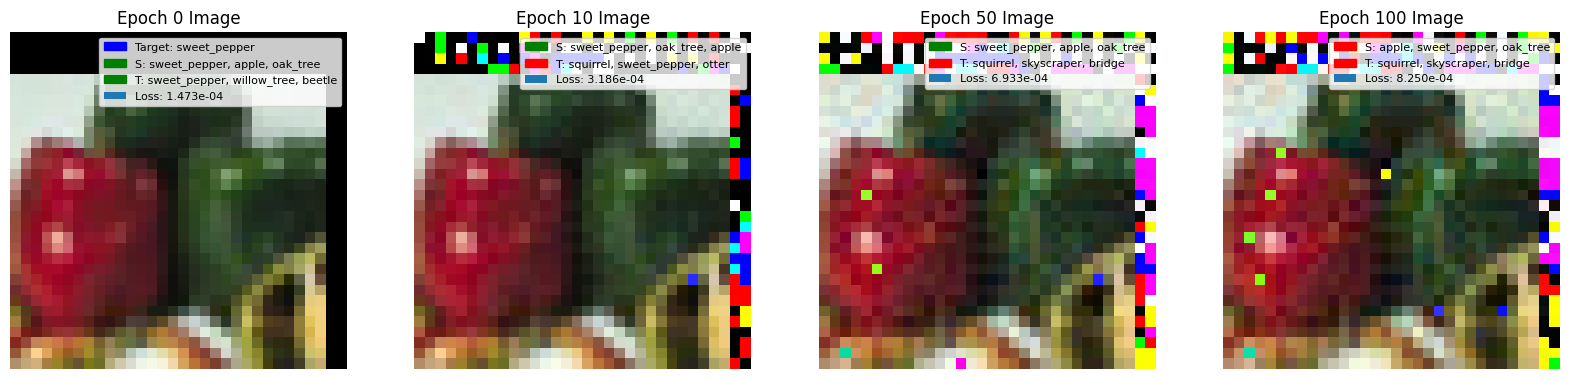

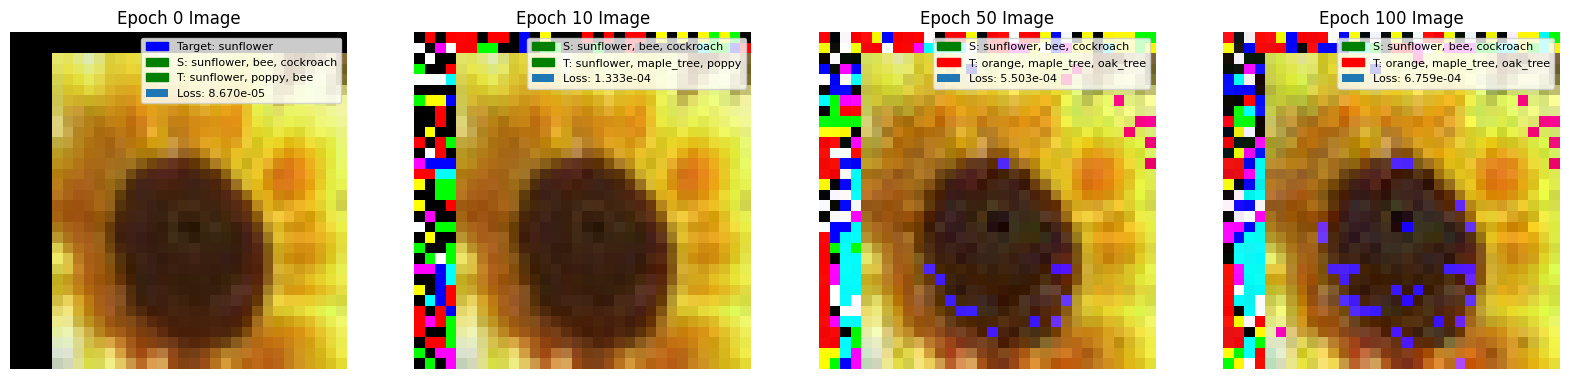

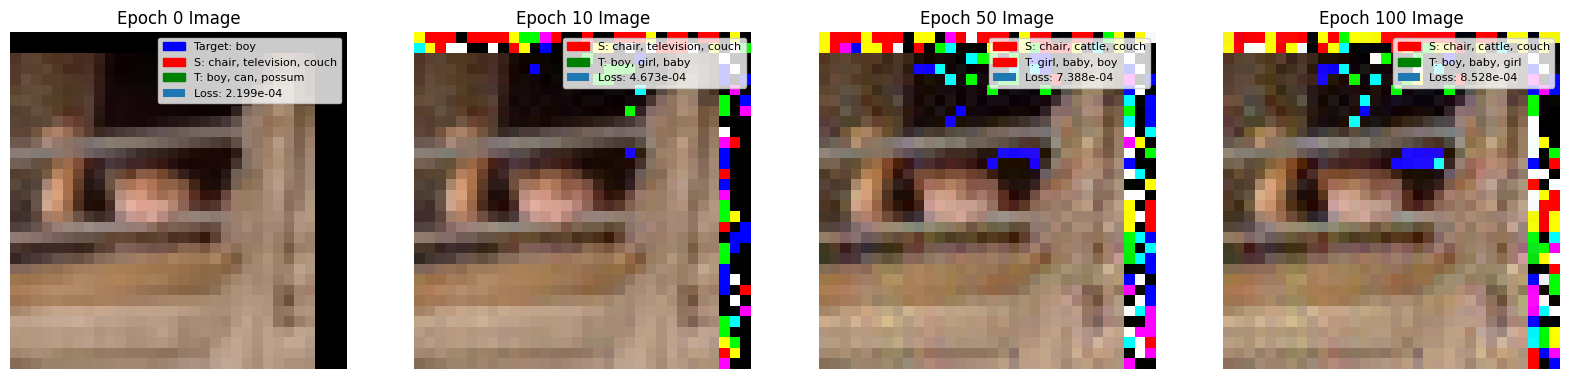

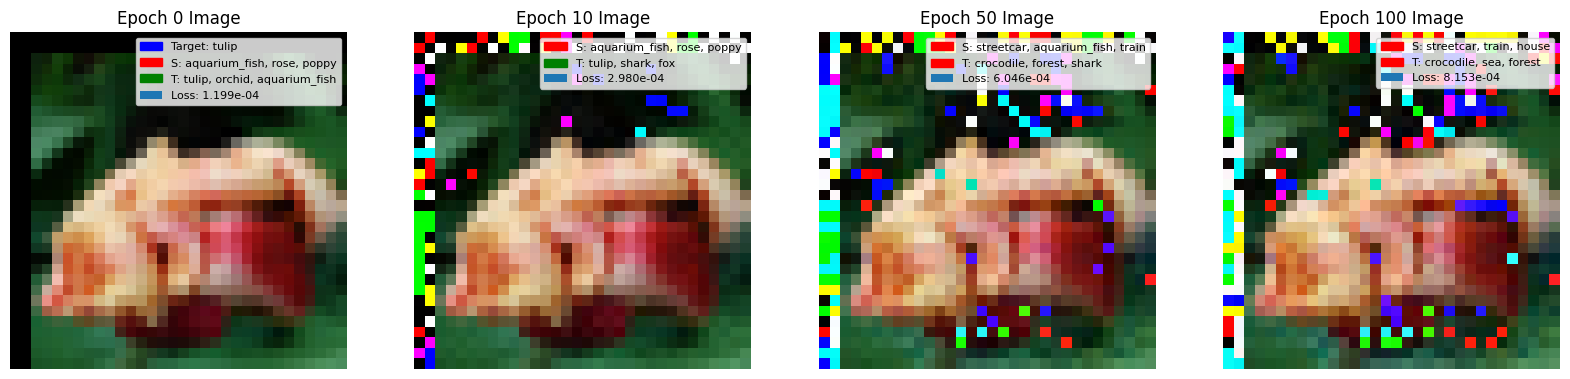

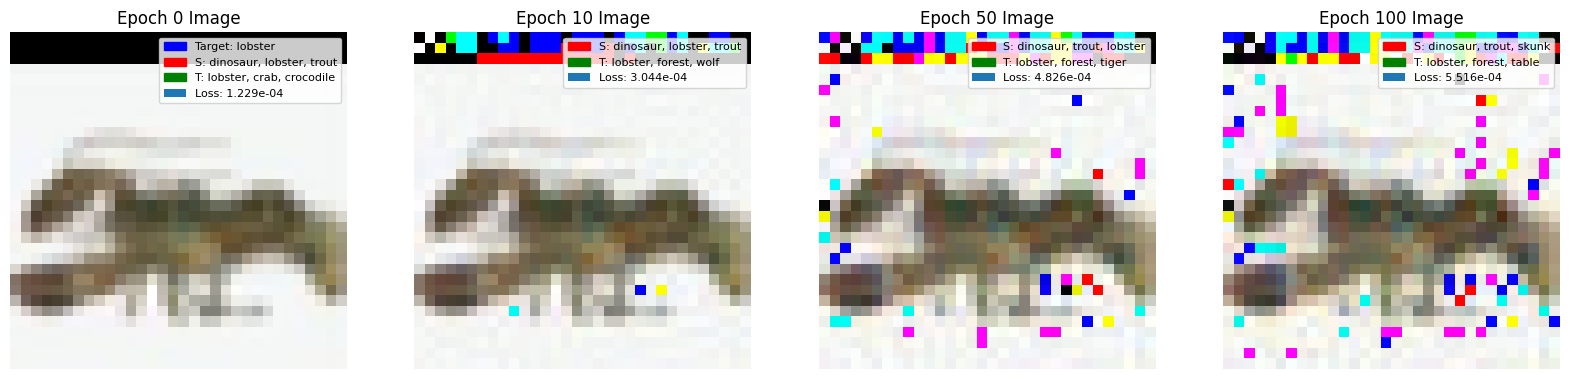

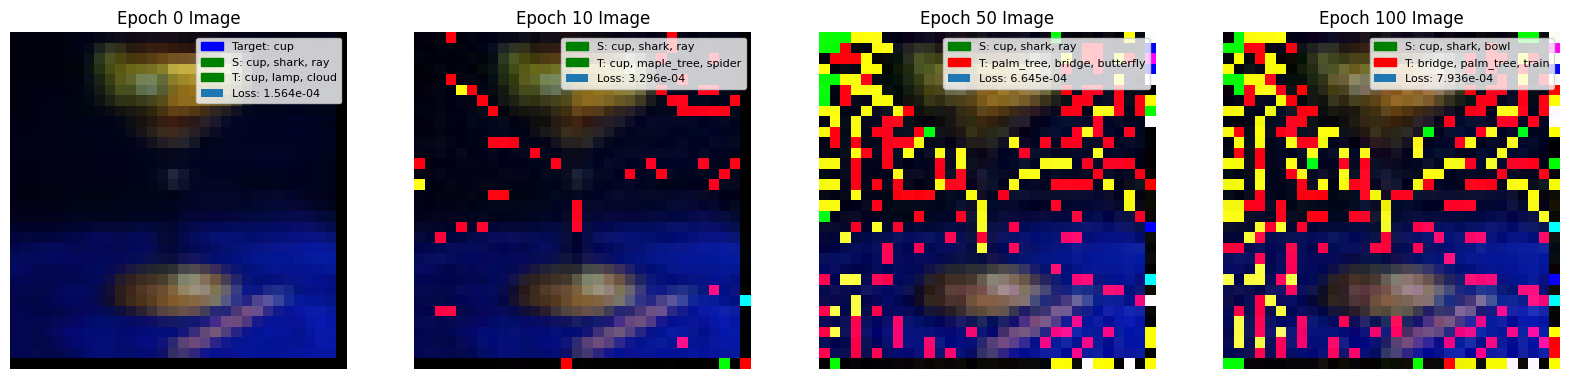

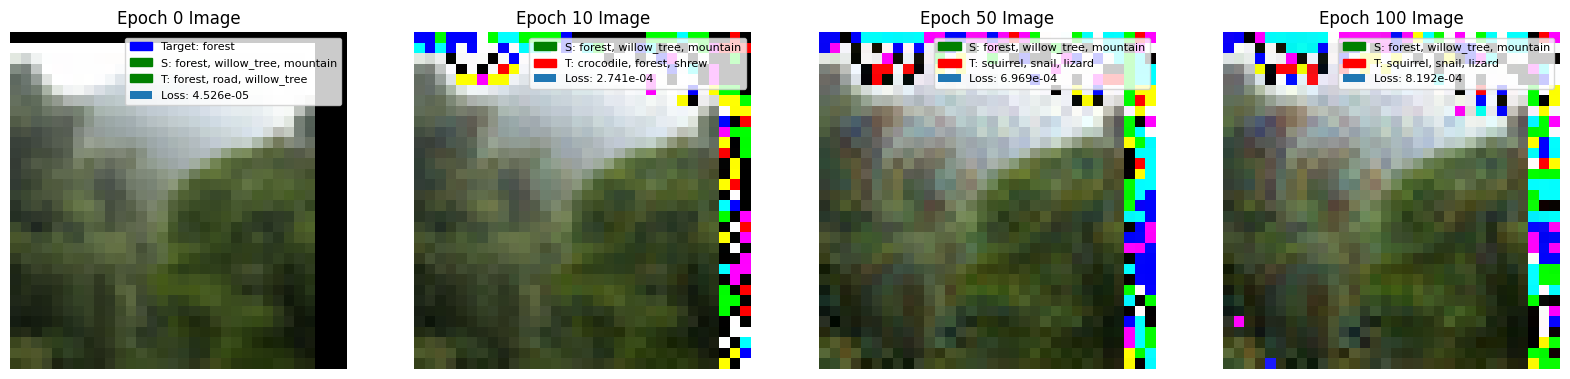

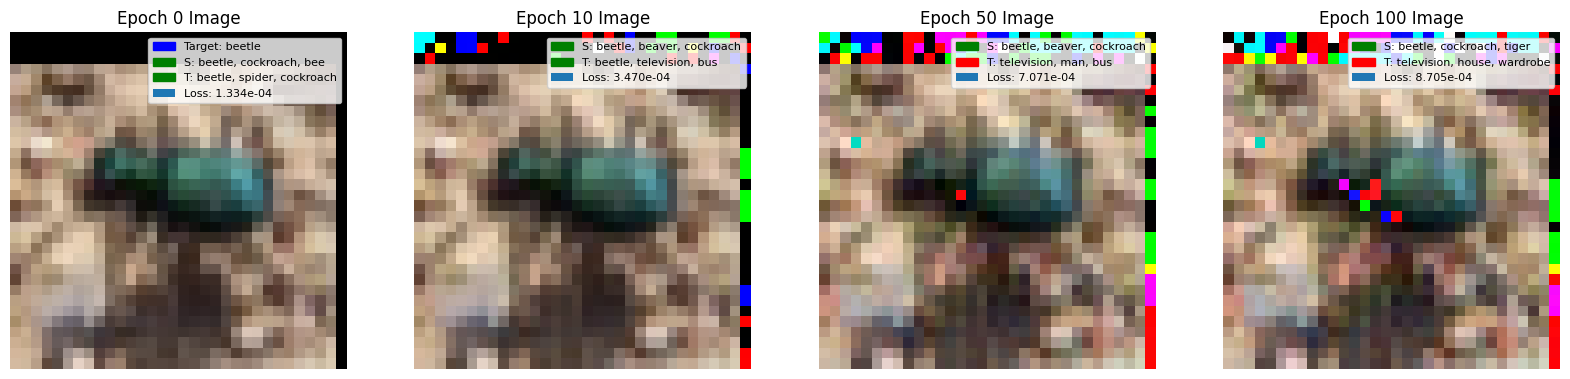

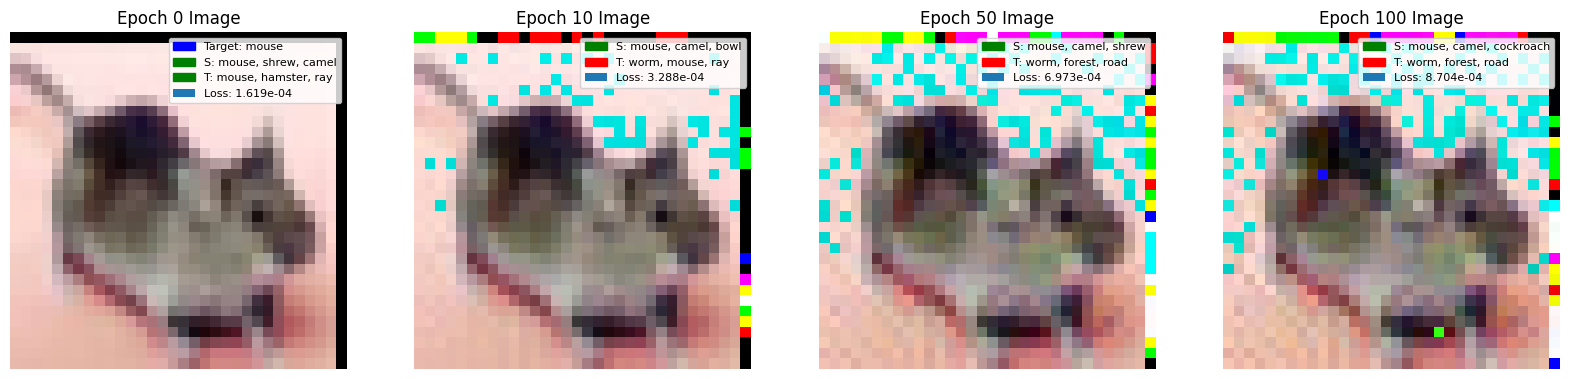

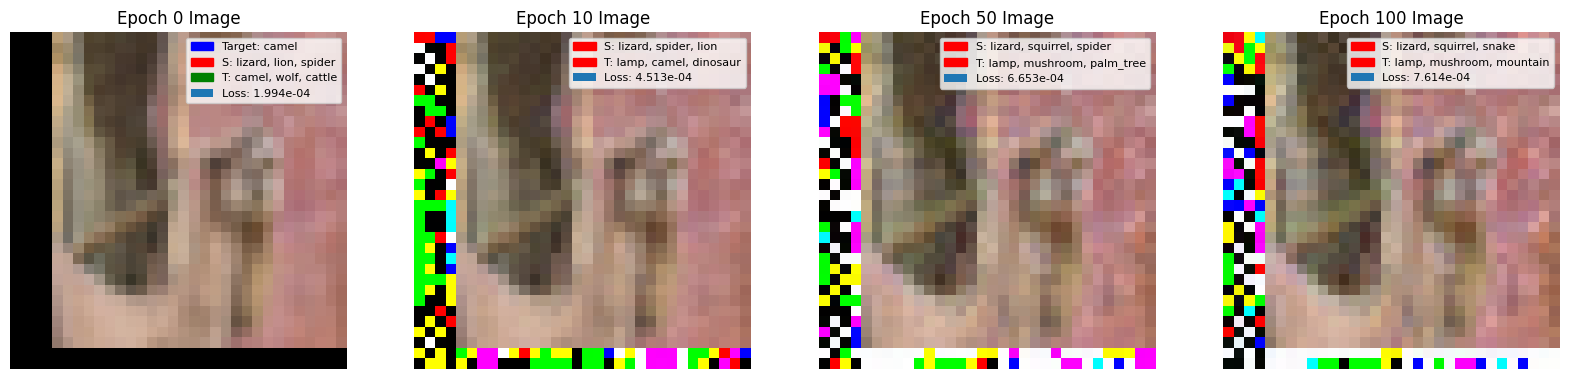

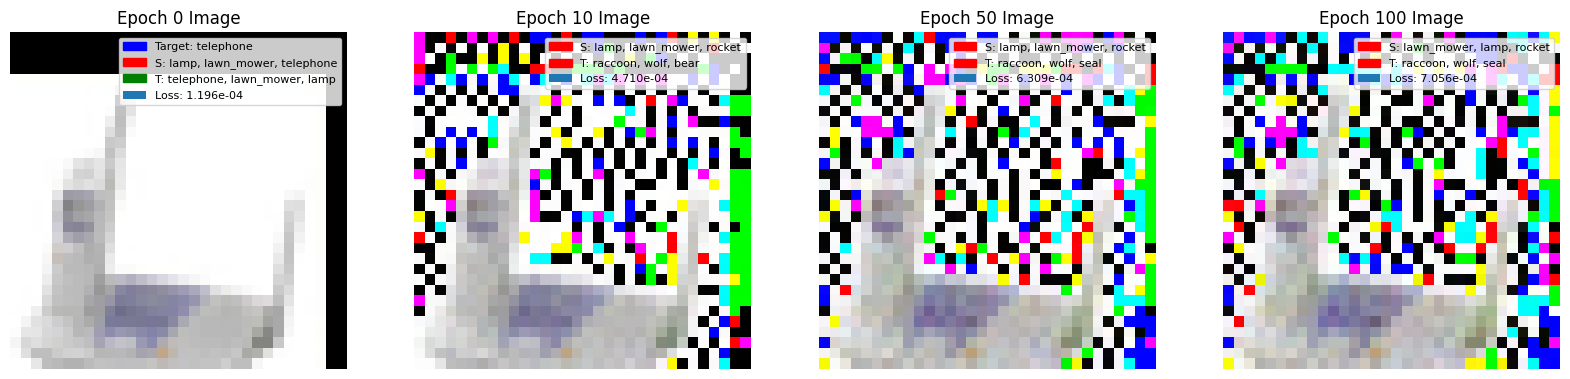

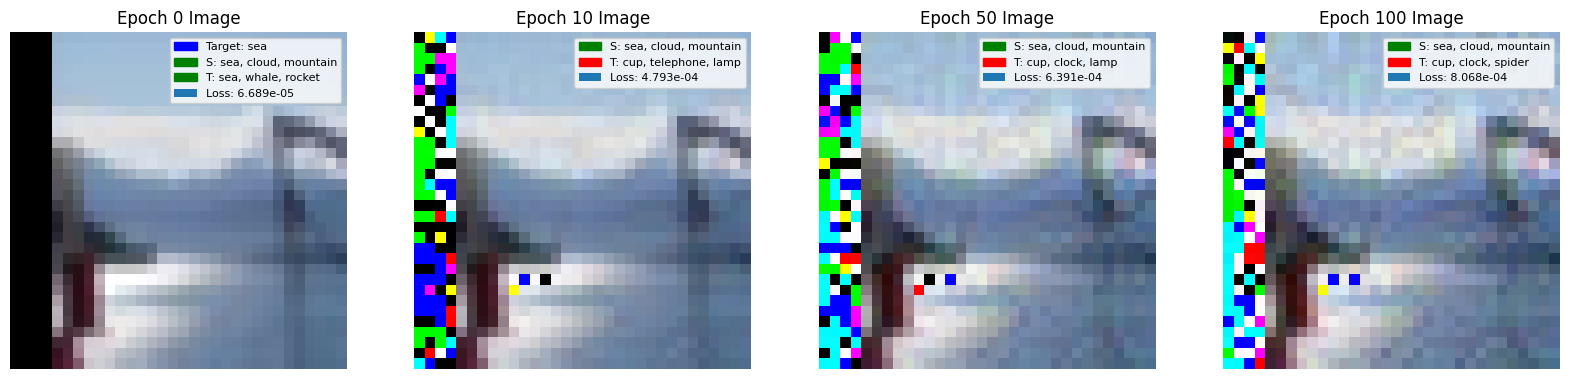

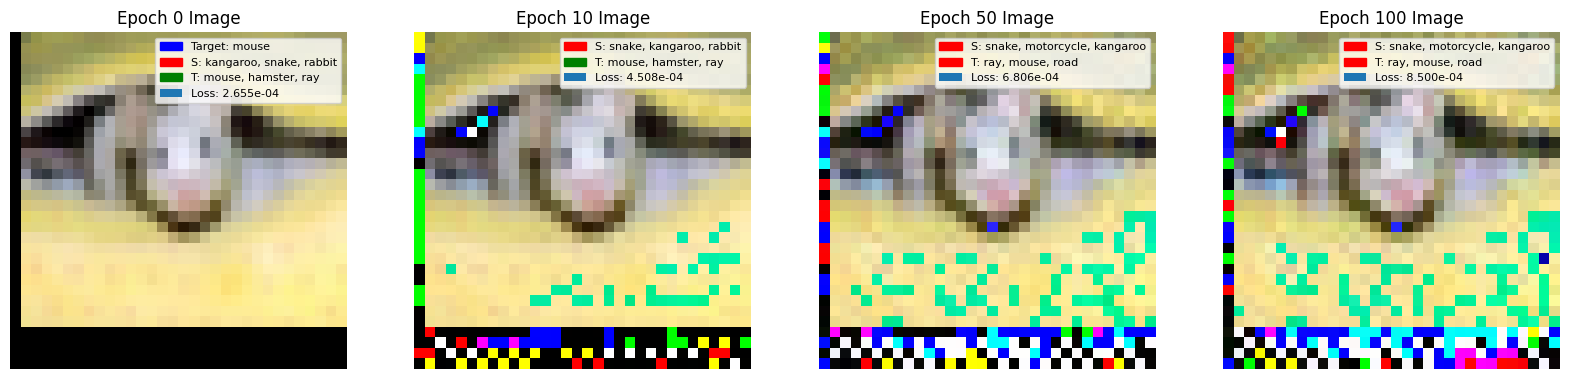

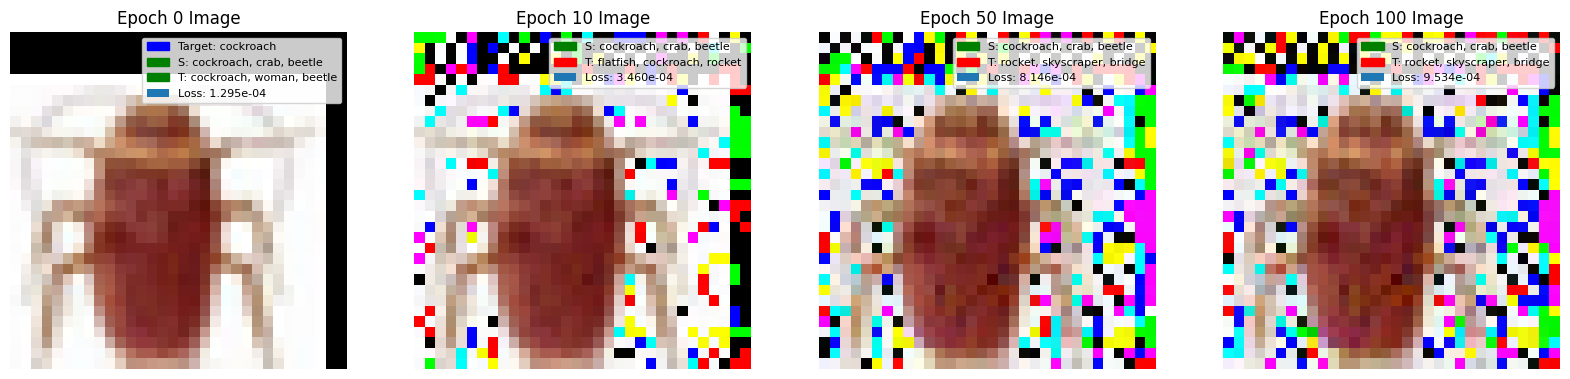

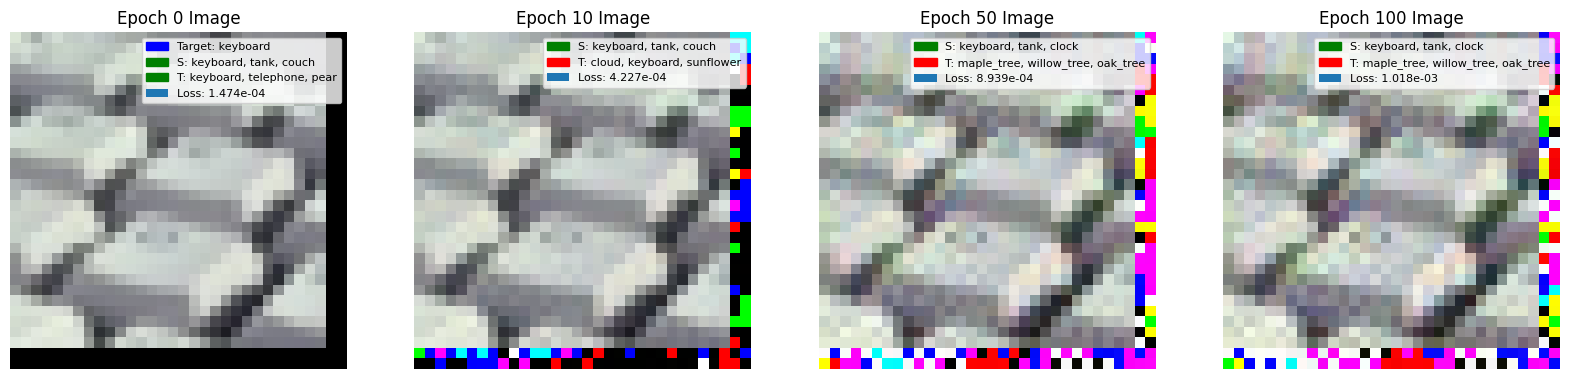

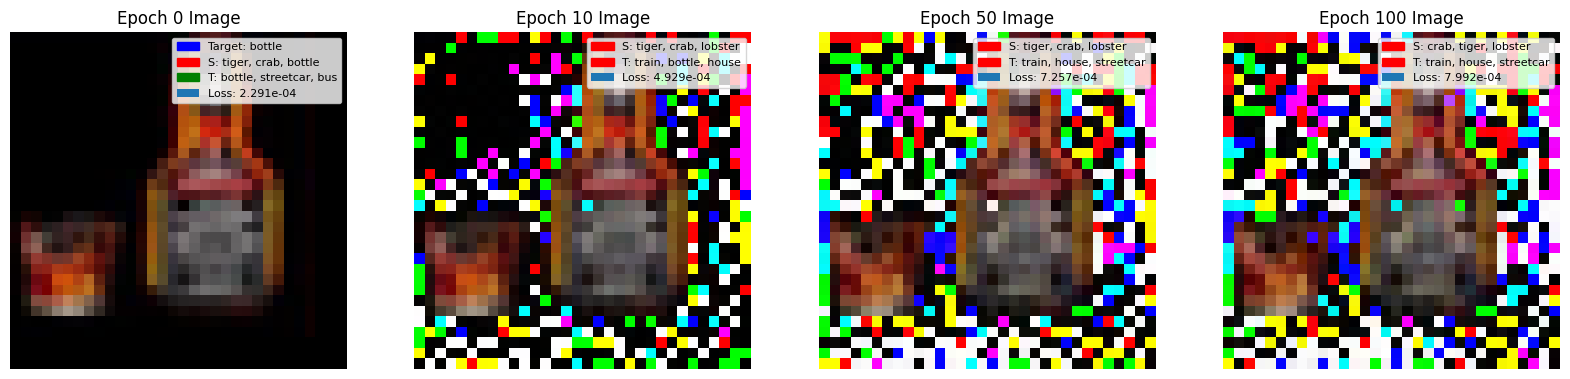

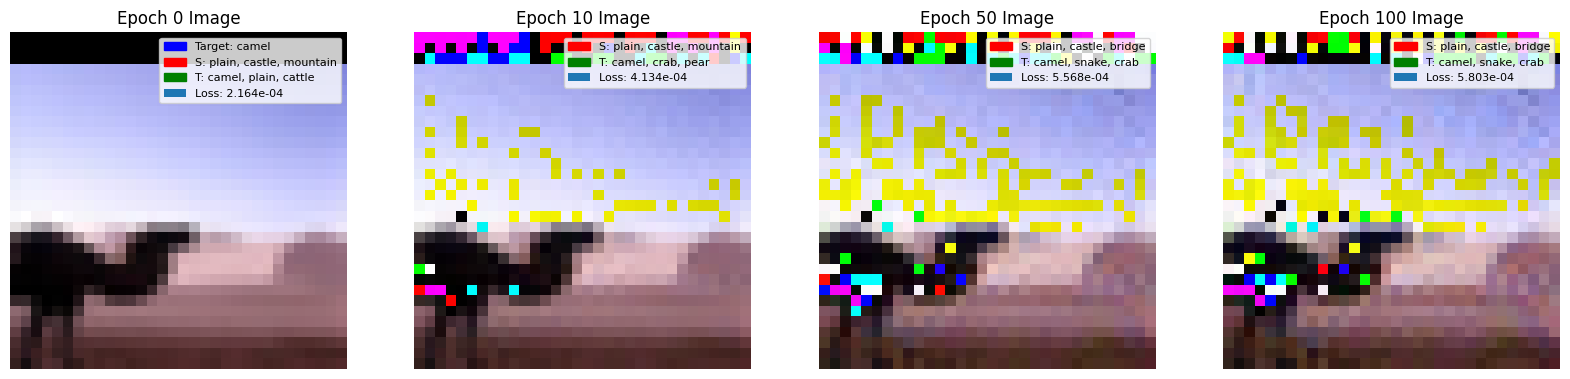

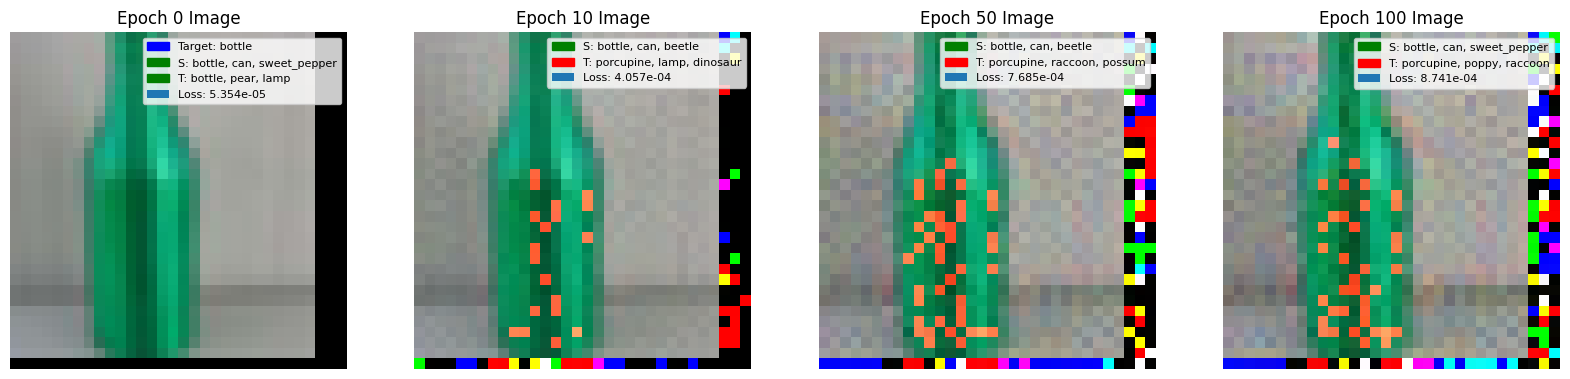

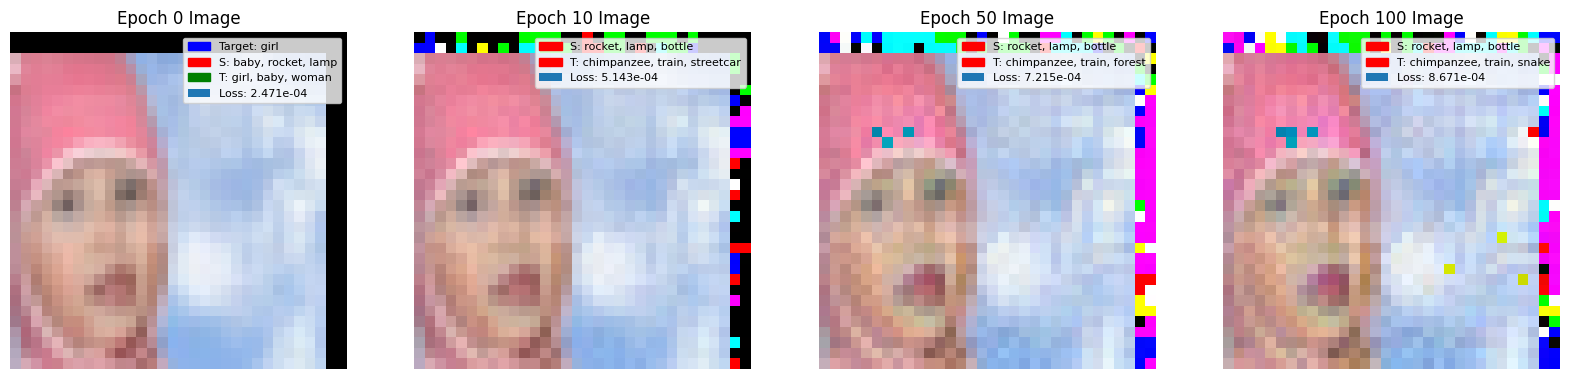

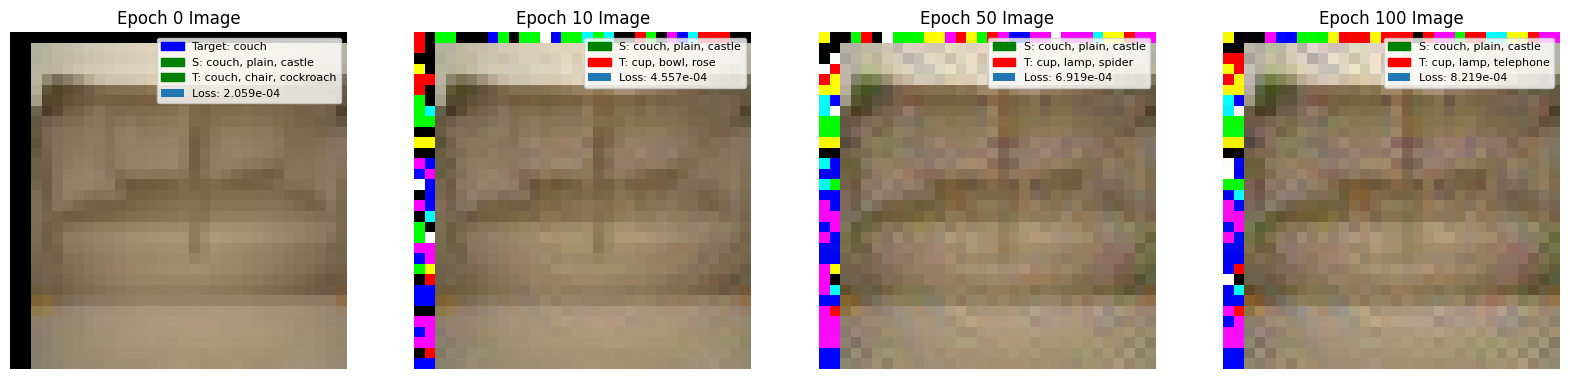

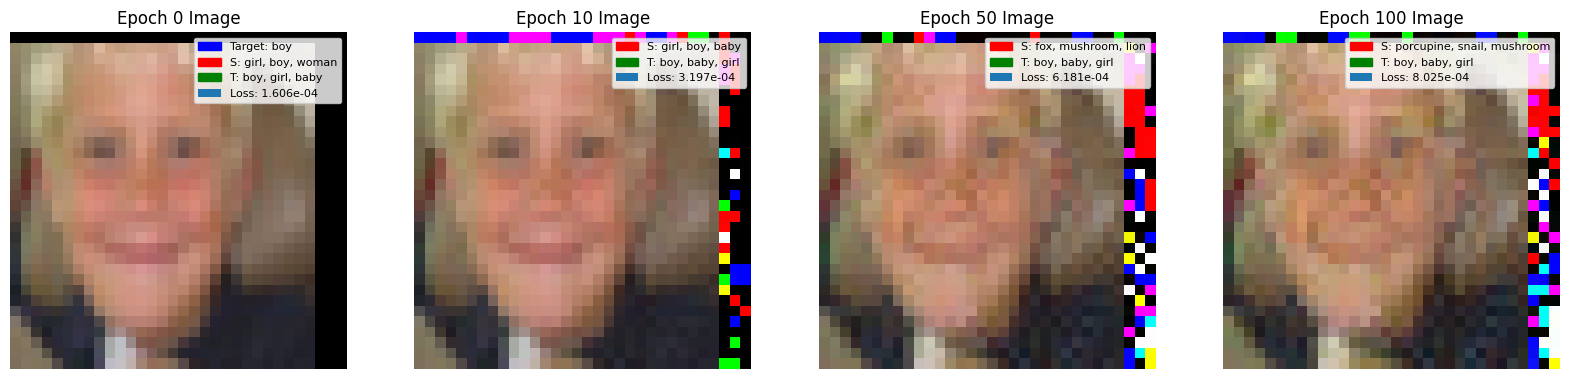

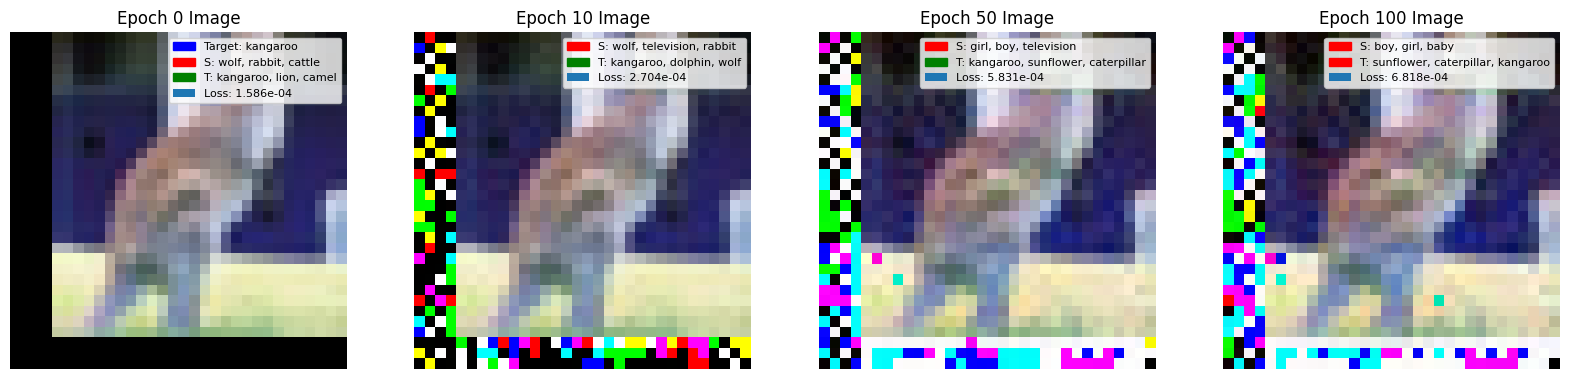

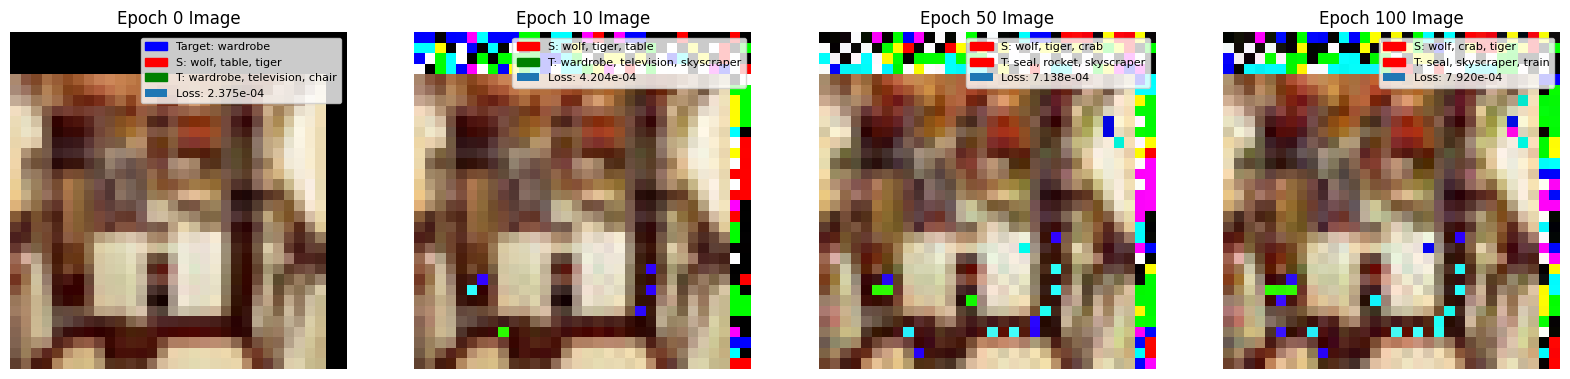

In [23]:
for image, target, index in train_loader:
    new_images = perturb_image(distiller, image, target, epochs=[0, 10, 50, 100])
    break